In [1]:
import pandas as pd
from functools import reduce
import seaborn as sns

import torch
from botorch.models import SingleTaskGP, HeteroskedasticSingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation

from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, LeaveOneOut

from gpytorch.kernels import RBFKernel
from gpytorch.constraints import Interval
from botorch.settings import validate_input_scaling,debug

from itertools import product

/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
dtype = torch.double
bounds = torch.tensor([[0., 0.], [1., 1.]], dtype=dtype, device=device)

cuda


In [3]:
validate_input_scaling(state=False)
debug(state=False)

In [4]:
def r2_score_numpy(y_true, y_pred):
    """
    Calculate the R-squared score.

    Parameters:
    y_true (np.array): Actual values of the dependent variable.
    y_pred (np.array): Predicted values from the regression model.

    Returns:
    float: The R-squared score.
    """
    # Mean of observed data
    y_mean = np.mean(y_true)
    
    # Total sum of squares
    SS_tot = np.sum((y_true - y_mean) ** 2)
    
    # Residual sum of squares
    SS_res = np.sum((y_true - y_pred) ** 2)
    
    # Calculate R^2
    R2 = 1 - (SS_res / SS_tot)
    
    return R2

In [5]:
batch_corrected_mean=pd.read_csv("SurfactinC_mean_no_log.csv")

In [6]:
batch_corrected_mean

,Batch_SampleType,SurfactinC
0,0_1,0.854438
1,0_2,0.646341
2,0_3,0.616621
3,0_4,0.819402
4,0_5,0.080535
5,0_6,0.969257
6,0_7,1.298842
7,0_CTRL,0.012949
8,0_QC,1.000000
9,0_REF,1.781692


In [7]:
batch_corrected_mean=batch_corrected_mean[~batch_corrected_mean["Batch_SampleType"].apply(lambda x: ("CTRL" in x) or ("QC" in x) or ("REF" in x))]
batch_corrected_mean=batch_corrected_mean.rename({"Batch_SampleType":"sample","SurfactinC":"mean"},axis=1)

In [8]:
batch_corrected_var=pd.read_csv("SurfactinC_sem_no_log.csv")

In [9]:
atch_corrected_var=batch_corrected_var[~batch_corrected_var["Batch_SampleType"].apply(lambda x: ("CTRL" in x) or ("QC" in x) or ("REF" in x))]
batch_corrected_var=batch_corrected_var.rename({"Batch_SampleType":"sample","SurfactinC":"sem"},axis=1)

In [6]:
allsamples=reduce(lambda x,y: pd.concat([x,y]),[pd.read_csv(str(i)+"_samples.csv") for i in range(0,6)])
 

In [11]:
mean1=pd.merge(allsamples,batch_corrected_mean, how='left', on="sample")

In [12]:
mean_var=pd.merge(mean1,batch_corrected_var, how='left', on="sample")

In [13]:
table_sim=mean_var[['Glucose', 'NH4Cl', 'MgSO4', 'KH2PO4', 'Na2HPO4', 'CaCl2','NaCl','mean','sem']]
#x_numpy=mean_var[['Glucose', 'NH4Cl', 'MgSO4', 'KH2PO4', 'Na2HPO4', 'CaCl2','NaCl']].values
#y_numpy=mean_var['mean'].values
#var_numpy=mean_var['var'].values

In [19]:
table_sim.to_csv("table_for_modelling.csv",index=False)
#table_sim.to_csv("table_for_modelling_no_log.csv",index=False)

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def plot_triangle_contour(data, columns, z_var='mean', file_path='contour_plots_nolog.png'):
    # Number of variables
    n = len(columns)
    fig, axs = plt.subplots(n, n, figsize=(20, 15))
    
    for i in range(n):
        for j in range(i + 1, n):
            # Prepare grid data for contour plot
            x = data[columns[i]]
            y = data[columns[j]]
            z = data[z_var]
            
            # Create grid points
            xi = np.linspace(x.min(), x.max(), 100)
            yi = np.linspace(y.min(), y.max(), 100)
            xi, yi = np.meshgrid(xi, yi)
            
            # Interpolate z values on this grid
            zi = griddata((x, y), z, (xi, yi), method='cubic')
            
            # Plotting on the correct subplot
            ax = axs[j][i]
            contour = ax.contourf(xi, yi, zi, levels=15, cmap='rainbow')
            fig.colorbar(contour, ax=ax)
            ax.set_xlabel(columns[i])
            ax.set_ylabel(columns[j])
            ax.set_title(f'{columns[i]} vs {columns[j]}')

    # Hide unused subplots
    for i in range(n):
        for j in range(n):
            if i < j:
                axs[i][j].axis('off')
            elif i == j:
                axs[i][j].axis('off')

    plt.tight_layout()
    plt.savefig(file_path,dpi=300)
    plt.close()



# Columns of interest for plotting
columns = ['Glucose', 'NH4Cl', 'MgSO4', 'KH2PO4', 'Na2HPO4', 'CaCl2', 'NaCl']

# Generate and save the contour plots
plot_triangle_contour(table_sim, columns)

In [21]:
train_x = torch.from_numpy(mean_var[['Glucose', 'NH4Cl', 'MgSO4', 'KH2PO4', 'Na2HPO4', 'CaCl2','NaCl']].values).to(device=device, dtype=dtype)
train_y = torch.from_numpy(mean_var['mean'].values).reshape(-1,1).to(device=device, dtype=dtype)
y_var=torch.from_numpy(mean_var['sem'].values).reshape(-1,1).to(device=device, dtype=dtype)

In [26]:
gp_model = HeteroskedasticSingleTaskGP(train_x, train_y,y_var)

/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.8894], device='cuda:0', dtype=torch.float64), std = tensor([0.4378], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.3040], device='cuda:0', dtype=torch.float64), std = tensor([0.7514], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [27]:
#empirical_lengthscales=torch.tensor([0.3,0.3,0.3,0.3,0.3,0.3,0.3]).to(device=device,dtype=dtype)
#upper_empirical_lengthscales=torch.tensor([1,1,1,1,1,1,1]).to(device=device,dtype=dtype)

In [28]:
#gp_model.covar_module.base_kernel.register_constraint("raw_lengthscale", Interval(0.7, 1))
#gp_model.covar_module.base_kernel.register_constraint("raw_lengthscale", Interval(empirical_lengthscales,upper_empirical_lengthscales))


In [29]:
mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): _GaussianLikelihoodBase(
    (noise_covar): HeteroskedasticNoise(
      (noise_model): SingleTaskGP(
        (likelihood): GaussianLikelihood(
          (noise_covar): HomoskedasticNoise(
            (noise_prior): SmoothedBoxPrior()
            (raw_noise_constraint): GreaterThan(1.000E-04)
          )
        )
        (mean_module): ConstantMean()
        (covar_module): ScaleKernel(
          (base_kernel): MaternKernel(
            (lengthscale_prior): GammaPrior()
            (raw_lengthscale_constraint): Positive()
          )
          (outputscale_prior): GammaPrior()
          (raw_outputscale_constraint): Positive()
        )
        (outcome_transform): Log()
      )
      (_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): HeteroskedasticSingleTaskGP(
    (likelihood): _GaussianLikelihoodBase(
      (noise_covar): HeteroskedasticNoise(
        (noise_model): SingleTaskGP(
          (likelihood): GaussianLikelihood(
 

In [30]:
gp_model.covar_module.base_kernel.lengthscale

tensor([[0.1663, 0.4071, 0.6388, 0.5140, 0.5334, 0.5117, 0.6020]],
       device='cuda:0', dtype=torch.float64, grad_fn=<SoftplusBackward0>)

rbf_kernel = RBFKernel(
        ard_num_dims=num_dims,
        lengthscale_constraint=Interval(
            torch.tensor(empirical_lengthscales, dtype=torch.float32),
            torch.tensor(empirical_lengthscales+0.01, dtype=torch.float32),
            ),
        )
gp_kernel = ScaleKernel(rbf_kernel)
gp = FixedNoiseGP(feature_pt, objective_pt, train_Yvar=objective_var_pt,
                      covar_module=gp_kernel)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
ret = fit_gpytorch_mll(mll)

In [31]:
with torch.no_grad():
    predictive_posterior = mll.model.posterior(train_x, observation_noise=True)
    predictions = predictive_posterior.mean
    pre2=predictions.reshape(1,-1).cpu().numpy()

In [32]:
r2_score(train_y.cpu().numpy().reshape(1,-1)[0],pre2[0])

0.9997026094393259

In [33]:
r2_score_numpy(train_y.cpu().numpy().reshape(1,-1)[0],pre2[0])

0.9997026094393259

In [34]:
for_excel=pd.DataFrame({"y_true":train_y.cpu().numpy().reshape(1,-1)[0],"y_pred":pre2[0]})

In [35]:
for_excel.to_excel("compare.xlsx",index=False)

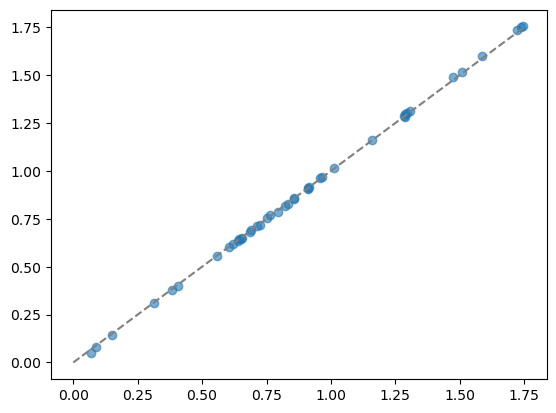

In [37]:
ideal_line = np.linspace(0, 1.75, 100)  # Ideal case line
plt.scatter(pre2[0],train_y.cpu().numpy().reshape(1,-1)[0],alpha=0.6)

plt.plot(ideal_line, ideal_line, '--', color='gray', label='Ideal case')

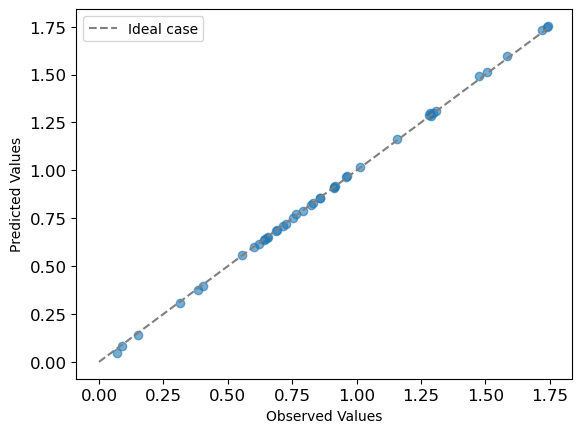

In [39]:
# Your existing data variables 'pre2' and 'train_y' should be defined here
# For example, you might have pre2 and train_y from your model's output

# Generate an ideal case line
ideal_line = np.linspace(0, 1.75, 100)

# Create the scatter plot
plt.scatter(pre2[0], train_y.cpu().numpy().reshape(1, -1)[0], alpha=0.6)

# Plot the ideal case line
plt.plot(ideal_line, ideal_line, '--', color='gray', label='Ideal case')

# Setting the labels for the axes
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')

# Increasing the tick labels size
plt.xticks(fontsize=12)  # Increase x-axis tick label size
plt.yticks(fontsize=12)  # Increase y-axis tick label size

# Adding a legend
plt.legend()
plt.savefig("naive_gpr.jpg", dpi=600, transparent=True)
# Show the plot
plt.show()

/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.8667], device='cuda:0', dtype=torch.float64), std = tensor([0.4590], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.3540], device='cuda:0', dtype=torch.float64), std = tensor([0.7957], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


tensor([[0.1695, 0.3960, 0.5403, 0.4612, 0.5187, 0.4801, 0.5392]],
       device='cuda:0', dtype=torch.float64, grad_fn=<SoftplusBackward0>)
[1.08547475 0.97852162 0.81595875 0.71274263 0.96313959 0.82490344] [1.31065256 0.82873101 1.16354158 0.69061273 1.30186508 0.85775851]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.8717], device='cuda:0', dtype=torch.float64), std = tensor([0.4545], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.3463], device='cuda:0', dtype=torch.float64), std = tensor([0.7955], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


tensor([[0.1705, 0.3735, 0.6104, 0.4789, 0.5267, 0.4666, 0.5209]],
       device='cuda:0', dtype=torch.float64, grad_fn=<SoftplusBackward0>)
[0.75465196 1.01499232 1.154686   1.08988693 0.64248244 0.7405262 ] [0.60039136 0.90694905 1.49137028 1.28776104 0.7695586  0.91716915]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.9200], device='cuda:0', dtype=torch.float64), std = tensor([0.4511], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.2828], device='cuda:0', dtype=torch.float64), std = tensor([0.7931], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


tensor([[0.1608, 0.4028, 0.5238, 0.4993, 0.5158, 0.4915, 0.5871]],
       device='cuda:0', dtype=torch.float64, grad_fn=<SoftplusBackward0>)
[0.9076811  0.83188243 0.85877475 0.60425014 1.43307698 0.91677058] [0.65195668 0.64362837 0.71015307 0.30934441 1.28220055 0.63583938]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.8860], device='cuda:0', dtype=torch.float64), std = tensor([0.4476], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.3236], device='cuda:0', dtype=torch.float64), std = tensor([0.7905], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


tensor([[0.1872, 0.4857, 0.6289, 0.5234, 0.3896, 0.4118, 0.5972]],
       device='cuda:0', dtype=torch.float64, grad_fn=<SoftplusBackward0>)
[1.12113807 0.93534556 0.65439721 1.26259754 0.84160056 0.83447189] [0.85443788 0.64634119 0.96528333 1.59793268 1.0164715  0.37636281]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.9160], device='cuda:0', dtype=torch.float64), std = tensor([0.4676], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.3014], device='cuda:0', dtype=torch.float64), std = tensor([0.8123], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


tensor([[0.1587, 0.4052, 0.6312, 0.4751, 0.5080, 0.4933, 0.5670]],
       device='cuda:0', dtype=torch.float64, grad_fn=<SoftplusBackward0>)
[0.82714002 0.96255001 0.86661678 0.86441723 0.98098347 1.09379339] [0.61662146 0.81940189 0.68179082 0.7520441  0.71997994 0.78802531]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.8834], device='cuda:0', dtype=torch.float64), std = tensor([0.3960], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.2886], device='cuda:0', dtype=torch.float64), std = tensor([0.7252], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


tensor([[0.3166, 0.2872, 0.5752, 0.3364, 0.4011, 0.4651, 0.3763]],
       device='cuda:0', dtype=torch.float64, grad_fn=<SoftplusBackward0>)
[0.74781646 1.14308817 0.79626482 0.70200516 0.78670148 0.66470762] [0.96925717 1.75073121 1.73319843 0.14137053 0.39855575 0.55822115]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.8818], device='cuda:0', dtype=torch.float64), std = tensor([0.3850], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.2316], device='cuda:0', dtype=torch.float64), std = tensor([0.5022], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


tensor([[0.2265, 0.3944, 0.5403, 0.3899, 0.4839, 0.5293, 0.5538]],
       device='cuda:0', dtype=torch.float64, grad_fn=<SoftplusBackward0>)
[0.62556405 0.88392678 1.03135796 0.99519556 0.82954132 1.02317162] [0.08053543 1.29884151 1.7539433  1.51491859 0.91241059 0.04686891]


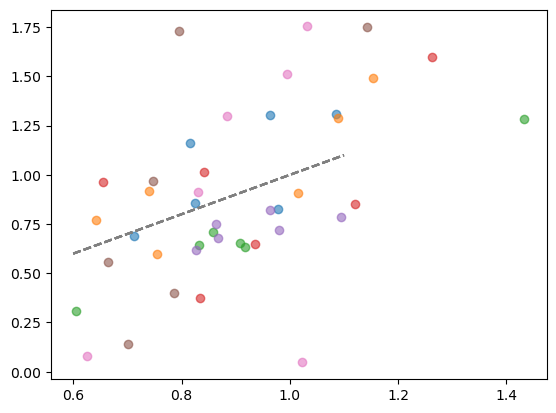

In [42]:
#samples = table_sim.shape[0]
kf = KFold(n_splits=7, shuffle=True)#, random_state=42) #LOO is equal to k-fold when k is the total number of samples

rmse_scores = []
r2list=[]
count=0
for train_index, test_index in kf.split(table_sim):
    # Splitting the data
    train, test = table_sim.iloc[train_index], table_sim.iloc[test_index]

    # Feature scaling
    #scaler = StandardScaler().fit(train[["Glucose", "NH4Cl"]].values)
    train_x = torch.from_numpy(train[['Glucose', 'NH4Cl', 'MgSO4', 'KH2PO4', 'Na2HPO4', 'CaCl2','NaCl']].values).to(device=device,dtype=dtype)
    test_x = torch.from_numpy(test[['Glucose', 'NH4Cl', 'MgSO4', 'KH2PO4', 'Na2HPO4', 'CaCl2','NaCl']].values).to(device=device,dtype=dtype)

    # Preparing target variables
    train_y = torch.from_numpy(train["mean"].values).reshape(-1, 1).to(device=device,dtype=dtype)
    test_y = test["mean"].values.reshape(1,-1)[0]

    # Preparing observed variance
    observed_var = torch.from_numpy(train["sem"].values).reshape(-1, 1).to(device=device,dtype=dtype)

    # Model training
    model1 = HeteroskedasticSingleTaskGP(train_X=train_x, train_Y=train_y, train_Yvar=observed_var)
    #defined_lengthscales=torch.tensor([0.3,0.3,0.3,0.3,0.3,0.3,0.3]).to(device=device,dtype=dtype)
    #upper_defined_lengthscales=torch.tensor([1,1,1,1,1,1,1]).to(device=device,dtype=dtype)
    
    #model1.covar_module.base_kernel.register_constraint("raw_lengthscale", Interval(defined_lengthscales,upper_defined_lengthscales))
    #model1.covar_module.base_kernel.register_constraint("raw_lengthscale", Interval(0.9, 1))
    mll1 = ExactMarginalLogLikelihood(model1.likelihood, model1)
    fit_gpytorch_model(mll1)

    

    print(model1.covar_module.base_kernel.lengthscale)

    with torch.no_grad():
        predictive_posterior = mll1.model.posterior(test_x, observation_noise=True)
        predictions = predictive_posterior.mean
        pre2=predictions.reshape(1,-1).cpu().numpy()
        rsme = np.sqrt(np.mean((pre2[0] - test_y) ** 2))
        print(pre2[0],test_y)
        r2sc=r2_score_numpy(test_y,pre2[0])
    
    ideal_line = np.linspace(0.6, 1.1, 100)  # Ideal case line
    plt.scatter(pre2[0],test_y,alpha=0.6,label="split"+str(count+1))
    plt.plot(ideal_line, ideal_line, '--', color='gray', label='Ideal case')
    #plt.legend()
    r2list.append(r2sc)  
    rmse_scores.append(rsme.item())
    count=count+1
    del model1,mll1
plt.savefig("naive_gpr_cross.jpg", dpi=600, transparent=True)

In [74]:
r2list

[-0.16780355260655022,
 -0.6093551650646409,
 -0.3058879665037513,
 -0.41193573728973853,
 0.06874134981305813,
 -0.5685493409700833,
 -0.7809747622208423]

In [90]:
# Define device and dtype for PyTorch tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32

# Initialize KFold
kf = KFold(n_splits=7, shuffle=True)

# Grid of lengthscales
lengthscale_grid = torch.arange(0.3, 0.9, 0.1).tolist()

# Storage for results
all_rmse_scores = []
all_r2_scores = []

# Iterate over each lengthscale configuration
for lengthscale_value in lengthscale_grid:
    # Prepare lists for storing scores for current lengthscale
    rmse_scores = []
    r2_scores = []

    # Perform cross-validation
    for train_index, test_index in kf.split(table_sim):
        # Splitting the data
        train, test = table_sim.iloc[train_index], table_sim.iloc[test_index]

        # Convert data to PyTorch tensors
        train_x = torch.from_numpy(train[['Glucose', 'NH4Cl', 'MgSO4', 'KH2PO4', 'Na2HPO4', 'CaCl2', 'NaCl']].values).to(device=device, dtype=dtype)
        test_x = torch.from_numpy(test[['Glucose', 'NH4Cl', 'MgSO4', 'KH2PO4', 'Na2HPO4', 'CaCl2', 'NaCl']].values).to(device=device, dtype=dtype)
        train_y = torch.from_numpy(train["mean"].values).reshape(-1, 1).to(device=device, dtype=dtype)
        test_y = test["mean"].values.reshape(1, -1)[0]
        observed_var = torch.from_numpy(train["sem"].values).reshape(-1, 1).to(device=device, dtype=dtype)

        # Setup the model with current lengthscale
        model = HeteroskedasticSingleTaskGP(train_X=train_x, train_Y=train_y, train_Yvar=observed_var)
        defined_lengthscales = torch.tensor([lengthscale_value] * 7).to(device=device, dtype=dtype)
        model.covar_module.base_kernel.register_constraint("raw_lengthscale", Interval(defined_lengthscales, defined_lengthscales + 0.1))
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_model(mll)

        # Predict and calculate metrics
        with torch.no_grad():
            predictive_posterior = mll.model.posterior(test_x, observation_noise=True)
            predictions = predictive_posterior.mean
            predictions = predictions.reshape(1, -1).cpu().numpy()[0]
            rmse = np.sqrt(np.mean((predictions - test_y) ** 2))
            r2sc = r2_score_numpy(test_y, predictions)

        # Append scores
        rmse_scores.append(rmse)
        r2_scores.append(r2sc)

        # Clean up
        del model, mll

    # Store results for all folds for current lengthscale
    all_rmse_scores.append(rmse_scores)
    all_r2_scores.append(r2_scores)

# After all configurations and splits have been processed, you can analyze `all_rmse_scores` and `all_r2_scores`

/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/gp_regression.py:298: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=train_X, Y=train_Y, Yvar=train_Yvar)
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.8888], device='cuda:0'), std = tensor([0.4519], device='cuda:0')). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is s

KeyboardInterrupt: 

In [30]:
all_r2_scores

[[0.39501654401452513,
  0.12894448621592858,
  0.19018561145738466,
  0.014663746403535405,
  0.4453364742408056,
  -0.0012804192464792585,
  0.38370007141280205],
 [0.053224493339654955,
  0.508074382531067,
  -0.880525118532623,
  -0.21689741056501743,
  0.5499217985772987,
  0.12622166978644356,
  0.28323497193525815],
 [0.36599513998880295,
  -1.0763306280170828,
  0.1466639527012915,
  0.2019189160021272,
  0.22768399085717506,
  0.5602236174006172,
  0.33977731166155956],
 [0.32851538128684743,
  -0.5766098092670708,
  0.046205257449181136,
  0.15529895698185037,
  0.054522505751493755,
  -0.4894890088720265,
  -0.1995761639289757],
 [0.3391300266210897,
  0.14444088407080502,
  0.4201899412384159,
  0.39349014744749466,
  0.42852651136122855,
  -0.10471728753661469,
  0.4776819389299589]]

In [33]:
lengthscale_grid

[0.30000001192092896,
 0.4000000059604645,
 0.5,
 0.6000000238418579,
 0.699999988079071]

In [33]:
# Define device and dtype for PyTorch tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32

# Initialize KFold
kf = KFold(n_splits=7, shuffle=True)

# Define the range for lengthscales and prepare grid
lengthscale_range = torch.arange(0.3, 0.9, 0.3)
lengthscale_combinations = list(product(lengthscale_range, repeat=7))

In [35]:
# Storage for results
all_rmse_scores = []
all_r2_scores = []
all_lengthscales=[]

count=0
# Iterate over each combination of lengthscales
for lengthscales in lengthscale_combinations:
    print("Run"+str(count+1))
    # Prepare lists for storing scores for current combination
    rmse_scores = []
    r2_scores = []

    # Perform cross-validation
    for train_index, test_index in kf.split(table_sim):
        # Splitting the data
        train, test = table_sim.iloc[train_index], table_sim.iloc[test_index]

        # Convert data to PyTorch tensors
        train_x = torch.from_numpy(train[['Glucose', 'NH4Cl', 'MgSO4', 'KH2PO4', 'Na2HPO4', 'CaCl2', 'NaCl']].values).to(device=device, dtype=dtype)
        test_x = torch.from_numpy(test[['Glucose', 'NH4Cl', 'MgSO4', 'KH2PO4', 'Na2HPO4', 'CaCl2', 'NaCl']].values).to(device=device, dtype=dtype)
        train_y = torch.from_numpy(train["mean"].values).reshape(-1, 1).to(device=device, dtype=dtype)
        test_y = test["mean"].values.reshape(1, -1)[0]
        observed_var = torch.from_numpy(train["sem"].values).reshape(-1, 1).to(device=device, dtype=dtype)

        # Setup the model with current lengthscales
        model = HeteroskedasticSingleTaskGP(train_X=train_x, train_Y=train_y, train_Yvar=observed_var)
        defined_lengthscales = torch.tensor(lengthscales).to(device=device, dtype=dtype)
        model.covar_module.base_kernel.register_constraint("raw_lengthscale", Interval(defined_lengthscales, defined_lengthscales + 0.3))
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_model(mll)

        # Predict and calculate metrics
        with torch.no_grad():
            predictive_posterior = mll.model.posterior(test_x, observation_noise=True)
            predictions = predictive_posterior.mean
            predictions = predictions.reshape(1, -1).cpu().numpy()[0]
            rmse = np.sqrt(np.mean((predictions - test_y) ** 2))
            r2sc = r2_score_numpy(test_y, predictions)

        # Append scores
        rmse_scores.append(rmse)
        r2_scores.append(r2sc)

        # Clean up
        del model, mll

    # Store results for all folds for current lengthscale combination
    all_rmse_scores.append(rmse_scores)
    all_r2_scores.append(r2_scores)
    all_lengthscales.append(lengthscales)
    count=count+1

# After all configurations and splits have been processed, you can analyze `all_rmse_scores` and `all_r2_scores`

Run1


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/gp_regression.py:298: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=train_X, Y=train_Y, Yvar=train_Yvar)
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.8621], device='cuda:0'), std = tensor([0.4422], device='cuda:0')). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is s

KeyboardInterrupt: 

In [34]:
len(lengthscale_combinations)

2187

In [7]:
df=pd.read_csv("SurfactinC_data_no_log.csv")

In [8]:
df=df.rename({"Batch_SampleType":"sample"},axis=1)

In [9]:
newdf=pd.merge(df,allsamples, how='left', on="sample")

In [10]:
newdf2=newdf.drop(["Sample","Batch","SampleType","Replicate","sample"],axis=1)

In [11]:
newdf2.columns

Index(['SurfactinC', 'Glucose', 'NH4Cl', 'MgSO4', 'KH2PO4', 'Na2HPO4', 'CaCl2',
       'NaCl'],
      dtype='object')

In [12]:
newdf_selected=newdf2.dropna(subset=['Glucose', 'NH4Cl', 'MgSO4', 'KH2PO4', 'Na2HPO4', 'CaCl2','NaCl'])

In [13]:
from sklearn.model_selection import train_test_split

# Splitting the DataFrame into train and test sets
train_df, test_df = train_test_split(newdf_selected, test_size=0.2, random_state=42) 

In [14]:
X_train=train_df[['Glucose', 'NH4Cl', 'MgSO4', 'KH2PO4', 'Na2HPO4', 'CaCl2','NaCl']]
y_train=train_df["SurfactinC"]
X_test=test_df[['Glucose', 'NH4Cl', 'MgSO4', 'KH2PO4', 'Na2HPO4', 'CaCl2','NaCl']]
y_test=test_df["SurfactinC"]

In [35]:
#X_train=newdf_selected[['SurfactinC', 'Glucose', 'NH4Cl', 'MgSO4', 'KH2PO4', 'Na2HPO4', 'CaCl2','NaCl']].values
#X_train=newdf_selected[['SurfactinC', 'Glucose', 'NH4Cl', 'MgSO4', 'KH2PO4', 'Na2HPO4', 'CaCl2','NaCl']].values

Model Weights: {'linear_regression': 0.09332427575658873, 'decision_tree': 0.120788894151556, 'random_forest': 0.12683918722077298, 'gradient_boosting': 0.12237571189487174, 'knn': 0.096756943066146, 'gaussian_process': 0.1207887160715107, 'svr': 0.12423848609567394, 'kernel_ridge': 0.08019513111639867, 'neural_network': 0.11469265462648122}


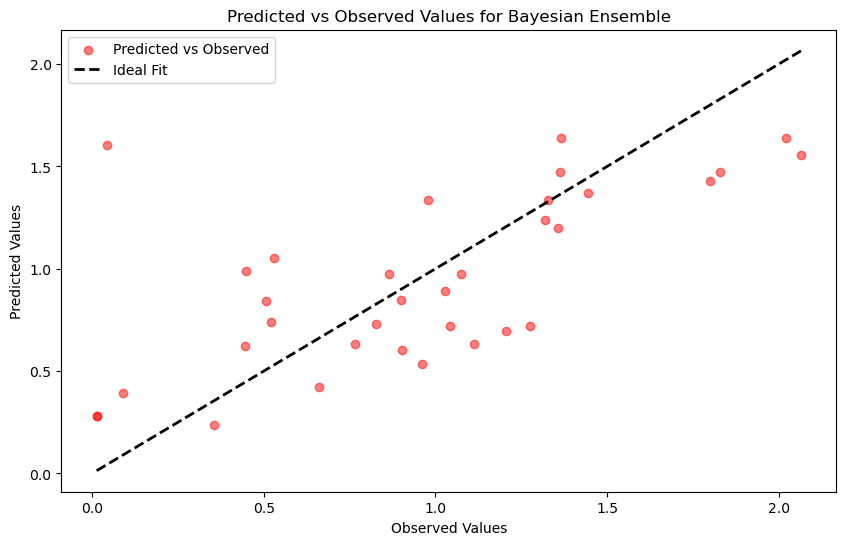

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Create synthetic data for demonstration
#X, y = make_regression(n_samples=200, n_features=5, noise=0.2)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Initialize models
models = {
    'linear_regression': LinearRegression(),
    'decision_tree': DecisionTreeRegressor(),
    'random_forest': RandomForestRegressor(),
    'gradient_boosting': GradientBoostingRegressor(),
    'knn': KNeighborsRegressor(),
    'gaussian_process': GaussianProcessRegressor(),
    'svr': SVR(),
    'kernel_ridge': KernelRidge(),
    'neural_network': MLPRegressor(max_iter=1000)
}

# Train models and compute errors
model_errors = {}
predictions = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
    model_errors[name] = mean_squared_error(y_test, y_pred)

# Compute model weights using Bayesian averaging
total_error = sum(model_errors.values())
model_weights = {name: error / total_error for name, error in model_errors.items()}
model_weights = {name: 1.0 / weight for name, weight in model_weights.items()}
weight_sum = sum(model_weights.values())
model_weights = {name: weight / weight_sum for name, weight in model_weights.items()}

# Predict with Bayesian averaging
final_prediction = np.sum([model_weights[name] * predictions[name] for name in models], axis=0)

# Output results
print("Model Weights:", model_weights)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, final_prediction, alpha=0.5, color='red', label='Predicted vs Observed')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Fit')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Observed Values for Bayesian Ensemble')
plt.legend()
plt.show()

Model Weights: {'linear_regression': 0.09337620570609355, 'decision_tree': 0.12085610668680664, 'random_forest': 0.12889176488746387, 'gradient_boosting': 0.12244380740901094, 'knn': 0.09681078311073171, 'gaussian_process': 0.12085592850766937, 'svr': 0.12430761814365605, 'kernel_ridge': 0.08023975540172681, 'neural_network': 0.11221803014684108}
R^2 score test: 0.43539045479090677


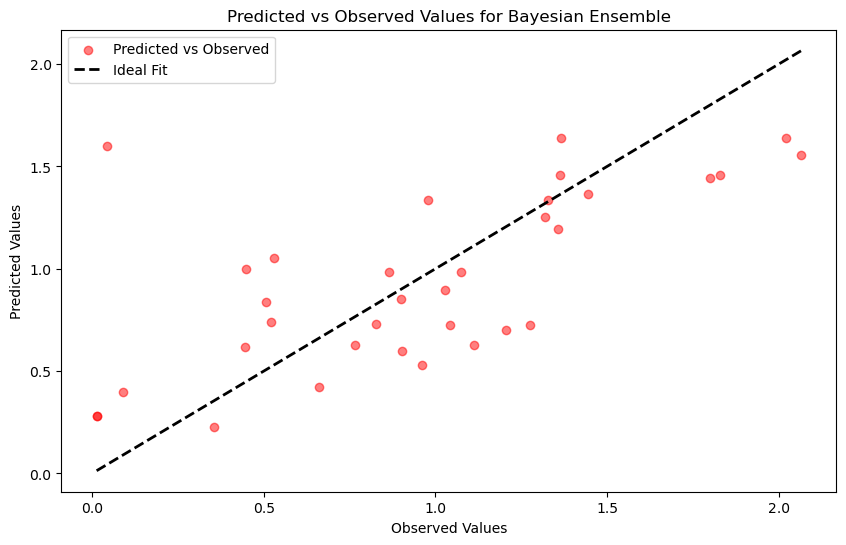

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Initialize models with explicit parameters
models = {
    'linear_regression': LinearRegression(fit_intercept=True, copy_X=True, n_jobs=None, positive=False),
    'decision_tree': DecisionTreeRegressor(criterion='squared_error', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0),
    'random_forest': RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None),#max features
    'gradient_boosting': GradientBoostingRegressor(loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, random_state=None, max_features=None, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0),
    'knn': KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None),
    'gaussian_process': GaussianProcessRegressor(kernel=None, alpha=1e-10, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=0, normalize_y=False, copy_X_train=True, random_state=None),
    'svr': SVR(kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1),
    'kernel_ridge': KernelRidge(alpha=1.0, kernel='linear', gamma=None, degree=3, coef0=1, kernel_params=None),
    'neural_network': MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=2000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-8, n_iter_no_change=10, max_fun=15000)
}

# Train models and compute errors
model_errors = {}
predictions = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
    model_errors[name] = mean_squared_error(y_test, y_pred)

# Compute model weights using Bayesian averaging
total_error = sum(model_errors.values())
model_weights = {name: error / total_error for name, error in model_errors.items()}
model_weights = {name: 1.0 / weight for name, weight in model_weights.items()}
weight_sum = sum(model_weights.values())
model_weights = {name: weight / weight_sum for name, weight in model_weights.items()}

# Predict with Bayesian averaging
final_prediction = np.sum([model_weights[name] * predictions[name] for name in models], axis=0)

r2_final = r2_score(y_test, final_prediction)

# Output results
print("Model Weights:", model_weights)

print("R^2 score test:",r2_final)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, final_prediction, alpha=0.5, color='red', label='Predicted vs Observed')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Fit')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Observed Values for Bayesian Ensemble')
plt.legend()
plt.show()

Mean Squared Error: 0.16537329844243404
R^2 Score: 0.43885402504798887


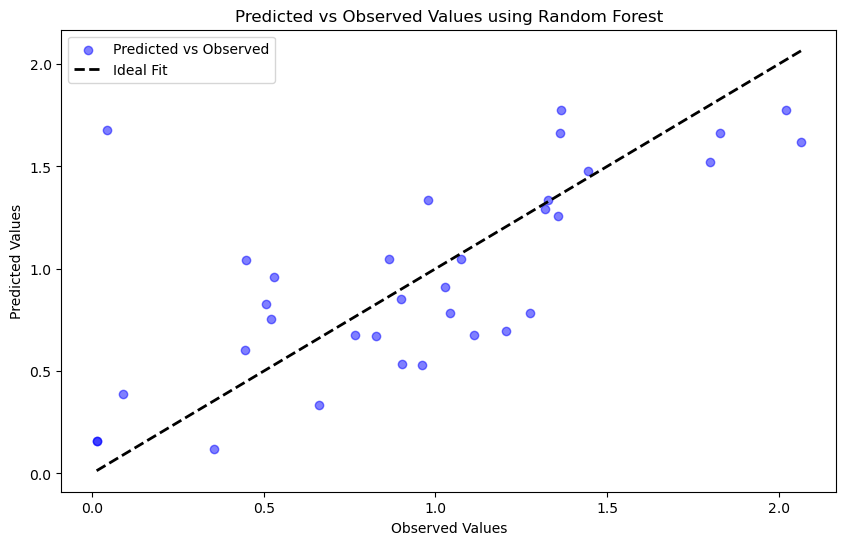

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Generate a regression dataset
#X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
random_forest = RandomForestRegressor(n_estimators=100, criterion='squared_error', random_state=42)

# Train the Random Forest model
random_forest.fit(X_train, y_train)

# Predict using the trained model
y_pred = random_forest.predict(X_test)

# Calculate mean squared error and R^2 score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output the performance metrics
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Predicted vs Observed')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Fit')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Observed Values using Random Forest')
plt.legend()
plt.show()


Model Weights: {'linear_regression': 0.09395073437321796, 'decision_tree': 0.12159971473302744, 'random_forest': 0.12768072674377462, 'gradient_boosting': 0.12319718432057408, 'knn': 0.0974064441762386, 'gaussian_process': 0.12159953545758279, 'svr': 0.12507246278073933, 'kernel_ridge': 0.08073345761818276, 'neural_network': 0.10875973979666241}
R^2 score test: 0.43539045479090677
Mean Predictions: [0.99397097 1.53731758 0.99397097 1.61918151 0.6300856  0.6300856
 0.62145333 0.99052336 1.32356481 0.72550773 1.19335043 0.41417468
 0.75162654 1.46874766 0.72483055 0.39433244 0.88709477 1.36807357
 1.43085635 1.23591824 0.70279434 1.06771221 1.59212291 0.27784174
 0.60910917 0.27784174 0.53302844 0.84733859 0.24432342 1.61918151
 1.46874766 0.72550773 0.85354042 1.32356481]
SEM Predictions: [0.03636222 0.04158103 0.03636222 0.08993809 0.02702661 0.02702661
 0.02751246 0.05057041 0.04540803 0.01864801 0.03873182 0.05017733
 0.03651223 0.13605659 0.03820687 0.01963759 0.05014524 0.05674657


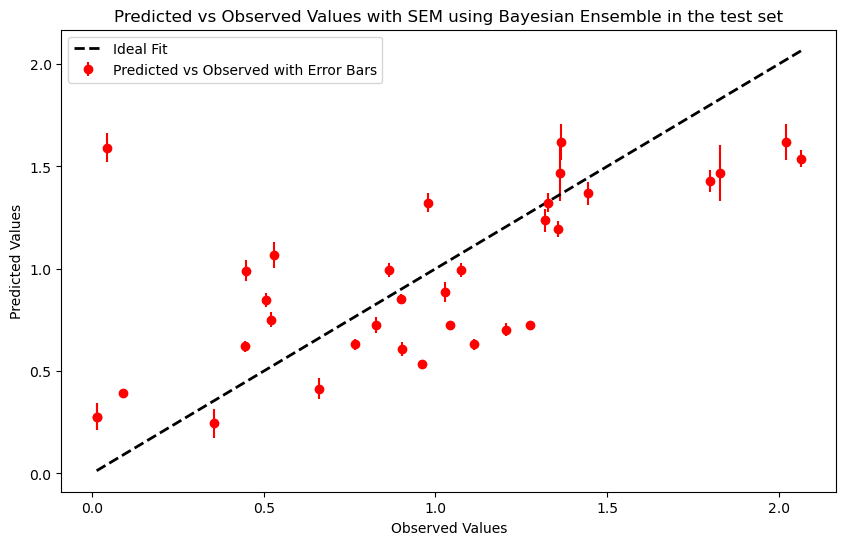

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Create synthetic data for demonstration
#X, y = make_regression(n_samples=200, n_features=5, noise=0.2)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Initialize models
models = {
    'linear_regression': LinearRegression(),
    'decision_tree': DecisionTreeRegressor(),
    'random_forest': RandomForestRegressor(),
    'gradient_boosting': GradientBoostingRegressor(),
    'knn': KNeighborsRegressor(),
    'gaussian_process': GaussianProcessRegressor(),
    'svr': SVR(),
    'kernel_ridge': KernelRidge(),
    'neural_network': MLPRegressor(max_iter=1000)
}

# Train models and compute errors
model_errors = {}
predictions = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
    model_errors[name] = mean_squared_error(y_test, y_pred)

# Compute model weights using Bayesian averaging
total_error = sum(model_errors.values())
model_weights = {name: error / total_error for name, error in model_errors.items()}
model_weights = {name: 1.0 / weight for name, weight in model_weights.items()}
weight_sum = sum(model_weights.values())
model_weights = {name: weight / weight_sum for name, weight in model_weights.items()}

# Calculate weighted mean and SEM of predictions
weighted_predictions = np.array([model_weights[name] * predictions[name] for name in models])
mean_predictions = np.sum(weighted_predictions, axis=0)

# Computing weighted variance for SEM
variance_contributions = np.array([model_weights[name] * (predictions[name] - mean_predictions)**2 for name in models])
weighted_variance = np.sum(variance_contributions, axis=0)
weighted_std = np.sqrt(weighted_variance)
sem_predictions = weighted_std / np.sqrt(len(models))

r2_final = r2_score(y_test, final_prediction)

# Output results
print("Model Weights:", model_weights)

print("R^2 score test:",r2_final)

# Output results
print("Mean Predictions:", mean_predictions)
print("SEM Predictions:", sem_predictions)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.errorbar(y_test, mean_predictions, yerr=sem_predictions, fmt='o', color='red', label='Predicted vs Observed with Error Bars')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Fit')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Observed Values with SEM using Bayesian Ensemble in the test set')
plt.legend()
plt.savefig("bayesian_emsemble_test.jpg",dpi=600, transparent="True")
plt.show()

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# Function to initialize and train models, and prepare model weights
def train_models(X_train, y_train, X_test, y_test):
    models = {
        'linear_regression': LinearRegression(),
        'decision_tree': DecisionTreeRegressor(),
        'random_forest': RandomForestRegressor(),
        'gradient_boosting': GradientBoostingRegressor(),
        'knn': KNeighborsRegressor(),
        'gaussian_process': GaussianProcessRegressor(),
        'svr': SVR(),
        'kernel_ridge': KernelRidge(),
        'neural_network': MLPRegressor(max_iter=1000)
    }
    
    model_errors = {}
    predictions = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        predictions[name] = y_pred
        model_errors[name] = mean_squared_error(y_test, y_pred)
    
    # Compute model weights using Bayesian averaging
    total_error = sum(model_errors.values())
    model_weights = {name: error / total_error for name, error in model_errors.items()}
    model_weights = {name: 1.0 / weight for name, weight in model_weights.items()}
    weight_sum = sum(model_weights.values())
    model_weights = {name: weight / weight_sum for name, weight in model_weights.items()}
    
    return models, model_weights, predictions

# Function to predict and calculate mean and SEM for new inputs
def predict_and_evaluate(models, model_weights, X_new):
    print(X_new.cpu().numpy())
    predictions = {}
    for name, model in models.items():
        predictions[name] = model.predict(X_new.cpu().numpy())
    
    weighted_predictions = np.array([model_weights[name] * predictions[name] for name in models])
    mean_predictions = np.sum(weighted_predictions, axis=0)

    # Computing weighted variance for SEM
    variance_contributions = np.array([model_weights[name] * (predictions[name] - mean_predictions)**2 for name in models])
    weighted_variance = np.sum(variance_contributions, axis=0)
    weighted_std = np.sqrt(weighted_variance)
    sem_predictions = weighted_std / np.sqrt(len(models))

    return mean_predictions, sem_predictions

# Example of using the above functions
# Create synthetic data for demonstration
#X, y = make_regression(n_samples=200, n_features=5, noise=0.2)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train models
models, model_weights, predictions = train_models(X_train, y_train, X_test, y_test)

cuda
Instance: 0
tensor([[0.1262, 0.4327, 0.2627, 0.9929, 0.1153, 0.7832, 0.0382],
        [0.0055, 0.3540, 0.7520, 0.0360, 0.4711, 0.9224, 0.9045]],
       device='cuda:0', dtype=torch.float64)
[[0.12619054 0.43270844 0.26266319 0.99288565 0.11528059 0.78318906
  0.03815359]
 [0.00545869 0.35397163 0.75195229 0.0359756  0.47111201 0.92242861
  0.90448099]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.02192682 0.46863294 0.27377601 0.9698303  0.         0.26910633
  0.00247246]
 [0.09347271 0.55516637 0.14117398 1.         0.5717359  0.66740804
  0.        ]
 [0.62556269 0.43268644 0.26729528 1.         0.19956455 0.83016546
  0.        ]
 [0.         0.1249279  0.         1.         0.         1.
  0.12200878]
 [0.         0.21665385 0.69100227 1.         0.         0.68187565
  0.        ]
 [1.         1.         0.         0.         0.         0.
  1.        ]
 [0.         0.86679218 0.26172205 1.         0.         1.
  0.04660553]
 [1.         1.         1.         0.         1.         0.
  1.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.13510759 0.40873776 0.29525317 0.72449276 0.28570916 0.66649736
  0.        ]
 [0.18655652 0.66650049 0.2895001  1.         0.30534929 0.51507175
  0.        ]
 [0.         0.38302785 0.02244081 1.         0.58324241 0.92466997
  0.        ]
 [0.         0.38503638 0.35873105 1.         0.43599603 0.51782743
  0.        ]
 [0.12823489 0.25696087 0.08921915 1.         0.29108424 0.68783692
  0.        ]
 [0.09026518 0.57241011 0.01694328 1.         0.05990224 0.67399477
  0.        ]
 [0.         0.5289175  0.11711551 1.         0.2719056  0.63947508
  0.25673724]
 [0.13875718 0.57872276 0.34839291 1.         0.38766591 0.93854696
  0.07627296]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.14979414 0.40205435 0.17348696 0.80206204 0.13292382 0.9618969
  0.        ]
 [0.12868035 0.45794127 0.20767036 0.90945582 0.2909253  0.80237376
  0.        ]
 [0.18754829 0.35687206 0.21544048 0.89922999 0.3929985  0.78720342
  0.09786976]
 [0.17967091 0.46701782 0.02859106 0.82725708 0.29474241 0.86669704
  0.03897962]
 [0.14091667 0.41371822 0.10545917 0.8429031  0.19348498 0.67010392
  0.07468227]
 [0.19633046 0.28926738 0.40315092 0.91731396 0.30186733 0.89732178
  0.        ]
 [0.19463119 0.45285334 0.09304285 1.         0.33275252 0.93799276
  0.        ]
 [0.16077719 0.28944777 0.15257585 0.83966149 0.         0.62244989
  0.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.27465874 0.28084967 0.36989466 0.94080981 0.3065438  0.56356285
  0.12943463]
 [0.30328729 0.33478755 0.06815035 0.67212898 0.18724914 0.65545324
  0.        ]
 [0.09247597 0.2486211  0.12787785 0.7795086  0.45134016 1.
  0.        ]
 [0.29098805 0.4941154  0.00190459 1.         0.32731024 0.62572265
  0.        ]
 [0.21093721 0.69495855 0.19149383 0.76251787 0.16045056 0.82952994
  0.        ]
 [0.11064583 0.52050718 0.41450311 0.70315959 0.31430304 0.95434704
  0.00488875]
 [0.29801537 0.25229224 0.17897521 0.9249478  0.45080503 0.82430153
  0.        ]
 [0.25321739 0.51618086 0.21531393 0.96558298 0.00581574 0.98557405
  0.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.22647557 0.29617464 0.27112659 0.66876793 0.55847128 0.9160234
  0.        ]
 [0.28194295 0.72339851 0.17616091 0.9123906  0.32636548 0.98461343
  0.        ]
 [0.15489932 0.26473021 0.21630208 0.72582939 0.2975658  1.
  0.1857234 ]
 [0.23778437 0.21176466 0.05345779 0.91629292 0.13335576 1.
  0.        ]
 [0.12402138 0.2643781  0.34258195 0.51167472 0.23470995 0.94108926
  0.        ]
 [0.20357366 0.55327149 0.26325599 0.60781481 0.65086834 0.91809274
  0.        ]
 [0.15365699 0.64443669 0.09011803 0.58089195 0.5133518  0.68639138
  0.        ]
 [0.         0.55799705 0.         0.75376924 0.43639131 1.
  0.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.27216913 0.39886176 0.25923513 0.9631428  0.63401655 0.87983477
  0.15964323]
 [0.33777714 0.48108107 0.5197509  0.56551327 0.39763055 1.
  0.        ]
 [0.1398002  0.         0.33167922 0.74961695 0.55874775 1.
  0.21137612]
 [0.05192606 0.12701835 0.3706964  0.78900667 0.41117225 1.
  0.        ]
 [0.16132091 0.46538035 0.30137531 0.6823038  0.25320684 0.86671262
  0.1551514 ]
 [0.28450806 0.15032232 0.1977078  0.56867261 0.34266743 1.
  0.03381694]
 [0.26839345 0.40020256 0.41605451 0.65102713 0.03986966 0.9603371
  0.06776204]
 [0.26302702 0.2158149  0.53311345 0.73410568 0.54766754 0.71051311
  0.03529737]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.2064991  0.19663025 0.51621189 0.5557609  0.57704725 1.
  0.1609976 ]
 [0.12240794 0.14761925 0.34192578 0.64903947 0.42675782 0.72793245
  0.17249231]
 [0.11843918 0.         0.18445843 0.70031177 0.3535631  0.86509534
  0.03578342]
 [0.24062186 0.03439942 0.46995422 0.68129636 0.15073772 1.
  0.        ]
 [0.11019773 0.35440161 0.42239605 0.95580299 0.66449179 1.
  0.        ]
 [0.18442017 0.17703587 0.36929614 1.         0.24294854 1.
  0.15272973]
 [0.01501131 0.06226049 0.45480308 0.67779899 0.32402694 1.
  0.18644677]
 [0.27066009 0.33921885 0.07849719 0.76079572 0.48866474 1.
  0.19084672]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.23790051 0.         0.20388218 0.47854389 0.62634935 0.74530546
  0.15807443]
 [0.1823139  0.04796218 0.         0.73441215 0.55550804 0.62658161
  0.        ]
 [0.3404263  0.29591957 0.41513397 0.43805201 0.09558739 0.69241287
  0.03142992]
 [0.03304847 0.16109434 0.09987325 0.78761637 0.64819859 0.87093905
  0.24507346]
 [0.16059462 0.55313208 0.45476742 0.72893439 0.27882369 0.99978048
  0.35518071]
 [0.24589651 0.04463181 0.4145026  0.83696541 0.63028391 1.
  0.        ]
 [0.26992867 0.         0.54979009 0.54905757 0.40385104 0.74972784
  0.        ]
 [0.17262126 0.08619207 0.25364924 0.84510962 0.37406447 0.86167685
  0.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.19217721 0.32545177 0.04961772 0.6160653  0.94324671 0.95516652
  0.        ]
 [0.13934406 0.28746676 0.71980977 0.60822966 0.36507023 1.
  0.04508792]
 [0.05621955 0.         0.25342299 0.94616076 0.56153716 1.
  0.        ]
 [0.11322246 0.02573572 0.3988224  0.93734634 0.01108155 0.8746523
  0.        ]
 [0.25126059 0.         0.28921608 0.80118888 0.59773922 1.
  0.31562265]
 [0.04775103 0.05876266 0.42910751 0.55238007 0.24895254 0.56035476
  0.        ]
 [0.03733418 0.05341117 0.45117082 0.64749215 0.68603085 0.97383245
  0.        ]
 [0.11084996 0.12512899 0.36385868 0.92754179 0.57008766 0.77947782
  0.2063231 ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[2.01084933e-01 0.00000000e+00 7.04632124e-02 9.79245383e-01
  5.05867943e-01 1.00000000e+00 8.95254561e-02]
 [1.24092917e-01 4.05101368e-01 8.14087789e-01 8.89632413e-01
  5.45443400e-01 1.00000000e+00 0.00000000e+00]
 [2.08313469e-01 2.41562507e-01 2.59267629e-01 7.67004167e-01
  9.20989698e-02 7.19872939e-01 3.97344831e-01]
 [1.54377959e-01 5.55277390e-01 0.00000000e+00 7.32648703e-01
  5.98381874e-01 7.56963176e-01 3.47770833e-01]
 [0.00000000e+00 4.98343508e-01 5.32496526e-06 4.09046876e-01
  0.00000000e+00 5.76247051e-01 0.00000000e+00]
 [1.56203212e-01 2.22905813e-01 0.00000000e+00 8.31141007e-01
  8.27500197e-01 5.66536664e-01 3.17807318e-01]
 [2.58146309e-02 1.07831084e-01 2.86428387e-01 3.75513529e-01
  4.83987255e-01 6.20791823e-01 2.97119847e-02]
 [2.07211360e-01 2.60705761e-01 7.03808656e-02 1.00000000e+00
  1.00000000e+00 6.73654312e-01 4.37269472e-01]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.15438374 0.10281144 0.87698725 1.         0.36311858 0.93793761
  0.        ]
 [0.13457426 0.32746588 0.58207462 0.78463726 0.12886935 1.
  0.        ]
 [0.08836447 0.19153915 0.44429023 0.82002799 0.81387332 0.85127469
  0.06652107]
 [0.21399402 0.         0.16104408 1.         0.80573248 0.70961261
  0.03424739]
 [0.04167337 0.44827317 0.65069979 0.88177895 0.70819909 0.90417823
  0.20563127]
 [0.1990728  0.85552685 0.46775888 1.         0.4179958  1.
  0.23118878]
 [0.18498448 0.         0.08596159 0.96155036 0.45705063 0.50140851
  0.22308994]
 [0.00768565 0.4364984  0.67376901 0.6620805  0.73311716 0.74268757
  0.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.18638608 0.35205119 0.6496764  1.         0.39381777 0.94379494
  0.30095236]
 [0.02368484 0.32187707 0.36654376 0.92253225 0.08593306 0.9837109
  0.20967802]
 [0.32972121 0.         0.40554314 0.96049705 0.75937596 1.
  0.05354745]
 [0.35954987 0.         0.2110368  1.         0.45680865 1.
  0.        ]
 [0.21833543 0.         0.71647705 0.81450124 0.5870022  0.74241048
  0.21222994]
 [0.23598379 0.74103932 0.46072768 1.         0.75172489 1.
  0.        ]
 [0.35303267 0.45603054 0.7594946  0.74308618 0.69385358 0.89763595
  0.024519  ]
 [0.45162655 0.         0.21042024 0.75679719 0.50579427 1.
  0.11190598]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.1739877  0.         0.01817853 0.62331803 0.2847719  1.
  0.03777732]
 [0.21000541 0.04014238 0.37162446 0.93866152 0.25099103 0.96050517
  0.43717662]
 [0.15100969 0.20416628 0.59958609 0.83007505 0.56419052 0.78622286
  0.        ]
 [0.15822159 0.         0.22728363 0.37979078 0.06329112 0.28453702
  0.36702531]
 [0.15426168 0.26189611 0.71502009 0.4133258  0.58031215 0.71954071
  0.        ]
 [0.30920962 0.59712226 0.36719014 0.34112004 1.         0.76097726
  0.        ]
 [0.25529231 0.42536078 0.49018839 0.20634173 0.8222371  0.63741256
  0.        ]
 [0.18387254 0.13132713 0.94323323 0.56433247 0.61014508 0.77800666
  0.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.94307764 0.84288383 0.51542718 0.74382682 0.58371971 0.75788403
  0.9390171 ]
 [0.16477685 0.40963816 0.28459598 1.         0.94515054 0.79518367
  0.        ]
 [0.10744849 0.         0.58202955 0.85854777 0.42727133 0.8790168
  0.1093544 ]
 [0.2535336  0.         0.30853356 0.705702   0.41776608 0.80338794
  0.23708464]
 [0.07789366 0.         0.46005841 0.87505745 0.76331878 1.
  0.        ]
 [0.26497577 0.         0.20006045 1.         0.68351177 0.91519143
  0.38742863]
 [0.2302525  0.05860283 0.89354979 0.71098303 0.08724391 1.
  0.33998544]
 [0.43920928 0.         0.15243912 0.33648685 0.31337911 0.57186244
  0.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.13601706 0.         0.48451327 1.         0.65368754 1.
  0.17719702]
 [0.         0.         0.20767292 0.52548887 0.         0.65078544
  0.14311226]
 [0.10647757 0.7836318  0.00577363 0.75826359 0.87564982 0.00710076
  0.34107631]
 [0.47212904 0.6032507  0.49213729 1.         0.96184777 1.
  0.        ]
 [0.13538728 0.10087867 0.54204822 1.         0.23568353 0.66510931
  0.15544224]
 [0.18570063 0.03620558 0.45364296 0.99814096 0.38375773 0.81992482
  0.        ]
 [0.04166638 0.33408287 1.         0.90550462 0.34111899 1.
  0.35620423]
 [0.03909151 0.01712463 1.         0.78911987 0.00319066 0.38870936
  0.26377464]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.01534642 0.10425326 0.48532372 1.         0.52836659 1.
  0.05433566]
 [0.16129095 0.49903426 0.24848438 0.95965268 0.14035533 0.75408528
  0.42350323]
 [0.15187178 0.21126355 0.48120833 0.85825215 0.51712996 0.93693735
  0.19848387]
 [0.16712079 0.22751897 0.43552656 0.8553717  0.49677429 1.
  0.        ]
 [0.08665597 0.07255247 0.90507864 0.94091029 0.75121491 0.85757982
  0.14104476]
 [0.50564196 0.24112894 0.246571   1.         1.         0.16465586
  0.28824901]
 [0.14303711 0.18739892 0.49714063 0.68298568 0.60161896 0.95535932
  0.33088707]
 [0.70141564 0.86877381 0.68845723 0.57563094 0.79814604 0.06392438
  0.10953371]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.59948135 0.65113594 0.54534076 0.44883051 0.54210862 0.70251404
  0.91173421]
 [0.159705   0.         0.         0.86838105 0.7221007  1.
  0.23361951]
 [0.41458067 0.03459244 0.77898851 0.00610855 0.98965485 0.71419463
  0.47408333]
 [0.75295468 0.82557034 0.65809928 0.12188384 0.25200658 0.53690215
  0.88402798]
 [0.50609372 0.87378686 0.5606037  0.05677567 0.07799038 0.31398187
  0.45807535]
 [0.81185221 0.7739205  0.76476344 0.9418529  0.4907891  0.69847161
  0.935593  ]
 [0.9932383  0.29417705 0.82599573 0.6690794  0.69349659 0.15600273
  0.21402377]
 [0.28713143 0.12100409 0.05510952 0.27849106 0.83706232 0.37235874
  0.8361158 ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[5.40368306e-01 4.06397533e-01 2.94082183e-01 6.07408492e-01
  7.10002591e-01 6.62280896e-01 8.45844157e-04]
 [7.82664050e-02 1.44051838e-01 3.91329417e-01 9.99029459e-01
  3.91215462e-01 1.00000000e+00 4.47212296e-04]
 [3.21146886e-01 6.96942867e-01 9.38876394e-01 1.22609157e-02
  1.38636286e-01 7.45180827e-02 6.64724382e-01]
 [6.48917987e-01 3.22300423e-01 6.07981853e-01 7.07191057e-01
  6.02203254e-01 1.67435002e-01 7.86187592e-01]
 [1.47881304e-01 6.25660913e-02 6.69593531e-01 3.33860547e-01
  8.57912713e-01 1.60912708e-01 4.72279198e-01]
 [2.80639508e-01 4.85049008e-01 3.13703383e-01 1.45088742e-01
  2.71058554e-01 9.50181266e-01 3.49624126e-01]
 [9.64055352e-01 5.32032483e-01 9.38624556e-01 7.14005841e-01
  8.39664594e-01 3.78375407e-01 9.25088504e-01]
 [1.27047129e-01 8.70225090e-01 5.69572914e-02 9.42436690e-01
  5.40062107e-01 1.79517264e-01 8.53011116e-01]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.848282   0.11917028 0.2086501  0.39592141 0.79322613 0.37291048
  0.36328485]
 [0.         0.57877831 0.46438263 0.79198322 0.5725943  0.58908274
  0.58451702]
 [0.51381273 0.95723704 0.53824656 0.67165309 0.62571644 0.83656585
  0.34874282]
 [0.08718287 0.08389378 0.34924515 0.90813037 0.49843426 1.
  0.        ]
 [0.86371229 0.45855219 0.7620706  0.85089767 0.48267831 0.94474184
  0.09167304]
 [0.02125221 0.64373728 0.86646214 0.06155441 0.01620643 0.26331412
  0.15249132]
 [0.22593317 0.88985565 0.63849393 0.34552689 0.20590288 0.0202613
  0.54150983]
 [0.30224221 0.70117725 0.06950057 0.36276948 0.60144877 0.10423812
  0.23700444]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.05693363 0.3089269  0.48292283 0.98526618 0.21605678 1.
  0.21390774]
 [0.25807746 0.76146581 0.24467704 0.88078664 0.547952   0.66467381
  0.64502331]
 [0.08715908 0.58313378 0.16968112 0.9939797  0.50652443 0.75903713
  0.58449659]
 [0.75542111 0.4897915  0.95552784 0.6169775  0.38087442 0.00286175
  0.94268232]
 [0.90036524 0.69131905 0.12153649 0.18203945 0.04152319 0.85508515
  0.449868  ]
 [0.76859633 0.94534539 0.33847481 0.21258759 0.60638866 0.00872912
  0.64736189]
 [0.54750528 0.7160485  0.0576686  0.93541917 0.72674033 0.40978011
  0.5530498 ]
 [0.98556681 0.8208666  0.69982222 0.20504189 0.26195062 0.51176809
  0.82591111]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

Best observed point: [0.05621955 0.         0.25342299 0.94616076 0.56153716 1.
 0.        ] Best observed value: 1.8404861101169896
Instance: 1
tensor([[8.6360e-04, 3.5201e-01, 5.8571e-01, 5.9333e-01, 3.1573e-01, 4.3558e-01,
         4.8397e-01],
        [9.7900e-01, 6.8053e-01, 6.8016e-02, 7.4338e-01, 3.0254e-01, 6.6712e-01,
         6.0323e-01]], device='cuda:0', dtype=torch.float64)
[[8.63603316e-04 3.52005988e-01 5.85710466e-01 5.93334258e-01
  3.15732569e-01 4.35575455e-01 4.83970284e-01]
 [9.78996575e-01 6.80534959e-01 6.80157319e-02 7.43380606e-01
  3.02543223e-01 6.67123616e-01 6.03225768e-01]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  5.74662888e-01 0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.16260100e-01 8.82980200e-01
  0.00000000e+00 3.92782429e-01 1.67604506e-01]
 [0.00000000e+00 2.14187753e-01 9.98180129e-01 5.73786330e-02
  2.78082091e-06 3.96484780e-01 3.37803941e-01]
 [0.00000000e+00 1.00000000e+00 5.83451529e-01 7.70740194e-01
  9.50363878e-06 0.00000000e+00 3.27840730e-01]
 [0.00000000e+00 5.29890834e-01 4.81602737e-01 4.55104510e-01
  9.20228100e-01 5.82058052e-01 1.62536909e-01]
 [0.00000000e+00 3.16036613e-01 7.79279286e-01 8.95051707e-01
  2.63861389e-01 7.87449949e-01 9.99934020e-01]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 0.00000000e+00 4.49224885e-01]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 1.00000000e+00]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.         0.22107453 0.80300825 0.85407798 0.26852063 0.4941909
  0.83008395]
 [0.         0.06499091 0.30051197 0.88967451 0.01530591 0.49255453
  0.43648078]
 [0.         0.12362577 0.25527938 0.69764108 0.21011453 0.38803989
  0.17878708]
 [0.         0.39468853 0.55238583 0.6857184  0.19817492 0.83540025
  0.83243105]
 [0.         0.         0.         0.94607924 0.         0.14979526
  0.18557109]
 [0.         0.         0.16769603 0.91721299 0.         0.65022193
  0.03975119]
 [0.         0.17689804 0.68297379 0.80848583 0.64402142 0.35703196
  0.43421516]
 [0.         0.37611836 0.73926191 0.78200805 0.53529307 0.71851776
  0.73023186]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.14645409 0.         0.16838132 0.84483    0.12301154 0.69582773
  0.01776505]
 [0.         0.02269579 0.37501534 1.         0.         0.63507838
  0.        ]
 [0.         0.         0.34108747 0.74612563 0.04942585 0.67571703
  0.        ]
 [0.         0.038197   0.01196327 0.92033636 0.21931276 0.73383036
  0.10080028]
 [0.         0.18664764 0.15276232 0.93752635 0.03523886 0.65484001
  0.        ]
 [0.         0.12016634 0.32784121 0.83440322 0.26097181 0.80916285
  0.14691971]
 [0.         0.01010094 0.06860536 0.73038772 0.         0.72572447
  0.        ]
 [0.         0.         0.27097111 0.95628728 0.31761763 0.60065594
  0.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.24296941 0.12870248 0.43564768 0.47822325 0.16029396 0.17764673
  0.639207  ]
 [0.77534959 0.79352841 0.48241494 0.76010285 0.         0.76730164
  0.74916478]
 [1.         0.99870755 0.47960211 0.943442   0.16601214 0.22335062
  0.37951715]
 [0.16778526 0.         0.20851632 0.86545027 0.15023324 0.84306143
  0.        ]
 [0.41609582 0.89709032 0.66892346 0.49080321 0.559041   0.04502447
  0.13710278]
 [0.1654662  0.00479693 0.20522352 0.79073198 0.28148106 0.70050543
  0.        ]
 [0.29640915 0.63751769 0.54218551 0.55352842 0.71948249 0.10962643
  0.29915026]
 [0.02521936 0.74242951 0.02909013 0.26887581 0.09077552 0.25235596
  0.87669349]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.03684313 0.43592537 0.96525891 0.60540362 0.88878779 0.98642259
  0.99999118]
 [0.20284406 0.         0.15014659 0.78970323 0.11748863 0.8336194
  0.        ]
 [0.43583068 0.78239294 0.62302005 1.         0.16278237 0.66480102
  0.31715064]
 [0.20389567 0.         0.19998242 0.94839205 0.19426358 0.78910886
  0.        ]
 [0.74527278 0.24358688 0.84818783 0.95666956 0.91152165 0.51820887
  0.83474294]
 [0.9217046  0.32123916 0.89686635 0.86934557 0.07085978 0.48127868
  0.87152115]
 [0.39117651 0.29401363 0.41563706 0.97887727 0.21097546 0.51372962
  0.95066472]
 [0.23205949 0.09948578 0.95824498 0.46167055 0.13690558 0.01062324
  0.81187171]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[9.35760258e-01 6.89496855e-01 9.28229491e-01 4.31007516e-01
  4.98853140e-01 4.16221042e-01 5.19216826e-01]
 [7.01912461e-01 4.54927968e-01 8.96408763e-01 3.78670395e-01
  6.54316871e-05 6.28526888e-01 5.16291231e-01]
 [2.01009492e-01 3.47334945e-01 7.57185668e-01 2.19189642e-01
  1.25112260e-01 9.10482872e-01 3.22725178e-01]
 [2.96188400e-01 5.10547204e-01 9.26089751e-01 9.69532584e-01
  2.18066343e-01 7.42997752e-01 1.83484434e-01]
 [1.84755276e-01 0.00000000e+00 3.38090790e-01 8.87140634e-01
  1.85248712e-01 8.04765774e-01 1.64126100e-02]
 [8.61036849e-01 6.62467586e-01 4.29332858e-01 5.71215282e-01
  9.03467340e-02 9.07289808e-01 5.32813685e-01]
 [1.85420768e-01 1.77433467e-01 3.27439862e-01 6.17630303e-01
  6.75085920e-01 4.69313904e-01 4.99316377e-01]
 [8.74674404e-02 2.77344171e-01 5.86525464e-01 1.68591044e-01
  7.81342465e-01 7.17211333e-01 6.47683719e-01]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.20233411 0.16678622 0.53279635 0.98833269 0.18342695 1.
  0.        ]
 [0.20107054 0.20878765 0.34894452 0.89178224 0.33945027 0.87866708
  0.20734049]
 [0.18396519 0.         0.27744343 0.90958808 0.26098833 0.84547344
  0.20804975]
 [0.18439981 0.1734437  0.33383134 0.90895058 0.19132865 0.81593294
  0.01692464]
 [0.31065711 0.02586289 0.84879074 0.46335757 0.41253567 0.55265523
  0.71957906]
 [0.21981502 0.34347076 0.54574    0.67776375 0.00398267 0.00573178
  0.52561962]
 [0.22572553 0.09553037 0.60596809 0.82728407 0.62247188 0.91172742
  0.35713792]
 [0.06707313 0.66537165 0.50591433 0.63894401 0.75624029 0.0092349
  0.08223623]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.21195374 0.84173618 0.60309186 0.81107092 0.44062095 0.69805064
  0.44446726]
 [0.36732504 0.49002987 0.8773571  0.77248444 0.17397418 0.1200924
  0.90969989]
 [0.04070727 0.52222975 0.67109428 0.21814225 0.57214158 0.76004721
  0.95545051]
 [0.64485715 0.69682878 0.74959295 0.17212123 0.85568022 0.68872093
  0.47269804]
 [0.24240733 0.6123508  0.4902832  0.82429204 0.3863051  0.76837238
  0.49681693]
 [0.36561958 0.36823372 0.42700864 0.18419732 0.11588509 0.3747648
  0.73418386]
 [0.17768328 0.10233228 0.40100573 0.94673173 0.23716459 0.98259708
  0.05707623]
 [0.68862075 0.28444776 0.15939264 0.19702688 0.20355245 0.02322903
  0.46071482]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.14907432 0.15934104 0.623457   0.71156142 1.         1.
  0.85976288]
 [0.19970122 0.61394294 0.18358138 0.         0.12741774 0.51945833
  0.06149176]
 [0.17219246 0.08750571 0.40797175 1.         0.39110066 1.
  0.        ]
 [0.89203717 0.87574168 0.7711917  0.32543014 0.60462299 0.66956841
  0.32907717]
 [0.14922843 0.09960169 0.40466606 0.74514165 0.42749535 1.
  0.17397396]
 [0.16642202 0.14016128 0.59414657 0.88208794 0.20547222 1.
  0.13141739]
 [0.31337554 0.97197691 0.32971806 0.4804516  0.18394273 0.65229733
  0.74292239]
 [0.0013369  0.56760289 0.81785905 0.85403946 0.75598994 0.70922687
  0.12214705]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.91197507 0.02005435 0.05665092 0.84493092 0.0686296  0.70200589
  0.28099687]
 [0.14852273 0.         0.42169808 0.86755418 0.52288417 1.
  0.        ]
 [0.25030931 0.1380956  0.72365667 0.79100598 0.60723929 0.86599652
  0.43831809]
 [0.78415969 0.06311189 0.88824874 0.20336482 0.40837849 0.4846302
  0.1088705 ]
 [0.14234403 0.06724466 0.31039949 0.94617588 0.57343583 1.
  0.17853467]
 [0.1656738  0.12892986 0.26477251 0.92213919 0.40744056 1.
  0.        ]
 [0.20922809 0.14531021 0.71659662 0.75900371 0.56162173 0.58630727
  0.44738946]
 [0.14993016 0.07203285 0.15869752 0.77806378 0.74800181 1.
  0.29040229]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.71786259 0.76694798 0.6836622  0.61603799 0.14297402 0.42012034
  0.1564642 ]
 [0.13761879 0.04327303 0.3336682  0.9175536  0.49234602 1.
  0.        ]
 [0.54319769 0.01485375 0.91185222 0.51272436 0.98703617 0.06959177
  0.83489516]
 [0.90679685 0.00311544 0.66978067 0.89254093 0.07982582 0.22272886
  0.30774888]
 [0.58571765 0.92392754 0.61085533 0.63159114 0.92671699 0.81745581
  0.08927899]
 [0.25605267 0.14576142 0.89581623 0.14650174 0.39722037 0.77509979
  0.82285912]
 [0.31478848 0.35473586 0.64002916 0.60068263 0.76775475 0.46067848
  0.89480424]
 [0.54668443 0.2030547  0.17151721 0.72547737 0.46634642 0.52789681
  0.52993813]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.06693232 0.21381474 0.50665094 0.1002095  0.64614878 0.62593983
  0.61806897]
 [1.         0.76279843 0.74920842 0.29191471 0.40445402 0.7937285
  0.02962562]
 [0.13749716 0.         1.         1.         1.         1.
  1.        ]
 [0.34244408 0.34293104 0.14540982 0.95501657 0.70565208 0.21461651
  0.92651204]
 [0.19988729 0.68698518 0.77213196 0.54141439 0.68998345 1.
  0.4186269 ]
 [0.14743456 0.12165317 0.41610989 0.89101927 0.55930855 1.
  0.        ]
 [0.16488452 0.01550128 0.94678022 0.7338436  0.70192106 0.51724284
  0.01331296]
 [0.16972861 0.3483169  0.92091427 0.87461525 0.69113271 0.41603791
  0.56625031]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.50500864 0.70089336 0.97261011 0.29412893 0.59539273 0.92312159
  0.71779027]
 [0.15237696 0.         0.33157506 1.         0.57062507 1.
  0.        ]
 [0.95992992 0.8616418  0.08822105 0.27833557 0.9730706  0.58285079
  0.58851919]
 [0.61733628 0.54308176 0.97190672 0.16461094 0.16798317 0.40416138
  0.09885657]
 [0.1041735  0.15482099 0.24731397 0.62103699 0.55898359 0.69615153
  0.46565853]
 [0.00271189 0.37989718 0.78173836 0.10560906 0.52861953 0.62058395
  0.32792579]
 [0.38506308 0.37538765 0.07918925 0.91251364 0.76198844 0.30007899
  0.68316927]
 [0.2689501  0.69720066 0.45882913 0.8637655  0.94348676 0.42493997
  0.96508912]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.78058205 0.76592599 0.47040628 0.00393943 0.99818995 0.70283539
  0.25314865]
 [0.53221381 0.30930839 0.56966104 0.12623163 0.97449227 0.77041684
  0.52412953]
 [0.88534197 0.28769002 0.28768052 0.68204855 0.85733669 0.40019796
  0.63652026]
 [0.17440039 0.05536282 0.88676968 0.67722801 0.67566693 0.47150561
  0.01422121]
 [0.21846251 0.53491491 0.         0.67930385 0.21026076 0.5880495
  0.36283012]
 [0.13400608 0.         0.56704839 0.99806336 0.64764431 1.
  0.        ]
 [0.78160907 0.01607178 0.75742616 0.66653857 0.06052482 0.51255282
  0.63957728]
 [0.9094226  0.63890073 0.80491852 0.56178946 0.36681782 0.69217092
  0.2620395 ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.92050812 0.15361963 0.40261931 0.3547153  0.97617209 0.88115463
  0.3464367 ]
 [0.12107008 0.         0.28699207 0.87630642 0.72983746 1.
  1.        ]
 [0.60818255 0.92092517 0.19263505 0.05798518 0.25196254 0.30002214
  0.83727183]
 [0.41883805 0.19773162 0.76729038 0.36672736 0.82466779 0.296807
  0.30104491]
 [0.56700279 0.79562866 0.64765995 0.94455512 0.64104279 0.9054442
  0.11759933]
 [0.04710292 0.01675399 0.30940434 0.39447861 0.25773829 0.07918583
  0.13345755]
 [0.2105053  0.60997923 0.20135173 0.719434   0.65475118 0.30372777
  0.11946089]
 [0.64417106 0.00505604 0.39735796 0.29036968 0.22072592 0.74502026
  0.00211619]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.8528204  0.98212756 0.91883742 0.89695048 0.53504447 0.35393129
  0.80738137]
 [0.64834344 0.0301366  0.66683651 0.81208769 0.38783185 0.15141233
  0.82021259]
 [0.65470466 0.95186506 0.92233697 0.06877626 0.77927183 0.63744038
  0.17771434]
 [0.9869935  0.41199275 0.38599894 0.53819802 0.95478947 0.78899358
  0.21500706]
 [0.51840419 0.21818987 0.60948261 0.12217336 0.62873553 0.36727619
  0.85865922]
 [0.25659538 0.77290182 0.63889882 0.21800532 0.88217528 0.76694586
  0.9504075 ]
 [0.97164444 0.34644807 0.84423665 0.18762584 0.42256086 0.94963559
  0.14348662]
 [0.84791683 0.87009189 0.89793198 0.47639812 0.87151891 0.28134132
  0.25192669]]
[[0.56183507 0.39254174 0.04937057 0.05711455 0.75413827 0.90411428
  0.82991813]
 [0.15941177 0.69070132 0.3004653  0.06786474 0.52003052 0.19878509
  0.97138729]
 [0.83867042 0.8444876  0.14470742 0.92178968 0.70171279 0.3788217
  0.63320273]
 [0.33465695 0.29849056 0.48257401 0.31035184 0.38682223 0.37656961
  0.54241381]
 [0.86028838 0.5

/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.51890648 0.60368133 0.55712796 0.43689326 0.36711197 0.38087722
  0.59532145]
 [0.51590028 0.84270353 0.92496778 0.85467041 0.17607251 0.7317136
  0.82935866]
 [0.93337684 0.3386163  0.92689603 0.32720874 0.19812378 0.74323815
  0.97764775]
 [1.         0.14452964 0.90606135 0.44900215 0.77067023 0.24883128
  0.72922527]
 [0.40581355 0.3231623  0.44608378 0.95701192 0.19296916 0.47420841
  0.90083843]
 [0.30832797 0.42676326 0.25284071 0.31749276 0.23849668 0.12327065
  0.40568617]
 [0.96035894 0.66558868 0.71963078 0.23505309 0.68939682 0.91628193
  0.53813966]
 [0.06778489 0.         0.33562024 0.96378608 1.         1.
  1.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.11383428 0.04060589 0.82185553 0.61075321 0.91334698 0.95314921
  0.71239571]
 [0.09566321 0.         0.32350647 1.         0.88976355 1.
  0.8017295 ]
 [0.39122787 0.41279799 0.10828001 0.98076849 0.71845793 0.26437516
  0.72500128]
 [0.03083042 0.64007165 0.85658079 0.86823018 0.34369335 0.63896841
  0.32844718]
 [0.25253879 0.11351732 0.86067939 0.85931808 0.57822541 0.81647215
  0.37326257]
 [0.0713776  0.         0.09915781 0.76850617 0.99705525 1.
  1.        ]
 [0.80754602 0.1622472  0.60963546 0.45705454 0.25046861 0.38366097
  0.23355112]
 [0.99975277 0.65369353 0.91234921 0.54387538 0.30877506 0.48556765
  0.82053725]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.11545459 0.07724304 0.28613607 0.15757356 0.1266143  0.77802757
  0.27900408]
 [0.20707331 0.13602558 0.38092643 0.20110028 0.01949275 0.43842737
  0.46737912]
 [0.81792039 0.53366004 0.54346568 0.30466018 0.52034566 0.68843445
  0.54425135]
 [0.26511481 0.91559828 0.50556686 0.61276795 0.0064821  0.26160672
  0.3671577 ]
 [0.42736821 0.96263082 0.81982253 0.91024663 0.55531746 0.02851698
  0.88014832]
 [0.14871899 0.         0.21039081 0.9342767  0.50583976 1.
  0.03557669]
 [0.71339133 0.4143856  0.66894577 0.3324562  0.58312437 0.55323926
  0.20937699]
 [0.41925349 0.6475579  0.5036577  0.25286081 0.68114215 0.65334277
  0.1039859 ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

Best observed point: [0.14871899 0.         0.21039081 0.9342767  0.50583976 1.
 0.03557669] Best observed value: 1.799948127424229
Instance: 2
tensor([[0.7413, 0.0158, 0.1317, 0.6272, 0.0093, 0.9151, 0.6264],
        [0.5650, 0.1793, 0.8055, 0.0755, 0.7479, 0.1705, 0.2079]],
       device='cuda:0', dtype=torch.float64)
[[0.74125713 0.01583498 0.13168429 0.62722033 0.00930447 0.91512871
  0.62640142]
 [0.56503272 0.17928305 0.80553466 0.07551031 0.74788898 0.17048757
  0.20785804]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.47448476 0.71393203 1.         0.         1.         0.51414922
  0.        ]
 [0.         1.         1.         1.         0.         1.
  0.        ]
 [0.00797939 0.         1.         0.         0.         0.
  0.        ]
 [0.         1.         1.         0.         0.         1.
  1.        ]
 [1.         1.         0.         0.         0.         0.
  1.        ]
 [1.         1.         0.         1.         1.         1.
  1.        ]
 [1.         0.         0.21876773 0.         0.69136336 0.
  0.        ]
 [0.45046535 0.         1.         0.28787038 1.         0.
  0.89024192]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.66385653 0.03512696 1.         0.41203491 0.87387564 0.0644436
  0.56394077]
 [0.15711896 0.         0.95381181 0.0467648  1.         0.
  1.        ]
 [0.         1.         1.         1.         0.39008373 1.
  0.        ]
 [0.         1.         1.         1.         0.         0.58264176
  0.        ]
 [1.         1.         0.         1.         1.         1.
  0.50212777]
 [0.         1.         0.40041931 1.         0.         1.
  0.        ]
 [0.85945639 0.         1.         0.69996545 1.         0.
  0.83559811]
 [0.         1.         1.         0.56926613 0.         1.
  0.58223807]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.         1.         1.         0.6858935  0.08501493 1.
  0.01593891]
 [0.         1.         0.66331558 1.         0.         1.
  0.34243649]
 [0.         1.         1.         1.         0.06506607 1.
  0.38504768]
 [0.         1.         0.77470613 0.81452254 0.19534305 1.
  0.26347552]
 [0.4197362  0.         1.         0.8929562  1.         0.
  1.        ]
 [0.2631037  1.         0.74893748 1.         0.0233806  1.
  0.00673547]
 [0.         1.         0.68844247 0.74069408 0.         1.
  0.03790712]
 [0.         1.         0.69919489 1.         0.15222399 0.91148979
  0.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.34366566 1.         0.82581088 1.         0.16580109 1.
  0.        ]
 [0.68746734 0.03368165 0.03952811 0.05331976 0.99051754 0.55502483
  0.76514702]
 [0.34066119 1.         0.55302339 1.         0.         1.
  0.        ]
 [0.4139188  1.         0.63051557 0.9648746  0.10190058 1.
  0.15536576]
 [0.3450385  1.         0.99592575 1.         0.         1.
  0.        ]
 [0.29157109 0.88432678 0.74741133 0.98834154 0.         1.
  0.        ]
 [0.31177767 1.         0.78491451 0.79106428 0.         1.
  0.        ]
 [0.31937942 1.         0.83235732 0.99772302 0.         1.
  0.20747875]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.65692566 0.36617673 0.67580322 0.70700721 0.99873772 0.59807688
  0.93179504]
 [0.30282748 0.97070106 0.73981624 0.92725838 0.         1.
  0.        ]
 [0.68957525 0.8604951  0.75178604 0.918604   0.95178308 0.17293552
  0.49900973]
 [0.72060196 0.68908232 1.         1.         1.         0.
  1.        ]
 [0.25340723 0.79389555 0.8616108  0.65565116 0.         1.
  0.        ]
 [0.29012795 0.90884724 0.91359438 0.85199188 0.         1.
  0.        ]
 [0.79306935 0.75547125 0.84737664 0.84193335 0.65069231 0.23405849
  0.29752251]
 [0.28669566 0.90775618 0.54614049 0.81411976 0.         1.
  0.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.26522675 0.75837393 0.78898624 0.40960259 0.         1.
  0.        ]
 [0.20297106 0.67044655 0.74838873 0.66913529 0.         1.
  0.        ]
 [0.23961201 0.50842779 0.93121665 0.50170061 0.         1.
  0.        ]
 [0.6129682  0.25814539 0.5624327  0.04883692 0.85193049 0.00644375
  0.39250129]
 [0.26516086 0.65810723 0.74613914 0.68871861 0.         1.
  0.        ]
 [0.93045323 0.32033359 0.16866186 0.22741176 0.97735093 0.08393989
  0.06775168]
 [0.22236107 0.91201958 0.79970695 0.46162425 0.         1.
  0.        ]
 [0.23191446 0.76952434 0.79056254 0.63951246 0.         1.
  0.16165194]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.93447596 0.65362672 0.39308068 0.66456515 0.57094583 0.29829965
  0.71248234]
 [0.03314013 0.38227242 0.30618821 0.87374678 0.0943674  0.35365483
  0.3991991 ]
 [0.25319262 0.37473054 0.23251784 0.32347026 0.80028549 0.7251102
  0.62454466]
 [0.59490702 0.40552583 0.82619009 0.05528759 1.         0.34305308
  0.37358992]
 [1.         0.64605119 0.62077071 0.18020385 0.16365381 0.23320354
  0.1946777 ]
 [0.96888354 0.97520701 0.2767884  0.27966134 0.76829691 0.06299904
  0.69910658]
 [0.2243327  0.72449197 0.7573331  0.71518078 0.         0.89924366
  0.        ]
 [0.70079923 0.71424798 0.55920734 0.0923728  0.87088738 0.19632748
  0.55625322]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.21328313 0.67861648 0.73725701 0.69046581 0.16006767 1.
  0.        ]
 [0.20706971 0.55265327 0.83388695 0.81810158 0.         1.
  0.        ]
 [0.22328547 0.75826231 0.70949332 0.68620895 0.         1.
  0.        ]
 [0.2003412  0.31935115 0.64752057 0.93431437 0.19054813 1.
  0.        ]
 [0.48722685 0.35266538 0.13730397 0.25627106 0.79497996 0.37044932
  0.61878121]
 [0.57718021 0.96360208 0.29306535 0.53650851 0.21699085 0.45936306
  0.72487724]
 [0.1946878  0.43323336 0.47996117 0.81241972 0.         1.
  0.        ]
 [0.83704806 0.93573075 0.1249237  0.08827807 0.55913424 0.04857655
  0.68054694]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.22904694 0.44814701 0.60890193 0.89142658 0.15204464 1.
  0.        ]
 [0.26204839 0.40341792 0.22173202 0.2890665  0.82618289 0.73954858
  0.6808914 ]
 [0.84581458 0.53673927 0.73894696 0.53250846 0.13764708 0.3957267
  0.46986878]
 [0.15101623 0.01779021 0.57105192 1.         0.12523796 1.
  0.        ]
 [0.22762462 0.27518011 0.54698327 1.         0.15012636 0.7831184
  0.        ]
 [0.2773159  0.70871104 0.91229626 0.23964971 0.40865647 0.30925549
  0.79824227]
 [0.17944385 0.34873991 0.6658108  0.77795139 0.18072311 1.
  0.        ]
 [0.1686083  0.21181955 0.42295569 0.89945787 0.31529432 0.8024547
  0.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.16208025 0.25436954 0.3736913  1.         0.32581084 1.
  0.        ]
 [0.74054968 0.87616503 0.88807917 0.         0.18106981 0.80232775
  0.11796743]
 [0.1946765  0.0244969  0.4306415  0.87148624 0.33606724 1.
  0.        ]
 [0.15219863 0.0766436  0.42692394 0.99648398 0.30434582 0.87246909
  0.29539423]
 [0.13018336 0.04415566 0.08594839 0.94276254 0.2317599  0.82755998
  0.        ]
 [0.15268362 0.27352041 0.54306825 0.94256416 0.20357352 0.90168089
  0.        ]
 [0.16720527 0.09856754 0.65571731 1.         0.46807019 0.93753194
  0.        ]
 [0.21141456 0.52905172 0.69203054 0.63237385 0.32118024 0.17130233
  0.49619377]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.0856146  0.1910371  0.96104118 0.46560458 0.42128821 0.84094016
  0.17589313]
 [0.4248807  0.77877383 0.66152977 0.07130597 0.03424411 0.38763618
  0.17571798]
 [0.62525678 0.74547774 0.75880586 0.64441267 0.77076233 0.06590199
  0.6711765 ]
 [0.53802909 0.93702766 0.37431451 0.64865308 0.64263812 0.32330226
  0.01649209]
 [0.13941094 0.95956352 0.09776483 0.08968308 0.0769621  0.07212575
  0.98430161]
 [0.69676848 0.05063825 0.01568409 0.33341832 0.67115651 0.82859101
  0.59251448]
 [0.49610403 0.81954107 0.1219656  0.55819035 0.20503815 0.66088028
  0.61561254]
 [0.15444547 0.08734037 0.32797947 0.94414821 0.40424437 1.
  0.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.30826605 0.35855104 0.38444974 0.7763729  0.97934806 0.83485357
  0.01812049]
 [0.33978847 0.32940876 0.17826491 0.72645051 0.60965933 0.80949045
  0.77993571]
 [0.33979038 0.3294367  0.17830269 0.7264321  0.6096454  0.80948015
  0.77995419]
 [0.45621165 0.06959269 0.85105339 0.72423335 0.75474862 0.85059028
  0.72114152]
 [0.18018919 0.05283117 0.0869575  1.         0.5422612  1.
  0.        ]
 [0.12001113 0.08579987 0.32102201 0.81242816 0.46118908 1.
  0.        ]
 [0.87875595 0.79975286 0.75830125 0.29208457 0.45503342 0.40350981
  0.84183598]
 [0.56870528 0.94584545 0.25481334 0.56752022 0.75818664 0.67106876
  0.50599908]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.75566005 0.62913911 0.39872824 0.         0.67249743 0.6675728
  0.87867078]
 [0.99137166 0.54674573 0.2384265  0.2220693  0.1850048  0.69009407
  0.8367271 ]
 [0.98965926 0.23999018 0.34484828 0.62828098 0.52705929 0.57946386
  0.46086985]
 [0.14874091 0.01029671 0.36038352 0.79682372 0.74063629 1.
  0.        ]
 [0.87217044 0.259487   0.23953655 0.78599227 0.82370643 0.54082827
  0.93032387]
 [0.15835016 0.18498606 0.27775042 0.85257951 0.5077127  1.
  0.        ]
 [0.15045964 0.77052984 0.56118988 0.32684125 0.88185473 0.29593965
  0.24338611]
 [0.45558488 0.72104187 0.92672464 0.84011611 0.56417853 0.56926732
  0.15980871]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.35708628 0.10831431 0.10708784 0.26703547 0.97512678 0.6786039
  1.        ]
 [0.04401602 0.90946274 0.81107695 0.13752789 0.05313736 0.75486028
  0.26152655]
 [0.06972923 0.         0.28602016 0.92023766 0.4542     1.
  0.        ]
 [0.32813984 0.78970234 0.75974096 0.50597226 0.28507728 0.50810169
  0.08465484]
 [0.43291275 0.45820927 0.36707651 0.22956011 0.94578361 0.10062203
  0.75868384]
 [0.13066303 0.10778836 0.33655742 0.87726518 0.37499008 1.
  0.        ]
 [0.93549131 0.74022268 0.62016423 0.32800857 0.77470627 0.23923475
  0.04389633]
 [0.37217309 0.89361922 0.19008198 0.96042279 0.82804765 0.52085066
  0.3318579 ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.93987624 0.12484307 0.48751878 0.97725633 0.17403782 0.37799655
  0.80627566]
 [0.85071671 0.58678486 0.02839144 0.80674342 0.68033417 0.47773056
  0.85594552]
 [0.00739496 0.         0.18977277 0.92474539 0.45387903 1.
  0.14624521]
 [0.77046883 0.41501122 0.17091631 0.41020963 0.82808756 0.52007981
  0.25082154]
 [0.78972312 0.93148482 0.49330635 0.64627481 0.92719564 0.09155475
  0.91237404]
 [0.87061832 0.20219898 0.75905533 0.65011556 0.26024646 0.92624483
  0.76263156]
 [0.4174323  0.85021454 0.53089778 0.45981281 0.55990263 0.38105504
  0.69104367]
 [0.78864595 0.83479583 0.79566574 0.80768311 0.53298589 0.14360117
  0.93922845]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.05162203 0.23085036 0.86569873 0.07567265 0.20871944 0.29304416
  0.78783994]
 [0.19545941 0.74362048 0.17843746 0.17271677 0.07529372 0.954633
  0.12303558]
 [0.21160563 0.71877542 0.41381705 0.24583194 0.27665242 0.51150956
  0.00754734]
 [0.09336564 0.         0.36040122 0.97052804 0.48092307 1.
  0.        ]
 [0.90250816 0.95945015 0.36471444 0.72518497 0.53427602 0.89001787
  0.4138331 ]
 [0.15010909 0.8365211  0.44795758 0.36923296 0.62002861 0.14099971
  0.75510586]
 [0.51833947 0.14875486 0.93555012 0.50712188 0.17277618 0.02560672
  0.13322142]
 [0.03358632 0.39229856 0.886713   0.87138116 0.51182308 0.85528938
  0.52919989]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.22707103 0.49184078 0.49925852 0.58601451 0.29542224 0.08717402
  0.49829783]
 [0.6071332  0.53968098 0.34633398 0.09426705 0.96632596 0.77427364
  0.52940432]
 [0.0822278  0.         0.41727475 0.66855469 0.21940555 0.23641505
  0.69006886]
 [0.03219678 0.41193362 0.91416304 0.85026225 0.5245254  0.81579358
  0.63553865]
 [0.89326442 0.52675489 0.01052904 0.80229783 0.14188162 0.19858296
  0.6351406 ]
 [0.08116163 0.1402409  0.51249783 0.92459747 0.42309494 1.
  0.        ]
 [0.74230681 0.69212692 0.34108081 0.00631317 0.66142631 0.43124524
  0.32650568]
 [0.99255815 0.63279564 0.63403111 0.24862089 0.67475695 0.43191977
  0.48006346]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.53480061 0.08185726 0.45899504 0.26875798 0.73465902 0.32180075
  0.67552211]
 [0.09311227 0.23737314 0.98591606 0.40924285 0.42921298 0.79365805
  0.21411649]
 [0.7890258  0.23857549 0.43850274 0.12835034 0.64656278 0.07425653
  0.39455616]
 [0.         0.83252703 0.84866439 0.26505182 0.09145827 0.
  0.64535459]
 [0.09512204 0.0856508  0.2663139  0.96665568 0.49034669 1.
  0.        ]
 [0.28379389 0.47004595 0.52200661 0.31775459 0.05581882 0.57139982
  0.56660794]
 [0.06078    0.89701837 0.56436734 0.99849326 0.76239367 0.33076578
  0.26323735]
 [0.71662879 0.61929481 0.03197912 0.57683905 0.05133467 0.69816834
  0.1778862 ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.07289457 0.33941174 0.91652818 1.         0.2017605  1.
  0.18193451]
 [0.99741539 0.69818112 0.00939462 0.01148252 0.26065436 0.64743802
  0.29849719]
 [0.09236045 0.28274593 1.         1.         0.53326696 1.
  0.18725379]
 [0.09861396 0.         0.35377311 0.91071479 0.43500408 1.
  0.        ]
 [0.25898284 0.05856038 0.25742302 0.93768669 0.76547437 0.60611968
  0.6564207 ]
 [0.47496316 0.83250856 0.13028206 0.3259658  0.274804   0.97552457
  0.50784219]
 [0.08563184 0.0551414  0.53414431 0.94945289 0.59000056 1.
  0.        ]
 [0.32765571 0.04763513 0.50326685 0.20414284 0.84884267 0.6397016
  0.33616338]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.17414319 0.2651716  0.99990077 0.85135881 0.86552358 0.99863597
  0.39158412]
 [0.09153675 0.0531037  0.40827227 0.94551079 0.49789092 0.89506255
  0.        ]
 [0.20627144 0.92096757 0.49132717 0.00165803 0.51529886 0.58248857
  0.74157489]
 [0.49991917 0.25516248 0.89099888 0.06022729 0.28123472 0.5750479
  0.96871398]
 [0.57883324 0.58591408 0.134675   0.73077096 0.04663881 0.0568897
  0.46191446]
 [0.0201986  0.83791606 0.59523727 0.52136915 0.18833524 0.91402065
  0.06372086]
 [0.009702   0.4593623  0.02257093 0.95356815 0.93509912 0.58791964
  0.43570758]
 [0.4491172  0.42333907 0.80807342 0.18247119 0.88109682 0.99428203
  0.3238721 ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

Best observed point: [0.06972923 0.         0.28602016 0.92023766 0.4542     1.
 0.        ] Best observed value: 1.836766233187399
Instance: 3
tensor([[0.2056, 0.1180, 0.7754, 0.7662, 0.8054, 0.5788, 0.6938],
        [0.7071, 0.2629, 0.9025, 0.5657, 0.9718, 0.1754, 0.2221]],
       device='cuda:0', dtype=torch.float64)
[[0.20561588 0.11797336 0.77540696 0.76615655 0.80540067 0.57879305
  0.69380301]
 [0.70713234 0.26290473 0.90250194 0.56566817 0.97181952 0.17541721
  0.22209497]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.         1.         0.         0.         1.         0.
  0.        ]
 [0.         0.         0.80628261 0.96830123 0.51919109 0.01043656
  0.93389459]
 [1.         1.         0.         0.         0.         1.
  0.        ]
 [0.         0.44220681 1.         0.26338701 1.         0.78464228
  1.        ]
 [0.         0.         0.         0.         0.         1.
  1.        ]
 [0.00111503 0.         0.50081719 1.         0.96727943 0.92579937
  0.26918244]
 [1.         0.         0.         0.         1.         0.
  1.        ]
 [0.75297342 0.         0.90563878 1.         0.6386131  1.
  1.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.34290107 0.33333082 0.8998717  0.60906005 0.91228126 0.33812964
  0.53190927]
 [0.17429005 0.04909409 0.66633247 0.80237331 0.96472967 0.64002196
  0.32531373]
 [0.29075217 0.18125235 0.62131727 0.80685297 0.88700947 0.56382497
  0.91418725]
 [0.60026402 0.09139466 0.80199113 0.79687866 0.81784103 0.42857334
  0.36258846]
 [0.11724558 0.02895662 0.93082025 0.80452265 0.62065787 0.81676363
  0.72289402]
 [0.1212611  0.19083824 0.6893485  0.96432701 0.77288011 0.72309587
  0.59127676]
 [0.02825823 0.         0.59012349 0.66287296 1.         0.53297525
  0.67643784]
 [0.34272857 0.02562552 0.88223192 0.61902184 0.80612317 0.56123557
  0.75576409]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.21220116 0.15761901 0.64735396 0.70843992 0.58293984 0.65691667
  0.52842995]
 [0.17741435 0.         0.74478077 0.99933142 0.85827295 0.54938359
  0.51820312]
 [0.06938818 0.27828007 0.56550331 0.81831204 1.         0.58195674
  0.40441207]
 [0.08833428 0.         0.91210434 0.92443244 0.94780247 0.77530483
  0.53427136]
 [0.2497448  0.21481466 0.68293518 0.7325615  0.97432807 0.79236524
  0.59410611]
 [0.         0.11033855 0.89908033 0.72538233 0.77754946 0.66853697
  0.45947707]
 [0.         0.01330303 0.67869397 0.86484485 0.84615624 0.87665634
  0.70353458]
 [0.14292696 0.         0.50033282 0.7771076  0.70586811 0.69579271
  0.54354504]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.16989498 0.14739333 0.76348961 0.91776186 0.64522486 0.58724672
  0.3607582 ]
 [0.06224069 0.2990871  0.52323193 0.71769252 0.819619   0.66702319
  0.59914792]
 [0.         0.18663111 0.80473588 1.         1.         0.60711472
  0.45116763]
 [0.         0.07471387 0.50013134 1.         0.76646373 0.61667308
  0.35890997]
 [0.293664   0.18389201 0.93700672 0.98955731 1.         0.750878
  0.48343446]
 [0.20487619 0.         0.57139537 0.87255704 1.         0.67212109
  0.56171907]
 [0.29143885 0.24866829 0.511297   0.91833062 0.81526336 0.79313558
  0.44085417]
 [0.21278986 0.         0.75383264 0.71301818 0.73794273 0.86747876
  0.4190163 ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.26031546 0.         0.66870967 0.98463654 0.75509829 0.86069975
  0.42387677]
 [0.30794885 0.2139073  0.45051045 0.89430412 0.97553397 0.51163531
  0.53701172]
 [0.24214266 0.08989075 0.99879425 0.82556957 0.81089115 0.90091202
  0.46536431]
 [0.35301469 0.27356182 1.         0.90567647 0.66335933 0.70255248
  0.36620142]
 [0.34351364 0.04214877 0.64715813 0.85621275 0.99032967 0.77235557
  0.36096994]
 [0.21045013 0.3094365  0.68148672 0.86356184 0.98262077 0.86034739
  0.33640582]
 [0.25338832 0.4469287  0.83647411 0.86900846 0.89182799 0.74508328
  0.46596519]
 [0.25591043 0.14638143 0.48356751 0.69079473 0.73656573 0.88229261
  0.60942319]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.10610329 0.         0.61353164 0.85317751 0.67527995 0.98230377
  0.43523407]
 [0.29571343 0.         0.77200613 0.86962134 0.79614431 0.77010623
  0.53386018]
 [0.25214951 0.06116964 0.51585986 0.77615371 0.78150314 0.65159445
  0.31861388]
 [0.15194661 0.12258089 0.81042439 1.         0.8018153  0.8624552
  0.20781835]
 [0.16574816 0.02349786 0.6295058  0.85024405 1.         0.93181951
  0.55093511]
 [0.1161047  0.36205944 0.84414508 0.87481224 0.76503664 0.99692375
  0.54511683]
 [0.12209258 0.21511468 0.34361518 0.79589598 0.88385902 0.75473142
  0.23819573]
 [0.29156939 0.16199992 0.55793926 1.         0.85890916 0.81639752
  0.74912881]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.17836882 0.         0.41371292 0.85651405 0.87275696 0.96273823
  0.35859368]
 [0.10074959 0.27938112 0.69303607 0.76486927 0.683041   0.8598359
  0.31779464]
 [0.1441322  0.04932238 0.89448969 1.         0.76778073 1.
  0.57996905]
 [0.19638634 0.34095441 0.70715268 0.62874482 0.87190978 0.62906836
  0.22699519]
 [0.22481651 0.11037919 0.63285136 1.         0.94117584 1.
  0.30167575]
 [0.09850402 0.         0.65820139 0.791063   1.         0.8973153
  0.24066211]
 [0.20853054 0.22802176 0.6598166  0.69344109 0.84082205 1.
  0.35869349]
 [0.12183681 0.31692844 0.50010028 1.         0.82220231 0.96358164
  0.58354042]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.19773435 0.         0.50672496 0.58021209 1.         0.79741112
  0.38265267]
 [0.26485868 0.19736757 0.64124664 0.91276422 0.53204576 1.
  0.61563595]
 [0.09766101 0.03543441 0.39313145 0.99991668 0.96144935 0.78355842
  0.67084414]
 [0.20424888 0.15242537 0.24475252 0.7115687  0.75357851 1.
  0.48313849]
 [0.07964825 0.13424025 0.60061334 0.71611473 0.91313753 1.
  0.48268823]
 [0.14159718 0.22755958 0.84820824 0.73613059 0.7578895  0.92244104
  0.08398823]
 [0.15025508 0.21125962 0.58780321 0.93663394 0.63927182 0.99721017
  0.27127546]
 [0.00291578 0.34263671 0.77066002 0.96856837 1.         0.88159315
  0.29426574]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.26193309 0.01896908 0.49304479 0.78254296 0.72570278 0.84754891
  0.0950017 ]
 [0.28992888 0.1842543  0.4210935  0.75077884 0.4976352  1.
  0.32191769]
 [0.03568023 0.00901239 0.10236482 0.79388011 0.95066213 0.96939643
  0.61213245]
 [0.24618363 0.61628718 0.54390332 0.67077886 0.84008535 1.
  0.61522288]
 [0.03620034 0.35066316 0.40568836 0.67962037 0.84234408 1.
  0.15183288]
 [0.09560635 0.11787172 0.38133274 0.50028436 0.71221236 1.
  0.20893104]
 [0.01840217 0.         0.6135824  0.67230427 0.63345378 0.9742767
  0.24231192]
 [0.23333186 0.32330857 0.44214798 0.82152386 1.         1.
  0.74558042]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.         0.47548337 0.95619264 1.         0.7663065  0.7193912
  0.47033347]
 [0.28167581 0.07105685 0.25405315 0.99571711 0.88341059 0.91235668
  0.27778117]
 [0.05905587 0.03212944 0.34331637 0.86805378 0.43505742 1.
  0.08331669]
 [0.18868792 0.         0.59939763 0.77916797 0.75128782 1.
  0.21226712]
 [0.         0.         0.37923645 0.73143399 0.85695431 0.85181256
  0.37373869]
 [0.09413045 0.         0.18077253 0.843863   0.4527557  0.81477815
  0.1966333 ]
 [0.06026065 0.         0.31361024 1.         0.76185428 1.
  0.48233168]
 [0.05349692 0.         0.457324   0.63494067 0.99118552 1.
  0.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.13385024 0.         0.6218965  1.         0.44079401 1.
  0.2645734 ]
 [0.01268513 0.22958224 0.25073723 0.66483216 0.47220694 1.
  0.3882526 ]
 [0.0687174  0.         0.66295777 0.8483625  0.53444721 0.83040959
  0.06942439]
 [0.01873601 0.         0.41288625 1.         0.76352165 1.
  0.        ]
 [0.2903596  0.         0.20150373 0.71633343 0.76230716 1.
  0.33963618]
 [0.18176495 0.14125636 0.23657205 1.         0.57934721 1.
  0.14662093]
 [0.16482831 0.25163266 0.34673775 0.84579193 0.64154515 0.99111014
  0.        ]
 [0.34701778 0.         0.65402889 0.70808106 0.98458068 0.88030389
  0.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.07985736 0.         0.12309885 0.92113813 0.76180228 1.
  0.24499465]
 [0.23905391 0.10672685 0.56380368 0.60351057 0.60389334 1.
  0.        ]
 [0.19220173 0.         0.5176451  0.98244876 0.67906357 1.
  0.        ]
 [0.30439347 0.14544698 0.36123022 0.95410945 0.28371245 1.
  0.3470568 ]
 [0.28425954 0.05378054 0.04166801 0.71198289 0.93838755 0.72352772
  0.20303175]
 [0.13706897 0.09020261 0.25340016 0.76704155 0.59898423 0.81782838
  0.        ]
 [0.24548539 0.         0.07643417 0.7116703  0.69085644 0.95785089
  0.        ]
 [0.08758585 0.70033312 0.14770307 0.34264028 0.58577526 0.85386008
  0.64212996]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[1.00000000e+00 7.50413848e-01 5.03235625e-01 4.05954673e-01
  4.69639330e-01 5.98982487e-01 2.75530906e-01]
 [2.34044465e-01 1.66871564e-02 1.46385710e-01 1.00000000e+00
  8.05842244e-01 1.00000000e+00 4.95493793e-01]
 [2.78348048e-01 7.35161271e-01 8.01239711e-01 8.87714962e-01
  4.31945664e-01 1.98992612e-01 8.76380793e-01]
 [5.84445330e-01 2.64660691e-01 4.69661867e-01 7.71034365e-01
  5.49839706e-01 3.66177794e-04 4.44669674e-01]
 [1.65131425e-01 1.73161188e-02 5.41961527e-01 7.24569357e-01
  6.07211993e-01 1.00000000e+00 2.44262055e-02]
 [9.66670927e-01 6.58512666e-01 5.56431363e-01 7.72177728e-01
  5.45949995e-01 9.59877411e-01 4.58152942e-01]
 [8.38993186e-02 1.37665429e-01 6.94932466e-01 8.77065628e-01
  1.77201194e-01 1.00000000e+00 8.39062129e-03]
 [3.29161910e-01 4.76505107e-01 3.10714805e-01 9.08143730e-01
  1.21277960e-01 3.29034626e-01 8.52812956e-01]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.83662693 0.8036502  0.90404743 0.75280905 0.24219664 0.21396517
  0.17103838]
 [0.77060412 0.79786589 0.26650952 0.70068696 0.43513205 0.81834804
  0.17038739]
 [0.09776339 0.         0.35748288 1.         0.40324603 1.
  0.        ]
 [0.03458745 0.0123958  0.64748705 0.45571412 0.63032231 0.88269824
  0.35137132]
 [0.04082082 0.         0.64454557 0.78632142 0.59771412 1.
  0.        ]
 [0.20895821 0.18019599 0.97616254 0.32221114 0.39684673 0.26915011
  0.34057056]
 [0.32234167 0.14735914 0.24244987 0.13132812 0.21379349 0.42841642
  0.35182891]
 [0.99144913 0.40018878 0.20560562 0.90769118 0.039984   0.54530849
  0.16998285]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.07556419 0.         0.47090566 1.         0.43027155 1.
  0.11718307]
 [0.7341744  0.64773774 0.57909044 0.01629928 0.78973514 0.64092708
  0.65396533]
 [0.59539363 0.99049421 0.01347313 0.58121859 0.25494915 0.30338062
  0.27253937]
 [0.74524355 0.16634237 0.27050668 0.28375954 0.00556631 0.93877666
  0.0311477 ]
 [0.37317439 0.97407743 0.56073027 0.80482599 0.61273389 0.85763585
  0.80815586]
 [0.25126386 0.78426736 0.12241354 0.5463131  0.8682569  0.47469294
  0.53687141]
 [0.57971092 0.70968197 0.54981039 0.30698637 0.21658601 0.9339595
  0.43776519]
 [0.79930435 0.16062405 0.54806875 0.24026952 0.36260151 0.81943803
  0.15440338]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.09384986 0.         0.53007112 0.82601129 0.31990193 1.
  0.12915486]
 [0.53053391 0.76870191 0.97004386 0.65912332 0.74490784 0.13288471
  0.40800339]
 [0.99314214 0.76170951 0.3178095  0.55096096 0.67710237 0.60250043
  0.87666547]
 [0.08290648 0.         0.25365122 1.         0.65759481 1.
  0.        ]
 [0.30916479 0.15904039 0.3881887  0.9674944  0.31167327 0.9484187
  0.36256448]
 [0.40756498 0.33700532 0.76832672 0.07185498 0.42773217 1.
  0.46409623]
 [0.30917471 0.15905225 0.38821774 0.96747816 0.31171745 0.94841921
  0.36257437]
 [0.12260442 0.         0.2769885  1.         0.20497305 1.
  0.11942642]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.26401183 0.52490678 0.21438433 0.46788962 0.67509276 0.54836022
  0.68670664]
 [0.77314619 0.17637716 0.7523047  0.56625868 0.39758563 0.76092889
  0.53096763]
 [0.50281378 0.52573126 0.03717955 0.77250602 0.39953353 0.92823253
  0.45353756]
 [0.52842295 0.09965436 0.73096563 0.34938866 0.24344701 0.45483971
  0.39950024]
 [0.01139935 0.2381567  0.66075428 0.20002425 0.05792143 0.16455129
  0.32507191]
 [0.72677755 0.1921152  0.63331068 0.69835719 0.41794128 0.1496839
  0.18094791]
 [0.72295043 0.43168655 0.3971727  0.77604422 0.61138385 0.50408263
  0.85710372]
 [0.31029138 0.87243973 0.31651853 0.70259192 0.86951137 0.71768961
  0.17122797]]
[[0.11301955 0.11111111 0.66397759 0.65853032 0.39040147 0.75367345
  0.27847052]
 [0.15539272 0.59557331 0.4025596  0.83356354 0.41110178 0.68928704
  0.12936624]
 [0.92550332 0.01537322 0.47452257 0.60469787 0.26514311 0.15434047
  0.79662299]
 [0.26334852 0.71772455 0.38223462 0.20457391 0.63419978 0.61907334
  0.70452274]
 [0.07765237 0. 

/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.132719   0.09488516 0.38268606 0.89750808 0.31240841 0.8783
  0.        ]
 [0.03518931 0.         0.50636451 1.         0.34382377 1.
  0.        ]
 [0.05921568 0.7669619  0.03303994 0.09631357 0.37650575 0.19098582
  0.69590635]
 [0.06252376 0.         0.33660658 1.         0.29009365 0.81758857
  0.        ]
 [0.52879654 0.54665301 0.50547297 0.10382368 0.87276485 0.73081566
  0.87318457]
 [0.93687007 0.65561925 0.13845097 0.21203136 0.40343699 0.34560992
  0.98502625]
 [0.83800675 0.89129136 0.5641582  0.04582181 0.13397403 0.56956839
  0.63740819]
 [0.10904118 0.15194993 0.43864613 1.         0.35006357 1.
  0.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.11846611 0.02948454 0.49874454 1.         0.39037622 0.09899146
  0.14974642]
 [0.5490492  0.56892624 0.         0.83270216 0.39465815 0.76734902
  0.52846006]
 [0.56823946 0.4737875  0.95201171 0.52688589 0.38666505 0.24493564
  0.35977824]
 [0.05900847 0.         0.56735256 1.         0.49845665 1.
  0.        ]
 [0.05623694 0.         0.27046076 1.         0.44597392 1.
  0.        ]
 [0.01903689 0.90896768 0.21578062 0.38769385 0.25663952 0.97399242
  0.36982447]
 [0.51043181 0.50121447 0.14023672 0.26457406 0.90860451 0.02615838
  0.65737822]
 [0.19416511 0.47368863 0.49527198 0.83665995 0.91439673 0.62028361
  0.39155014]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

Best observed point: [0.05623694 0.         0.27046076 1.         0.44597392 1.
 0.        ] Best observed value: 1.845218408876229
Instance: 4
tensor([[0.1913, 0.5114, 0.1555, 0.0277, 0.6420, 0.6956, 0.8905],
        [0.9196, 0.7225, 0.4378, 0.9537, 0.0479, 0.5986, 0.9216]],
       device='cuda:0', dtype=torch.float64)
[[0.1913389  0.5113734  0.15548486 0.02768567 0.64202893 0.69556385
  0.89045322]
 [0.91960466 0.72250646 0.43783972 0.95372093 0.04794439 0.59862322
  0.9216302 ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[1.         1.         0.         1.         1.         1.
  0.        ]
 [1.         1.         1.         1.         0.         0.
  0.84180489]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [1.         0.         0.         0.         1.         0.
  1.        ]
 [0.         0.         1.         0.         0.         0.
  1.        ]
 [0.         1.         1.         0.         0.         1.
  0.        ]
 [1.         0.         0.70550222 1.         0.         1.
  1.        ]
 [0.20952747 1.         0.         1.         0.         0.82401972
  1.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.         1.         1.         0.36148977 0.         1.
  0.        ]
 [0.00430243 1.         0.         1.         0.         0.86130746
  1.        ]
 [0.20352641 1.         0.         1.         0.         0.81967251
  0.77426441]
 [0.24149496 1.         0.21866218 1.         0.         0.79367521
  1.        ]
 [0.35786969 1.         0.         1.         0.         0.97305613
  1.        ]
 [0.1811998  1.         0.         1.         0.18746553 0.91461891
  1.        ]
 [0.25232184 1.         0.         1.         0.         0.64197445
  1.        ]
 [0.69122258 1.         0.         1.         0.65272168 0.94284612
  0.3288597 ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.27992402 1.         0.02955011 1.         0.11056005 0.88744776
  0.88323272]
 [0.30124609 1.         0.16441591 0.99868586 0.23676658 0.87614369
  1.        ]
 [0.23696514 1.         0.24730458 1.         0.13075385 0.9701237
  0.78891568]
 [0.23904117 1.         0.15847993 1.         0.         0.97417932
  0.9809619 ]
 [0.26457699 0.85379478 0.0881363  1.         0.07989708 0.90413052
  0.90652316]
 [0.32351169 1.         0.24359445 1.         0.         0.8858745
  0.73613091]
 [0.09974621 1.         0.76868861 0.51849012 0.         0.9618512
  0.2328705 ]
 [0.25910887 1.         0.11856346 0.81937969 0.06203613 0.91815873
  0.9509737 ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.31171374 0.93010834 0.39065151 1.         0.26474343 1.
  0.97067373]
 [0.47426939 0.82371805 0.12307829 1.         0.         0.94284417
  0.90524695]
 [0.28276701 1.         0.48644137 0.66045095 0.         0.89929258
  0.43841721]
 [0.21937659 1.         0.03806926 0.78639027 0.         1.
  0.6415001 ]
 [0.22142414 0.76741611 0.36855711 1.         0.04752768 0.9406621
  0.73931053]
 [0.08420265 1.         0.76609251 0.74342255 0.13896532 0.94665973
  0.44734666]
 [0.01865812 0.87011039 0.18591002 0.88838191 0.10851882 1.
  0.7103435 ]
 [0.         1.         0.79657092 0.32846899 0.         1.
  0.38095616]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.15175822 0.96649747 0.65103075 0.57891901 0.18369444 0.98279393
  0.19164434]
 [0.13621564 0.91150691 0.68557887 0.66725856 0.         1.
  0.09306407]
 [0.89749982 0.57480035 0.29349338 0.3064251  0.72718948 0.83131546
  0.25712352]
 [0.12309208 1.         0.56496928 0.62979799 0.         0.99886189
  0.2221747 ]
 [0.16951131 1.         0.88386776 0.60497141 0.         1.
  0.28049771]
 [0.13565266 0.85900288 0.68447066 0.61977685 0.         0.93182566
  0.3104754 ]
 [0.13813292 1.         0.74376334 0.60796768 0.         0.85816735
  0.18411064]
 [0.42179456 0.46793541 0.7196725  0.35759066 0.21579323 0.63832937
  0.47495349]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[8.38373611e-01 6.04456381e-01 4.68043279e-01 1.95576840e-01
  9.69080301e-01 5.78958715e-02 9.04651148e-01]
 [3.42331531e-01 5.49072610e-01 1.33784867e-01 9.39854719e-01
  6.43192295e-01 6.39275487e-01 3.02663241e-01]
 [8.72526503e-01 8.93533525e-02 6.63149123e-01 1.54252491e-02
  8.90497004e-01 5.25811968e-01 5.24356339e-01]
 [1.58450304e-01 8.97522736e-01 7.49720906e-01 1.60734007e-01
  1.75737490e-02 8.33653697e-01 2.85056908e-06]
 [2.31601399e-05 6.42588983e-01 2.83783059e-01 6.83458725e-01
  3.73390867e-02 8.66268987e-01 7.61735399e-01]
 [5.03655211e-01 2.80630776e-01 3.10313381e-02 3.64551618e-01
  1.44693914e-01 3.15684428e-01 5.18335925e-01]
 [8.25500585e-01 8.61825092e-02 9.38684969e-01 2.09731945e-01
  2.89415623e-01 3.12632054e-02 3.71167707e-01]
 [1.17242317e-01 9.63187310e-01 7.81286406e-01 6.58299509e-01
  0.00000000e+00 1.00000000e+00 1.16386726e-01]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[1.18613979e-01 8.83428095e-01 5.15800896e-01 8.12423157e-01
  5.38996207e-03 1.00000000e+00 1.02384940e-01]
 [9.57150054e-01 7.72685659e-01 7.50960719e-01 0.00000000e+00
  3.39105191e-01 3.57167531e-01 8.30721757e-02]
 [1.47850929e-01 8.89412956e-01 7.66796266e-01 1.25138518e-01
  2.46501745e-02 8.09059623e-01 5.56171057e-02]
 [1.49917274e-01 9.32379653e-01 6.74944066e-01 7.34650328e-01
  0.00000000e+00 1.00000000e+00 2.36874735e-01]
 [1.76144166e-01 9.46152244e-01 6.73428353e-01 5.34269783e-01
  0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [1.54657873e-01 9.38566519e-01 6.76273215e-01 5.83750512e-01
  0.00000000e+00 1.00000000e+00 1.54730592e-01]
 [8.94478838e-01 7.05886446e-03 3.32543924e-01 7.93410245e-01
  6.91924951e-01 6.29464481e-02 9.24357314e-01]
 [1.27420074e-01 9.40067072e-01 5.26704342e-01 2.25223737e-01
  3.88537534e-04 8.09321537e-01 1.41813179e-01]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.97707185 0.00132238 0.58178465 0.9121414  0.12506861 0.01598396
  0.97257637]
 [0.98315548 0.54950994 0.29783421 0.05739042 0.32387137 0.75510352
  0.13172698]
 [0.99504735 0.60191558 0.23710615 0.58261564 0.48228246 0.80623335
  0.09008228]
 [0.70828479 0.02002943 0.09650655 0.58162712 0.23399508 0.41434406
  0.26395845]
 [0.0517648  0.96805013 0.42821124 0.87865467 0.22826293 1.
  0.        ]
 [0.08854668 0.706551   0.5647896  1.         0.34522595 1.
  0.12300721]
 [0.15318225 1.         0.70422108 0.58377417 0.         1.
  0.        ]
 [0.13757573 0.89248467 0.60030605 0.5796979  0.         1.
  0.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.94562128 0.91798632 0.02242795 0.08256928 0.49155741 0.02666816
  0.69258744]
 [0.17891825 1.         0.64976417 0.53659486 0.18452255 0.99361203
  0.16266223]
 [0.00621514 0.64872715 0.14559271 0.67493102 0.05182416 0.83109558
  0.7839116 ]
 [0.11120265 0.60672383 0.23244999 0.8683884  0.25490426 1.
  0.        ]
 [0.72993852 0.04145881 0.52540365 0.21523531 0.87429742 0.11433125
  0.0945787 ]
 [0.67210443 0.56171151 0.64749428 0.3255177  0.29675715 0.37363552
  0.21290431]
 [0.07691964 0.92094346 0.76249259 1.         0.48746158 1.
  0.43924404]
 [0.10133312 0.66367224 0.71327445 0.8054287  0.18539772 1.
  0.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[5.69752499e-01 5.01497364e-02 9.22987204e-01 6.82922798e-01
  7.95563159e-01 5.24164589e-02 6.55842920e-01]
 [1.71563628e-01 9.99926925e-01 3.46731762e-01 7.41765144e-01
  9.48024940e-02 1.27960465e-01 1.67159061e-01]
 [8.37777829e-02 5.75898230e-01 4.23167694e-01 8.33523434e-01
  2.10651574e-01 1.00000000e+00 0.00000000e+00]
 [5.25632490e-02 5.90886470e-01 2.92436188e-01 1.49681536e-01
  6.39972895e-01 1.57558278e-01 3.20437179e-01]
 [5.67595102e-01 9.64425234e-01 6.40181338e-01 2.43224050e-01
  5.80302686e-01 7.65965971e-01 2.45091147e-01]
 [2.19807942e-04 2.65708181e-01 8.44167537e-02 1.00000000e+00
  1.09633377e-01 1.41049326e-02 9.92782918e-01]
 [6.21536888e-01 9.14186904e-01 7.41610371e-02 3.01039190e-01
  2.79189269e-01 2.11246933e-01 7.51376888e-01]
 [1.49171423e-01 5.58657440e-01 5.19962462e-01 8.49637931e-01
  2.34405985e-01 1.00000000e+00 0.00000000e+00]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.67986258 0.40631494 0.99174792 0.65842433 0.58580353 0.19307285
  0.07969056]
 [0.55319407 0.72701709 0.2946435  0.57471347 0.55038198 0.20968271
  0.20136592]
 [0.10531888 0.42387674 0.48196511 0.82845703 0.31822305 1.
  0.        ]
 [0.80784115 0.63616195 0.50309108 0.43381681 0.63117162 0.90019867
  0.44652874]
 [0.11510882 0.61847686 0.44097882 0.78667454 0.17743594 1.
  0.        ]
 [0.67612029 0.35636147 0.62310666 0.89260835 0.60598317 0.62384786
  0.42119612]
 [0.49829268 0.39995127 0.49515414 0.9100689  0.3566225  0.10642334
  0.96686799]
 [0.1097506  0.40095862 0.45583829 0.92382659 0.19625201 1.
  0.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[8.74662272e-01 4.31389531e-01 5.44243462e-01 1.27390957e-01
  2.13463852e-03 9.33144379e-01 4.09769868e-01]
 [1.12540988e-01 1.63017806e-01 3.47583216e-01 9.77061823e-01
  2.77175832e-01 1.00000000e+00 0.00000000e+00]
 [3.08477966e-04 8.77180656e-01 4.36154450e-01 3.53115321e-01
  9.84957038e-01 7.38810694e-01 4.77875452e-01]
 [7.46518843e-01 8.86380810e-01 7.55695365e-01 9.71377292e-01
  3.39661001e-01 3.04164828e-01 5.75498928e-01]
 [6.45690537e-01 1.90245577e-01 3.89537473e-01 0.00000000e+00
  3.64385648e-01 9.49952747e-01 5.94677746e-02]
 [1.13017892e-01 1.91604319e-01 6.15390781e-01 9.13028422e-01
  2.13959258e-01 1.00000000e+00 0.00000000e+00]
 [7.81608867e-01 6.41712515e-01 6.16110326e-01 4.46570295e-01
  1.09325193e-01 6.29426362e-02 9.40385260e-01]
 [8.64056259e-01 9.50591599e-01 9.84741095e-02 7.26889575e-01
  2.67900543e-01 5.51365491e-01 4.41836486e-01]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[3.81215122e-01 3.38256204e-01 2.08875480e-01 4.94375095e-01
  6.69330434e-01 2.75122425e-01 6.83760324e-01]
 [7.60716375e-01 1.48654596e-01 2.15204185e-01 4.92789698e-01
  6.30251865e-01 9.68462439e-01 4.95084382e-01]
 [9.60143611e-02 2.53624881e-01 4.49705770e-01 9.70976761e-01
  2.66887885e-01 1.00000000e+00 0.00000000e+00]
 [4.58448056e-01 7.20757004e-01 9.05972566e-01 8.87385032e-01
  9.49437264e-01 4.68993417e-01 1.73212779e-01]
 [6.15801628e-01 6.84713134e-04 9.81605185e-01 2.88308453e-01
  4.78249541e-01 1.17144296e-01 6.42763497e-01]
 [1.18813329e-01 2.00219672e-01 3.21641940e-01 9.04651041e-01
  2.27623206e-01 1.00000000e+00 0.00000000e+00]
 [4.92585264e-02 3.53061088e-01 1.83676805e-01 2.11210227e-01
  2.32107606e-01 3.48372805e-01 9.25052939e-01]
 [3.35440002e-02 8.64849480e-01 4.73721671e-01 7.30277356e-02
  8.77926433e-01 4.00909911e-01 9.48025361e-01]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.3081869  0.74794387 0.5792444  0.44928762 0.6593265  0.04053354
  0.20056811]
 [0.10612945 0.36894714 0.51320863 0.45574266 0.85340425 0.09604432
  0.94876908]
 [0.11686663 0.20763567 0.45447356 0.97242919 0.28772442 0.91873276
  0.        ]
 [0.6836205  0.46238206 0.18418682 0.58300111 0.57311041 0.90645184
  0.0377872 ]
 [0.8420991  0.62143379 0.38362196 0.65493065 0.38719667 0.75643241
  0.35786015]
 [0.10207512 0.93535287 0.77620924 0.55439867 0.63366697 0.21655184
  0.21073101]
 [0.51322463 0.51386167 0.32625556 0.90629291 0.54765772 0.42568741
  0.27485737]
 [0.3887741  0.00291505 0.57639746 0.11500579 0.81864717 0.05060431
  0.5893192 ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[6.87854019e-01 8.52286291e-03 2.47833865e-01 2.89192228e-01
  3.41168136e-01 7.51967227e-01 5.37198840e-01]
 [1.27992232e-01 2.30140142e-01 4.72328968e-01 9.64631627e-01
  2.97922191e-01 1.00000000e+00 0.00000000e+00]
 [4.43466505e-01 5.99836735e-02 6.72200022e-01 1.74652089e-01
  2.34671704e-01 1.24438451e-01 1.53017802e-01]
 [9.59105275e-01 6.97832039e-01 3.47924059e-01 6.14569728e-01
  7.21182688e-01 2.89860466e-01 4.04352088e-01]
 [9.89027478e-01 7.14465832e-01 5.43629241e-01 2.53872124e-01
  9.58040662e-01 6.02711169e-01 7.77312084e-01]
 [7.09469728e-01 8.60317580e-01 9.87683311e-01 1.92392394e-02
  4.82600465e-01 5.65767623e-01 4.46406389e-02]
 [9.44084747e-01 6.82526800e-01 4.68940625e-01 9.03375825e-01
  7.55904927e-01 8.87189265e-01 5.21381420e-01]
 [6.60586075e-01 3.83950770e-04 4.29558764e-01 4.10175057e-01
  9.03225578e-02 8.09678723e-01 3.52383032e-01]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.10171445 0.20961573 0.43545662 0.95967011 0.28582893 1.
  0.15770634]
 [0.48143381 0.5153343  0.5296378  0.71176784 0.13461451 0.00476901
  0.60437584]
 [0.81625818 0.48339842 0.14379714 0.28479729 0.59453454 0.46870005
  0.7341501 ]
 [0.26675009 0.62403367 0.59059429 0.41061379 0.36617278 0.86826696
  0.65820574]
 [0.54058304 0.44222167 0.9354158  0.51856026 0.24502963 0.44137211
  0.05530286]
 [0.43061821 0.41132168 0.78540599 0.34833048 0.26460592 0.52377577
  0.64717749]
 [0.94590486 0.18058212 0.37653985 0.88114739 0.55236135 0.84562554
  0.83352071]
 [0.4003227  0.05868435 0.87206024 0.7106717  0.16769496 0.00828302
  0.86739556]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.1639196  0.52654664 0.68659128 0.87360054 0.53702287 0.44669983
  0.68321188]
 [0.91267303 0.26201819 0.53678764 0.63865634 0.3870095  0.04909165
  0.37167146]
 [0.16296395 0.05447499 0.35743778 0.64015786 0.64809227 0.68124295
  0.30116059]
 [0.51052566 0.68085408 0.28617741 0.20693135 0.71628124 0.14844422
  0.33465226]
 [0.08874345 0.17318649 0.42915645 0.93472209 0.31034679 0.99021868
  0.        ]
 [0.45156209 0.45362736 0.12759276 0.53969669 0.46305293 0.83998196
  0.14037619]
 [0.46046486 0.66343562 0.1576903  0.65686356 0.48077574 0.42445178
  0.46400087]
 [0.88183443 0.86161878 0.6529568  0.94347083 0.99962321 0.52589458
  0.65024339]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.63104087 0.09715277 0.99799656 0.65627071 0.6568831  0.
  0.64557547]
 [0.03505281 0.76134598 0.72270666 0.00445367 0.3115757  0.00328194
  0.72780311]
 [0.40022359 0.38274933 0.19142751 0.4886827  0.65685841 0.2385616
  0.72862749]
 [0.16663054 0.09262789 0.39115593 0.58964968 0.64942019 0.64212415
  0.35710431]
 [0.39642533 0.82936349 0.29746177 0.82056554 0.61040555 0.32109676
  0.31293973]
 [0.13506699 0.         0.2876219  0.8946302  0.52885553 0.88797927
  0.04721949]
 [0.27902296 0.69360914 0.73534937 0.33972885 0.42577518 0.30657196
  0.64615595]
 [0.43179771 0.87438965 0.90923566 0.05882128 0.66241532 0.62024224
  0.24088485]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.87981286 0.09273085 0.01405731 0.38354565 0.82855429 0.42393184
  0.11935466]
 [0.53102406 0.64245035 0.96615318 0.42707441 0.89730964 0.96488325
  0.84702398]
 [0.66813898 0.10175558 0.75672856 0.68659531 0.78028549 0.4033225
  0.23840129]
 [0.91852862 0.37232465 0.67011128 0.3009735  0.26126969 0.91083816
  0.10125141]
 [0.08820405 0.0186987  0.45719429 0.99832534 0.43490001 0.98836901
  0.0960415 ]
 [0.54580833 0.69399648 0.93242217 0.82894289 0.75955414 0.89560822
  0.11387555]
 [0.27092394 0.92420411 0.78225894 0.30694416 0.70985376 0.33555969
  0.58330464]
 [0.08577851 0.19442472 0.12261061 0.2539116  0.92358424 0.71884928
  0.6986418 ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.06757112 0.03629101 0.26765854 0.99569183 0.55293252 1.
  0.22513482]
 [0.35611985 0.00778285 0.22603776 0.79875967 0.94708396 0.26777842
  0.42094108]
 [0.09263412 0.37246137 0.30241762 0.70598112 0.83200579 0.23280584
  0.85155041]
 [0.23491642 0.54448484 0.36949985 0.67823393 0.69644841 0.07185338
  0.98616444]
 [0.40662609 0.08813518 0.87395602 0.30788807 0.68296405 0.17043695
  0.105971  ]
 [0.07949981 0.6604664  0.4716096  0.36205946 0.18608776 0.10766793
  0.85718443]
 [0.39599304 0.74457663 0.74857608 0.77405027 0.67943839 0.26491434
  0.7756095 ]
 [0.24700275 0.82623225 0.90000106 0.29724684 0.77926207 0.96096973
  0.21037962]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

Best observed point: [0.08820405 0.0186987  0.45719429 0.99832534 0.43490001 0.98836901
 0.0960415 ] Best observed value: 1.8219473067169238
Instance: 0
tensor([[0.6211, 0.3109, 0.3912, 0.1722, 0.0382, 0.4210, 0.6875],
        [0.6181, 0.7904, 0.3211, 0.2172, 0.3415, 0.5280, 0.8969]],
       device='cuda:0', dtype=torch.float64)
[[0.62113565 0.3108522  0.3911756  0.17221828 0.03816794 0.42098865
  0.68747419]
 [0.61809838 0.79043007 0.32111827 0.21721381 0.34148502 0.52801085
  0.896855  ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.         1.         1.         0.         1.         0.
  0.        ]
 [1.         1.         1.         1.         0.         1.
  0.        ]
 [0.         1.         0.         1.         1.         0.
  1.        ]
 [1.         0.         0.         1.         1.         0.
  0.        ]
 [1.         1.         0.51031897 0.         1.         0.99242397
  1.        ]
 [1.         0.         0.         0.         0.         1.
  1.        ]
 [0.         0.         0.         1.         0.         1.
  1.        ]
 [1.         0.         1.         1.         0.         0.
  1.        ]
 [0.00326492 0.         0.10526814 0.         0.         0.
  0.07955264]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.97433592 1.         1.         1.         0.         0.68535348
  0.        ]
 [1.         0.62759515 1.         1.         0.         1.
  0.        ]
 [0.         0.         0.47829886 1.         0.         1.
  1.        ]
 [0.         0.         0.         1.         0.         1.
  0.57216003]
 [0.54583579 0.         0.         1.         1.         0.
  0.        ]
 [1.         1.         1.         0.64315735 0.         1.
  0.        ]
 [1.         1.         1.         1.         0.50671302 1.
  0.        ]
 [0.6532015  1.         1.         1.         0.         1.
  0.        ]
 [1.         0.33565444 0.         1.         1.         0.
  0.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.         0.         0.23034686 1.         0.         0.82558833
  0.77837357]
 [0.         0.         0.24036176 1.         0.26880367 1.
  0.78846839]
 [0.57520888 1.         0.74791986 0.92030416 0.2815704  1.
  0.        ]
 [0.         0.         0.41735244 1.         0.         1.
  0.56719454]
 [0.         0.         0.         1.         0.38084898 1.
  0.58448448]
 [0.06561806 0.29128577 0.28731521 1.         0.         1.
  0.23952112]
 [0.         0.3459506  0.17027146 1.         0.         1.
  0.75671401]
 [0.2852135  0.         0.1874293  1.         0.         1.
  0.73338389]
 [0.         0.         0.         1.         0.         0.69203031
  0.57200226]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.09458413 0.37706397 0.31914457 1.         0.08327023 0.84490495
  0.11187867]
 [0.         0.35832929 0.10683012 1.         0.         1.
  0.10230834]
 [0.10375824 0.34096866 0.31338685 1.         0.26014149 1.
  0.21971717]
 [0.12298404 0.21238586 0.39154691 1.         0.         1.
  0.09012199]
 [0.25525398 0.39650115 0.32463779 1.         0.         1.
  0.27018159]
 [0.13538806 0.50918867 0.1691548  1.         0.         1.
  0.21300126]
 [0.26306114 0.2312159  0.17816359 1.         0.05708158 1.
  0.17780734]
 [0.00422547 0.49899956 0.42230295 1.         0.         1.
  0.16287907]
 [0.12596256 0.33176685 0.25954105 0.88981275 0.13367556 1.
  0.20218083]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.31793755 0.         0.14754925 1.         0.         1.
  0.85826351]
 [0.95717773 0.27290592 0.         0.68099903 0.52171222 0.74521053
  0.80197983]
 [0.14410879 0.2284518  0.2528247  1.         0.11773812 0.96499088
  0.23252196]
 [0.14831318 0.27974042 0.2686336  1.         0.17185923 0.95503096
  0.03008385]
 [0.98579188 0.00804942 0.82726521 0.31510563 0.6905255  0.27742742
  0.99892281]
 [0.15953582 0.26042771 0.39689585 0.95048818 0.16358667 0.88933917
  0.18703691]
 [0.23243881 0.70972499 0.62654662 0.39127734 0.65682185 0.55855668
  0.45885232]
 [0.72073545 0.69128986 0.36791115 0.23401341 0.87258555 0.86804902
  0.06737916]
 [0.90225515 0.66349225 0.81122729 0.79205198 0.55271926 0.06731824
  0.81468762]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[1.44181565e-01 2.86259016e-01 2.02808741e-01 1.00000000e+00
  3.04177515e-02 8.87839702e-01 9.79885312e-02]
 [9.99496492e-01 9.25000701e-01 7.07159906e-01 7.33406641e-01
  1.29449257e-01 7.91775172e-01 9.09503508e-01]
 [1.42590939e-01 2.88577424e-01 2.46234911e-01 9.17617043e-01
  3.22375012e-02 1.00000000e+00 0.00000000e+00]
 [4.12919006e-01 4.23526419e-01 4.09679862e-02 1.75540608e-01
  7.37864848e-01 1.62802582e-01 1.24616247e-01]
 [1.64651852e-04 1.00000000e+00 1.00000000e+00 6.27446023e-01
  3.08667948e-01 6.48344043e-01 1.00000000e+00]
 [8.09835869e-01 3.26207187e-01 2.14872166e-01 8.06212083e-01
  1.62808515e-01 8.58328066e-01 7.54292037e-01]
 [1.26087551e-01 2.53003542e-01 2.17108020e-01 1.00000000e+00
  1.39047173e-01 1.00000000e+00 1.38733721e-01]
 [1.41589419e-01 3.40788318e-01 3.41996798e-01 1.00000000e+00
  1.05697841e-01 1.00000000e+00 1.12492967e-01]
 [2.20033167e-01 6.22149380e-02 2.78249899e-01 8.96895491e-01
  5.84969774e-01 2.08144480e-01 1.99265705e-01]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.99348404 0.43297221 0.38631908 0.64557343 0.70564614 0.73396352
  0.00873338]
 [0.77980745 0.91885984 0.72933371 0.88019821 0.43379354 0.89633644
  0.67176765]
 [0.66985986 0.75081392 0.12465998 0.07339708 0.88341059 0.12924297
  0.26034155]
 [0.13076977 0.36063229 0.27600623 0.95893126 0.18009749 1.
  0.03372132]
 [0.35943489 0.09275231 0.6275108  0.30240061 0.47559184 0.47677461
  1.        ]
 [0.94927369 0.54159486 0.49024247 0.50016264 0.83902749 0.39045948
  0.76610713]
 [0.44148128 0.92782765 0.54441559 0.07182952 0.45053339 0.0399874
  0.30131055]
 [0.14902388 0.30897414 0.14203202 0.94121165 0.32404585 1.
  0.08977037]
 [0.1162438  0.20933624 0.29985804 0.97024224 0.20232497 1.
  0.00339371]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.3927596  0.62920969 0.57909768 0.35770186 0.73985425 0.06979175
  0.5880865 ]
 [0.89522284 0.92878869 0.35748563 0.51208598 0.19929182 0.52107662
  0.62247085]
 [0.66158409 0.06636624 0.06832691 0.61723772 0.32868012 0.11055593
  0.56639919]
 [0.13299    0.14129204 0.30265478 1.         0.35264106 1.
  0.        ]
 [0.28150976 0.45643121 0.12003876 0.31926748 0.93134093 0.35699159
  0.35377935]
 [0.31821319 0.44428438 0.12165783 0.20389339 0.83622015 0.86857289
  0.60428458]
 [0.31733006 0.80483735 0.52647382 0.89078927 0.992845   0.83492887
  0.45153615]
 [0.4554171  0.89510036 0.13144417 0.17201042 0.16217333 0.65074939
  0.54878855]
 [0.11022369 0.53038502 0.20896457 0.21301088 0.69723791 0.12363303
  0.95392025]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[7.63322208e-01 4.84305044e-01 4.36612085e-01 2.73610565e-02
  5.02574511e-01 1.16056075e-01 4.79274717e-01]
 [1.51731490e-01 0.00000000e+00 1.66764535e-01 1.00000000e+00
  3.74115288e-01 1.00000000e+00 0.00000000e+00]
 [1.71563840e-01 2.01223365e-01 3.58910836e-01 1.00000000e+00
  3.86016344e-01 1.00000000e+00 0.00000000e+00]
 [9.58861969e-01 4.70914519e-01 8.29995523e-01 1.32554730e-01
  6.35088298e-01 5.39990035e-01 4.38704843e-01]
 [1.46222382e-01 9.53453746e-02 3.12579487e-01 8.86927284e-01
  3.49871098e-01 1.00000000e+00 0.00000000e+00]
 [7.03987872e-01 7.75053150e-01 3.27116994e-04 1.55831908e-01
  1.17437772e-02 5.29704103e-01 4.09959386e-01]
 [2.05609222e-01 4.92926574e-02 3.45983287e-01 1.00000000e+00
  5.31876590e-01 1.00000000e+00 0.00000000e+00]
 [4.36416151e-01 7.99035647e-01 8.53460199e-01 7.89269227e-01
  7.01940658e-01 6.87083099e-01 3.78551688e-02]
 [8.50943230e-01 1.65065355e-01 7.67731787e-01 6.24528251e-01
  5.96041782e-01 8.62318821e-01 5.67032127e-02]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.21032298 0.         0.20325184 0.81858098 0.4993343  1.
  0.        ]
 [0.15393786 0.05517702 0.26931648 0.95460211 0.48026448 1.
  0.        ]
 [0.16370286 0.         0.15524675 0.93204662 0.68468544 1.
  0.        ]
 [0.15027393 0.         0.41072711 1.         0.3947723  1.
  0.        ]
 [0.80327146 0.12854754 0.02601837 0.58843187 0.63790476 0.85183029
  0.68782484]
 [0.06959961 0.39355929 0.20030129 0.94056041 0.63373811 1.
  0.12434204]
 [0.14233205 0.         0.38533566 1.         0.59664639 1.
  0.        ]
 [0.17221779 0.00946134 0.31118808 0.99256559 0.3314283  1.
  0.        ]
 [0.58121597 0.3085281  0.84832218 0.62507206 0.77925679 0.5146193
  0.63382597]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[7.79131173e-01 2.66972502e-01 5.22921713e-01 5.10258498e-01
  4.68179221e-01 9.57078189e-02 9.83416251e-01]
 [1.45043896e-01 0.00000000e+00 4.55652299e-01 9.01884230e-01
  6.09374373e-01 1.00000000e+00 0.00000000e+00]
 [1.08863754e-01 6.12167154e-01 3.43140145e-01 8.80912684e-01
  3.22446256e-01 1.63929121e-01 9.05765218e-01]
 [1.81742867e-01 4.78844563e-02 1.73256316e-01 5.77360753e-02
  1.96913029e-01 3.13431649e-01 5.24199504e-01]
 [8.63439544e-01 7.59343514e-01 6.05303503e-01 8.85507836e-01
  3.62086263e-01 5.96834085e-01 9.11876645e-01]
 [2.77904234e-01 4.36469386e-02 4.18655551e-01 4.41582658e-01
  8.06209501e-01 9.19551816e-01 9.34526149e-01]
 [5.75161762e-01 9.38709963e-01 4.59233371e-01 2.30995909e-01
  2.32321146e-01 2.39241593e-01 2.70533174e-01]
 [5.11257332e-05 4.92215088e-01 1.55581394e-01 6.76179939e-01
  1.91585941e-01 2.40722811e-01 5.13854532e-01]
 [1.26161938e-01 5.70908648e-02 3.47145302e-01 1.00000000e+00
  5.00072924e-01 1.00000000e+00 0.00000000e+00]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[7.45885919e-02 9.28382999e-02 4.86184528e-01 8.84662046e-01
  2.96511091e-01 5.66021060e-01 7.93689674e-01]
 [1.00000000e+00 3.48825472e-01 2.14240246e-01 5.01993022e-01
  3.74544598e-01 1.70674008e-01 6.37127038e-01]
 [2.81721121e-01 0.00000000e+00 5.13892477e-01 7.99144383e-01
  3.98839074e-01 1.00000000e+00 0.00000000e+00]
 [8.62182626e-01 3.50694076e-05 5.12738528e-02 5.49606071e-01
  6.33386038e-01 6.61154438e-01 6.43300799e-01]
 [7.45832642e-02 9.28897537e-02 4.86200822e-01 8.84653887e-01
  2.96459347e-01 5.65982939e-01 7.93709099e-01]
 [1.34812653e-01 0.00000000e+00 3.08876589e-01 1.00000000e+00
  5.25481635e-01 1.00000000e+00 1.41729598e-01]
 [1.19880443e-01 1.99137550e-01 9.52682713e-01 6.87089206e-01
  2.32471371e-01 3.01696273e-01 5.53658105e-01]
 [3.96133880e-01 5.86317996e-01 8.89581267e-01 9.67695028e-01
  8.23304232e-01 1.76691078e-03 4.01463974e-01]
 [9.15839774e-01 1.59771483e-01 1.43975982e-01 8.83582344e-01
  3.35424544e-01 7.89495052e-01 4.55363542e-02]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.47736263 0.93720791 0.77132763 0.96563957 0.50493558 0.65297551
  0.91475427]
 [0.25687413 0.         0.00624949 0.99151637 0.99745162 1.
  0.84365905]
 [0.17463525 0.         0.42255931 1.         1.         1.
  0.8487065 ]
 [0.43452332 0.45494142 0.03235574 0.45931808 0.49587816 0.87701863
  0.89535747]
 [0.98095289 0.43459354 0.15776455 0.89867021 0.5312279  0.27305506
  0.51944291]
 [0.86555784 0.43754638 0.98314888 0.0389255  0.94888722 0.37044802
  0.49851   ]
 [0.74186266 0.12978878 0.27822804 0.87403451 0.91270115 0.08342959
  0.73797779]
 [0.07149679 0.72493787 0.91944351 0.70533362 0.66496667 0.67496873
  0.90861282]
 [0.12252965 0.73496499 0.0481231  0.35611838 0.26644181 0.18261947
  0.66311364]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.69736647 0.20905142 0.7360364  0.64076598 0.98568493 0.62142158
  0.08850197]
 [0.17819163 0.         0.42072628 1.         0.777425   1.
  0.43573865]
 [0.62147396 0.62436471 0.92247745 0.78359219 0.04351037 0.71561847
  0.14500141]
 [0.47381665 0.21065819 0.15420473 0.47504937 0.83008727 0.09856199
  0.32643327]
 [0.62124952 0.56487652 0.80655677 0.23236212 0.30467467 0.95936849
  0.85102366]
 [0.43545483 0.55180461 0.84730155 0.30448839 0.02955755 0.97126571
  0.24937724]
 [0.36323037 0.69564773 0.62341622 0.59499194 0.65382575 0.68208329
  0.50414456]
 [0.49388976 0.29079608 0.57018357 0.24805577 0.46353416 0.05708706
  0.10116539]
 [0.50538219 0.00513637 0.61905211 0.75262755 0.51685998 0.14647305
  0.81692277]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[2.65179820e-01 5.79692368e-01 1.19298371e-01 7.07040997e-01
  1.55829299e-01 4.38022273e-01 3.75829612e-01]
 [4.31529875e-02 4.25801054e-01 3.13135861e-01 7.28239106e-01
  7.72301116e-01 8.47124868e-01 1.96083312e-01]
 [9.37415060e-01 7.62048518e-01 5.13929017e-01 1.19846611e-01
  3.69514337e-01 1.78122566e-01 6.98234606e-01]
 [5.36212741e-01 7.71338440e-01 1.12476267e-01 2.51779904e-01
  8.89117898e-01 9.02991023e-01 1.23530756e-01]
 [9.97060035e-01 7.34048953e-01 4.06875503e-01 5.42654039e-01
  7.61984587e-01 5.46252266e-02 6.86881732e-01]
 [2.55293890e-05 4.97306609e-01 5.71077070e-01 7.36376580e-01
  0.00000000e+00 1.85790700e-01 4.16186449e-01]
 [8.74620136e-02 2.73221000e-01 5.88308347e-01 3.09553478e-01
  2.46552883e-01 4.07519659e-01 3.06162678e-01]
 [5.13927868e-02 4.47319622e-01 2.58410681e-01 6.74933147e-01
  7.58546736e-01 8.31574257e-01 1.74236040e-01]
 [9.37692519e-02 1.22803286e-02 5.31916394e-01 1.00000000e+00
  1.00000000e+00 1.00000000e+00 5.17095341e-01]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.90122781 0.71921144 0.26247905 0.90355371 0.25969948 0.47680713
  0.1615467 ]
 [0.86274788 0.42904219 0.25414781 0.09053256 0.50463087 0.90011351
  0.4550189 ]
 [0.93404375 0.65975965 0.08911356 0.25208448 0.66838649 0.77982773
  0.01287929]
 [0.         0.77024025 0.21521823 0.52627215 0.64771784 0.71299964
  0.21688513]
 [0.10343045 0.40101479 0.75730997 0.79054683 0.58741945 0.29559457
  0.05951593]
 [0.12802246 0.0324855  0.33564414 0.74762749 1.         1.
  0.71325543]
 [0.91584257 0.50264575 0.92201294 0.93290012 0.03204141 0.90614833
  0.48103607]
 [0.36423368 0.62685327 0.62710499 0.40497571 0.53307639 0.3552981
  0.63873403]
 [0.88027723 0.73063858 0.05991832 0.86723764 0.3960402  0.44766474
  0.20400105]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.45812469 0.84665921 0.53065525 0.71648886 0.10588675 0.41598954
  0.40863977]
 [0.88089707 0.30292141 0.54780745 0.21866306 0.12124789 0.00318285
  0.98827637]
 [0.64214812 0.03554042 0.06741237 0.69473409 0.51072761 0.11591829
  0.10005396]
 [0.1596886  0.21382207 0.26372461 0.5468107  0.3828714  0.99972756
  0.        ]
 [0.25701662 0.2802     0.37039804 0.7283009  0.22739371 0.19334562
  0.33609705]
 [0.04180269 0.94398529 0.98508907 0.96840963 0.0130199  0.50861134
  0.19313   ]
 [0.18939875 0.25841524 0.03329459 0.38156665 0.44621877 0.45939176
  0.37955894]
 [0.19198994 0.65066248 0.72209281 0.15213623 0.37849625 0.73645609
  0.5997065 ]
 [0.7178031  0.59471772 0.54808079 0.41495316 0.10825007 0.46190618
  0.15914329]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.11879797 0.22399709 0.49199246 1.         1.         1.
  0.47911333]
 [0.10230814 0.19157902 0.58119368 1.         0.75276317 1.
  0.        ]
 [0.08705312 0.11183161 0.36839289 0.21338091 0.47928774 0.08264806
  0.59054908]
 [0.47531486 0.38737125 0.96561667 0.77954919 0.63752463 0.03614925
  0.07281463]
 [0.43881935 0.48336578 0.85462988 0.53065737 0.93366056 0.15734595
  0.05177417]
 [0.62341368 0.70499854 0.58095137 0.05709771 0.34572243 0.82316955
  0.61741497]
 [0.13737074 0.25734295 0.22320198 0.80281249 0.12363179 0.20892444
  0.90430568]
 [0.65602391 0.5346598  0.29399884 0.67059347 0.87060158 0.18630403
  0.16026076]
 [0.83966701 0.72892823 0.54464922 0.67405788 0.87499069 0.91040501
  0.75738467]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.58837035 0.09182743 0.69630241 0.09065051 0.26696545 0.12408847
  0.95150522]
 [0.12994956 0.13084428 0.         0.95163247 0.23564592 0.93006316
  0.18509602]
 [0.09802201 0.50489042 0.09418657 0.22709899 0.65704212 0.06348827
  0.96980814]
 [0.72631725 0.19848236 0.38642368 0.21493516 0.07165376 0.25907673
  0.39034381]
 [0.60364825 0.61724126 0.28456627 0.23293834 0.40233265 0.32868729
  0.66474469]
 [0.44168266 0.68749957 0.6102981  0.8255681  0.85173626 0.55189196
  0.27266913]
 [0.94963682 0.09601901 0.54134098 0.62393763 0.95033081 0.51777413
  0.45360725]
 [0.76127831 0.78015102 0.12147062 0.26328238 0.11840658 0.771107
  0.47709445]
 [0.15928413 0.68113142 1.         1.         0.03557146 1.
  0.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.98563005 0.93224561 0.3586503  0.96519371 0.23188707 0.3971826
  0.16742495]
 [0.22788073 0.68099963 0.01960553 0.77693685 0.09663929 0.27526636
  0.7416958 ]
 [0.52531102 0.58785468 0.28585919 0.54333598 0.4733361  0.67205262
  0.62302094]
 [0.1915477  0.67941578 0.65321639 0.18381873 0.30338269 0.68320273
  0.63069957]
 [0.12471948 0.         0.78544186 0.28544062 0.78026146 1.
  0.        ]
 [0.31936401 0.32341118 0.90404301 0.82822897 0.92075015 0.43406355
  0.85241344]
 [0.91404565 0.75806195 0.35867487 0.96888777 0.02701094 0.32897577
  0.89982081]
 [0.59444153 0.82547172 0.87861737 0.4516711  0.06674396 0.1036646
  0.27712342]
 [0.92924638 0.57731742 0.87852349 0.43742617 0.30112301 0.35915609
  0.33988404]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

Best observed point: [0.14233205 0.         0.38533566 1.         0.59664639 1.
 0.        ] Best observed value: 1.8103798103557112
Instance: 1
tensor([[0.4516, 0.0093, 0.8389, 0.8743, 0.8100, 0.3553, 0.7564],
        [0.7553, 0.7410, 0.9252, 0.2916, 0.2507, 0.5418, 0.5024]],
       device='cuda:0', dtype=torch.float64)
[[0.4516322  0.00933547 0.83886975 0.87432444 0.81003928 0.35528672
  0.75643671]
 [0.75534368 0.74103975 0.9252466  0.29162595 0.25066465 0.54178065
  0.50236589]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[1.         0.         0.         1.         0.         1.
  1.        ]
 [0.         1.         0.         1.         0.         0.
  0.        ]
 [1.         0.         0.         0.         1.         1.
  0.        ]
 [0.45475286 0.         1.         1.         0.94072076 0.36492649
  0.25971589]
 [0.21313407 0.         1.         1.         0.40183671 0.25950069
  1.        ]
 [0.88201062 0.         1.         0.9066653  0.83374292 0.
  1.        ]
 [0.16336323 0.         0.5738669  0.498673   0.95544298 0.25095367
  0.89718067]
 [0.46153747 0.         0.94434867 0.90623303 0.96718638 0.85234283
  0.82148169]
 [0.60362434 0.         0.38849893 0.96746732 0.87033207 0.08611197
  0.63130025]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.62663508 0.         0.92198869 1.         1.         0.6792889
  0.56591311]
 [0.03466636 0.         0.67000958 0.50175611 0.80526299 0.4305667
  0.85879327]
 [0.32876751 0.         0.90906455 0.65708386 1.         0.60495175
  1.        ]
 [0.08645543 0.         0.56973852 0.74019328 1.         0.26684882
  0.98930671]
 [0.18838225 0.         0.5189493  0.35212751 0.91996265 0.06074152
  0.95059276]
 [0.25023587 0.         0.58100175 0.64314299 1.         0.51793228
  0.71029053]
 [0.41322688 0.         0.58130791 0.50396177 0.95025549 0.36143645
  0.98041039]
 [0.2281983  0.         0.96470421 0.95512639 0.98802077 0.67606463
  0.58885369]
 [0.19131879 0.         0.68970546 0.55969204 1.         0.12451685
  0.66305802]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[1.53701229e-01 0.00000000e+00 7.90524572e-01 9.82923564e-01
  1.00000000e+00 6.34693045e-01 7.63800763e-01]
 [5.95753708e-02 0.00000000e+00 8.41525764e-01 8.61163174e-01
  1.00000000e+00 5.66078621e-01 5.72760857e-01]
 [3.59913972e-02 0.00000000e+00 8.49966373e-01 7.89442625e-01
  1.00000000e+00 7.18597745e-01 7.51224177e-01]
 [1.73043777e-01 0.00000000e+00 9.18171027e-01 7.28960422e-01
  1.00000000e+00 7.32907075e-01 5.05294115e-01]
 [9.99726434e-01 9.99501172e-01 6.42598014e-01 8.53347678e-01
  2.50041414e-04 7.48500117e-01 2.37340387e-01]
 [9.42451610e-02 0.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 5.80655811e-01 7.75319593e-01]
 [1.46173989e-01 0.00000000e+00 7.55551971e-01 1.00000000e+00
  1.00000000e+00 7.36291040e-01 4.91445727e-01]
 [1.25471975e-01 0.00000000e+00 1.00000000e+00 7.30787447e-01
  1.00000000e+00 5.94493451e-01 6.60942038e-01]
 [7.65647843e-01 8.73355575e-01 1.06160827e-02 4.66735457e-01
  4.19280406e-01 7.38206223e-01 7.25185401e-01]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.07670095 0.07602932 0.78792606 0.86137929 1.         0.75830751
  0.49636769]
 [0.99783084 1.         0.74659728 0.76389309 0.         0.03191923
  0.542349  ]
 [0.         0.         0.71134154 0.78965348 1.         0.80650337
  0.47037679]
 [0.21702264 0.05422009 1.         0.52693033 0.9671432  0.55695172
  0.47724959]
 [0.         0.         0.87187456 0.96722105 1.         0.84148409
  0.47050747]
 [0.6393873  1.         0.88016859 0.54940009 0.         0.8465471
  0.48734246]
 [0.         0.07543575 0.80192082 0.88839663 1.         0.91400985
  0.41894656]
 [0.02677981 0.         0.85609643 0.9293578  1.         0.84851908
  0.22685546]
 [0.10199438 0.         0.80072776 0.85786985 1.         0.78782815
  0.49480384]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.07968078 0.         0.81249879 0.95621139 1.         0.61731546
  0.20535297]
 [0.99999757 0.99563202 0.13673797 0.22822135 0.04546454 0.83522777
  0.545435  ]
 [0.00419927 0.02111546 0.29630789 0.31111609 0.64169027 0.60066377
  0.10031827]
 [0.12164442 0.09163013 0.74556838 0.8127998  0.93009347 0.62305177
  0.16139087]
 [0.15659611 0.06910014 0.82647107 0.86260433 1.         0.64390885
  0.45675881]
 [0.173335   0.         0.78399304 0.77343537 1.         0.71316956
  0.19923631]
 [0.11179366 0.         0.86052697 0.89284618 0.87604044 0.69351594
  0.33805151]
 [0.15256709 0.         0.9626244  0.9230473  1.         0.74680136
  0.18948966]
 [0.70889102 0.00220457 0.08954373 0.02758976 0.28105561 0.75740733
  0.81915783]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.08160608 0.1888914  0.9397437  0.84593259 1.         0.68049935
  0.11854349]
 [0.05118536 0.         0.87744701 0.70254059 1.         0.69660951
  0.        ]
 [0.07947643 0.         0.91639861 0.87237841 0.86222369 0.72838199
  0.        ]
 [0.16957301 0.12078425 0.83777386 0.91301936 1.         0.74258267
  0.25449293]
 [0.1703278  0.         0.71753605 1.         1.         0.70081016
  0.18326763]
 [0.60263363 0.90840972 0.31074102 0.0932427  0.28979927 0.93298661
  0.41657441]
 [0.09032971 0.         0.864308   0.79297425 1.         0.65421715
  0.24345192]
 [0.15902294 0.         0.81299044 0.9942428  1.         0.78831717
  0.        ]
 [0.34670622 0.20259551 0.70388899 0.83391214 0.21726059 0.35496861
  0.63665777]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.08001737 0.         0.84110065 0.95350971 1.         0.69619689
  0.        ]
 [0.56104546 0.71647459 0.66589922 0.53313124 0.42103436 0.04190808
  0.24564831]
 [0.43122423 0.36037651 0.92958294 0.11124618 0.95285785 0.85110194
  0.40789301]
 [0.12097893 0.0308391  0.80605389 0.8559745  0.84980869 0.76307809
  0.70331856]
 [0.35721964 0.99999461 0.20303429 0.96837699 0.98713375 0.29482291
  0.39921097]
 [0.73166849 0.50630743 0.79539711 0.36463    0.6388858  0.17374649
  0.00876468]
 [0.15811568 0.         0.86157757 0.83499657 1.         0.73861802
  0.        ]
 [0.32758203 0.68010863 0.07424036 0.98823013 0.22550521 0.62861131
  0.88175138]
 [0.77220116 0.70343879 0.17698338 0.49871825 0.46101499 0.47081301
  0.35698492]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.15653907 0.         0.86082824 1.         0.90776566 0.74200978
  0.        ]
 [0.05030246 0.03270491 0.28397466 0.27459658 0.61891564 0.59260887
  0.18122664]
 [0.00905982 0.         0.68591012 1.         0.87792755 0.67779996
  0.        ]
 [0.12531785 0.         0.36876382 0.89833855 1.         0.63538553
  0.        ]
 [0.07922843 0.         1.         0.86763525 1.         0.70995433
  0.        ]
 [0.08809069 0.         0.74372356 0.87563824 0.98544394 0.71970017
  0.        ]
 [0.32976333 0.7232468  0.06983129 0.98561916 0.20663348 0.6039336
  0.96618204]
 [0.88720118 0.59425405 0.63844739 0.         0.51939501 0.46550838
  0.46003007]
 [0.13603996 0.         0.71102574 0.94610458 0.85025643 0.76471683
  0.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.66378839 0.60341663 0.18768462 0.68393445 0.56372152 0.27022558
  0.95645457]
 [0.76169469 0.53467618 0.34309981 0.61236321 0.55312957 0.42325277
  0.54845495]
 [0.35501596 0.5944581  0.48160688 0.97528944 0.9944817  0.75636464
  0.52428364]
 [0.15116099 0.         0.51275785 0.84877127 0.89972591 1.
  0.30477858]
 [0.66531352 0.71814971 0.82506733 0.42777494 0.99521379 0.02481317
  0.22506539]
 [0.10843012 0.         0.4744382  0.5895447  0.81447674 1.
  0.294632  ]
 [0.05525016 0.         0.87139087 0.8582639  1.         1.
  0.18665553]
 [0.11584187 0.         0.55579669 1.         0.92911994 1.
  0.16797101]
 [0.40257742 0.30254638 0.18979563 0.10618985 0.29762763 0.35281315
  0.40303523]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.84738915 0.0599174  0.8407624  0.89682746 0.28396926 0.71558167
  0.01810731]
 [0.81294988 0.39857245 0.33618809 0.51566022 0.02546119 0.81268793
  0.16670811]
 [0.12718277 0.         0.57116098 0.88332334 1.         1.
  0.02511429]
 [0.69921801 0.52460363 0.499118   0.30444855 0.65387103 0.63573254
  0.93714259]
 [0.97648325 0.27976016 0.30631303 0.61880184 0.74410698 0.19565735
  0.44119135]
 [0.11964358 0.         0.39874933 0.94994198 0.74768091 0.9642545
  0.29618071]
 [0.11061553 0.         0.42268712 0.84897193 1.         1.
  0.40506273]
 [0.12784411 0.         0.67711914 0.92555569 0.84452216 1.
  0.2203823 ]
 [0.34145288 0.18204801 0.21282583 0.6602862  0.20403658 0.25476248
  0.06191642]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.35721391 0.18900985 0.31856495 0.71925666 0.19890401 0.14823282
  0.24466355]
 [0.74319671 0.31734066 0.83597024 0.52571165 0.42913282 0.7603948
  0.51893812]
 [0.10594831 0.         0.44433454 0.87185736 0.83857857 0.93901628
  0.20102781]
 [0.12203526 0.18740027 0.30140597 0.89537448 0.79368165 1.
  0.05612889]
 [0.74224868 0.36387009 0.66637888 0.02035719 0.58620663 0.34658379
  0.08856544]
 [0.91034646 0.82762708 0.90633994 0.58518643 0.3559063  0.71335443
  0.81688556]
 [0.14741035 0.         0.09941727 0.78748152 0.65394821 0.96116159
  0.        ]
 [0.82310744 0.44520861 0.81826165 0.31683743 0.50441448 0.0064522
  0.07627607]
 [0.13641194 0.         0.34048341 1.         0.88736844 0.97737523
  0.27140496]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.36980569 0.67756165 0.64905366 1.         0.77890501 0.52650363
  0.64141857]
 [0.75447604 0.17424939 0.54475738 0.78915185 0.29808363 0.63284901
  0.6739261 ]
 [0.49342118 0.         0.92070794 0.30396624 0.49538249 0.49666422
  0.75109612]
 [0.97955789 0.23064331 0.46102132 0.10628787 0.04772101 0.93684287
  0.35480227]
 [0.1156741  0.         0.32906387 0.93719108 0.83563315 1.
  0.        ]
 [0.22832869 0.         0.49916459 0.94093614 1.         1.
  0.        ]
 [0.12475164 0.09534421 0.40194441 0.92654004 0.85786556 0.9549501
  0.22401938]
 [0.16084611 0.20708103 0.41690053 1.         0.79339945 1.
  0.        ]
 [0.12127336 0.18885098 0.1824454  0.82701917 0.72078346 1.
  0.59754628]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.62389704 0.72010426 0.60715044 0.97104191 0.75412513 0.13026685
  0.56443507]
 [0.53295145 0.69377752 0.5230781  0.48398494 0.59542567 0.71268811
  0.1265158 ]
 [0.91352066 0.68617604 0.63849489 0.76755699 0.54803541 0.93925442
  0.114145  ]
 [0.77563571 0.18480231 0.10984614 0.82575096 0.85055277 0.06885913
  0.34167231]
 [0.10599716 0.         0.45687605 0.89531602 0.65393914 1.
  0.        ]
 [0.89985218 0.25710662 0.63439194 0.04965438 0.65923607 0.2783296
  0.27944121]
 [0.08531845 0.         0.46838999 0.80523997 0.90818586 1.
  0.        ]
 [0.37816689 0.46711428 0.5018321  0.24878595 0.25547679 0.75970739
  0.83489554]
 [0.48010574 0.75389106 0.97218475 0.37988909 0.55145598 0.86885309
  0.1442857 ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.53709146 0.57436005 0.3692595  0.46260961 0.1366816  0.11589666
  0.71050204]
 [0.10199548 0.05387678 0.35661934 1.         0.74123898 1.
  0.        ]
 [0.09901116 0.09226781 0.47990092 0.82033186 0.77400555 1.
  0.        ]
 [0.92734334 0.75658198 0.48612016 0.19919462 0.8001473  0.86981873
  0.22245657]
 [0.09767479 0.32212917 0.49355059 0.56699468 1.         1.
  0.        ]
 [0.2260977  0.00819435 0.9079426  0.36570423 0.48373065 0.7083535
  0.45379592]
 [0.65252674 0.83855306 0.07970222 0.7921795  0.83674442 0.9928073
  0.62625878]
 [0.52893443 0.92456392 0.92944907 0.15612089 0.5754109  0.40431639
  0.38898825]
 [0.47646903 0.05271026 0.77155452 0.96530717 0.29245767 0.62765417
  0.94600658]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.09476445 0.         0.31792721 1.         1.         1.
  0.        ]
 [0.03226046 0.57018973 0.20284294 0.06191951 0.6082783  0.23147078
  0.63041   ]
 [0.72312851 0.53619633 0.61247497 0.57155198 0.98014263 0.39022949
  0.40848119]
 [0.12420095 0.         0.36979601 1.         0.72183196 1.
  0.        ]
 [0.12777425 0.         0.32671884 1.         0.44784797 1.
  0.        ]
 [0.51511433 0.49510797 0.11335472 0.08313779 0.95002041 0.55506033
  0.83769018]
 [0.85975516 0.13939077 0.09240759 0.46636038 0.29969385 0.29893227
  0.23435033]
 [0.57541345 0.95818871 0.26534011 0.15402406 0.72307321 0.8524295
  0.36160793]
 [0.60250893 0.32512539 0.48812641 0.82011025 0.43365996 0.09490575
  0.79580452]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[8.19601019e-01 5.68940814e-01 8.27015982e-01 4.88085897e-01
  5.43741480e-01 6.31171159e-01 4.74149394e-01]
 [9.71674564e-01 4.50276180e-01 2.35506467e-01 1.76514327e-01
  4.70447672e-01 2.06916276e-01 9.72641998e-01]
 [5.76649719e-01 7.48745976e-01 3.97952100e-01 5.59376007e-01
  6.22483201e-01 9.45561227e-01 5.41213042e-01]
 [8.05625206e-02 8.35883340e-01 8.22817740e-01 5.64407370e-01
  4.34290742e-05 3.84851953e-01 3.46689118e-04]
 [4.48350106e-01 1.93794749e-01 9.87202406e-01 4.53174164e-02
  7.29074788e-01 8.61157664e-01 1.14236768e-01]
 [1.32912398e-01 0.00000000e+00 4.64794463e-01 1.00000000e+00
  2.06705638e-01 1.00000000e+00 0.00000000e+00]
 [4.44257236e-01 6.42701533e-01 5.16376544e-01 6.95073115e-02
  2.87827746e-01 5.73808285e-01 3.12091552e-01]
 [4.58837918e-02 7.20844900e-01 9.03114285e-01 7.05428603e-01
  8.62248731e-01 9.10249322e-01 6.46414049e-01]
 [1.14965748e-01 0.00000000e+00 1.64472930e-01 1.00000000e+00
  2.71560322e-01 1.00000000e+00 0.00000000e+00]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.63449783 0.18434672 0.15481506 0.08092137 0.97818397 0.95736306
  0.39809983]
 [0.1259786  0.19198182 0.31824624 1.         0.34935128 1.
  0.        ]
 [0.57885806 0.24767756 0.61986422 0.72485794 0.59587375 0.93445767
  0.33000419]
 [0.43147942 0.07260994 0.18340476 0.78412583 0.23913744 0.50631827
  0.53467079]
 [0.6704659  0.82764761 0.38636434 0.82308128 0.54841086 0.35247324
  0.0507291 ]
 [0.22202227 0.50261157 0.06448338 0.1710426  0.39283533 0.6755809
  0.08859703]
 [0.99192323 0.35955919 0.81258325 0.87693914 0.9863204  0.04483829
  0.19783859]
 [0.98416762 0.66055986 0.43484389 0.13837627 0.07219858 0.87741118
  0.31569035]
 [0.45631345 0.30068825 0.93469902 0.89953151 0.52618007 0.65666035
  0.13438953]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.99926874 0.5211462  0.58854128 0.34380829 0.17094145 0.07523219
  0.34106546]
 [0.69144558 0.62124456 0.96911289 0.19857507 0.26358475 0.65034657
  0.59882855]
 [0.85875192 0.36114834 0.40364139 0.05631279 0.14997863 0.5928349
  0.01371354]
 [0.78204028 0.78945294 0.79421082 0.48867607 0.46223794 0.43290771
  0.36932988]
 [0.46639048 0.21277322 0.6247673  0.55749799 0.44370217 0.15402555
  0.09273025]
 [0.01294566 0.26493052 0.03065572 0.9439388  0.06493108 0.46242991
  0.34201934]
 [0.959028   0.15864306 0.20320625 0.64892548 0.0213218  0.44560041
  0.7817772 ]
 [0.12219814 0.         0.34167335 1.         0.37249362 0.85319301
  0.        ]
 [0.9060852  0.51271072 0.55875873 0.41518573 0.15656475 0.78961912
  0.62357046]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[7.34999788e-01 8.80769980e-01 6.54106819e-01 8.14342765e-01
  5.51189901e-01 2.22212765e-06 2.92528846e-01]
 [1.51558927e-01 8.27939099e-02 4.69121839e-01 2.24412657e-01
  5.88695951e-01 8.03546960e-01 6.96559057e-01]
 [1.23951596e-01 0.00000000e+00 3.51787310e-01 1.00000000e+00
  3.77016579e-01 1.00000000e+00 2.55404976e-01]
 [1.13396254e-01 0.00000000e+00 4.05629808e-01 1.00000000e+00
  3.77096505e-01 1.00000000e+00 0.00000000e+00]
 [3.36615972e-01 9.22560788e-02 6.97835903e-01 3.60252065e-01
  7.13282691e-01 7.03291480e-01 7.78933480e-01]
 [3.30001795e-01 8.97226031e-01 6.89794462e-01 9.36935565e-01
  8.86425402e-02 1.60887623e-01 8.03015639e-02]
 [3.22935822e-01 5.48867562e-01 4.74636059e-01 6.50464777e-01
  7.95650548e-01 4.55376473e-01 7.18291608e-01]
 [1.87449913e-01 5.10255669e-01 8.76152881e-01 8.74878908e-02
  3.64641134e-01 6.98318161e-02 8.03826060e-01]
 [1.44990322e-01 0.00000000e+00 2.62520322e-01 1.00000000e+00
  3.57448591e-01 1.00000000e+00 0.00000000e+00]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.94767632 0.68413331 0.68759628 0.22980579 0.2045466  0.85494169
  0.14238507]
 [0.22166344 0.39744843 0.02875231 0.16783566 0.42012347 0.64063109
  0.08380672]
 [0.14965441 0.72118976 0.51539197 1.         0.         1.
  0.        ]
 [0.54137287 0.55758936 0.36021302 0.81909841 0.68111396 0.09207697
  0.50090455]
 [0.78650853 0.15719985 0.33306526 0.67906165 0.45036842 0.25139605
  0.26983031]
 [0.1030832  0.9822225  0.48346497 0.54061873 0.60355156 0.86906769
  0.80895489]
 [0.00541884 0.21428125 0.6972896  0.40312931 0.10256874 0.13249347
  0.55205966]
 [0.07494242 0.68584142 0.57858043 0.40917913 0.05834077 0.13204036
  0.39309604]
 [0.2983617  0.84492619 0.64380867 0.91945217 0.49170459 0.5206032
  0.20689514]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

Best observed point: [0.12777425 0.         0.32671884 1.         0.44784797 1.
 0.        ] Best observed value: 1.8207208584938817
Instance: 2
tensor([[0.0313, 0.9284, 0.4933, 0.7413, 0.2350, 0.7397, 0.1029],
        [0.2865, 0.4893, 0.9365, 0.5988, 0.1149, 0.5777, 0.7854]],
       device='cuda:0', dtype=torch.float64)
[[0.03126058 0.92837709 0.49329507 0.74132532 0.23504598 0.73966479
  0.10291581]
 [0.28651899 0.4893254  0.93647271 0.59880847 0.1149336  0.57773346
  0.78536165]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.         1.         0.33771839 0.2439246  0.         1.
  0.        ]
 [0.         1.         0.66589243 0.57912492 0.76880555 0.69844234
  0.02258216]
 [1.         0.         1.         1.         1.         1.
  0.        ]
 [0.         1.         0.92462811 1.         0.         0.62342639
  0.        ]
 [0.         1.         0.32417439 1.         0.         0.2316054
  0.        ]
 [0.         1.         0.         0.         0.         0.
  1.        ]
 [1.         1.         1.         0.         1.         0.
  0.        ]
 [1.         0.         0.         0.         1.         0.
  1.        ]
 [0.06787963 0.79569432 0.02060206 0.99770429 0.24026055 1.
  0.24557069]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.01696408 0.66233906 0.         0.99078684 0.11057761 1.
  0.28259087]
 [0.12144224 0.72665504 0.21779477 0.79735361 0.15607333 0.86400308
  0.17636468]
 [0.         0.66902857 0.29229105 1.         0.28901093 0.9316291
  0.21031463]
 [0.         0.88390863 0.14077244 0.97687734 0.25764028 1.
  0.01651713]
 [0.0280429  0.88767613 0.         0.96308518 0.2588841  0.79766434
  0.27460496]
 [0.         0.94213122 0.2561243  1.         0.26014856 1.
  0.32234658]
 [0.20684791 0.91219452 0.12156888 0.99461153 0.13266414 1.
  0.14051508]
 [0.2070801  0.75255907 0.         1.         0.38274162 1.
  0.29727397]
 [0.         0.89080713 0.05716212 0.71407158 0.23415007 1.
  0.22806483]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.28048811 0.79523935 0.20550739 0.8666199  0.22115317 0.75470811
  0.14535328]
 [0.20851241 0.70250563 0.         0.89631642 0.16544061 0.90217431
  0.1482964 ]
 [0.13942968 0.57378508 0.         1.         0.19243247 0.85444497
  0.21871978]
 [0.22731509 0.61147412 0.08966548 0.86106603 0.06685878 1.
  0.2988497 ]
 [0.11176996 0.7545795  0.         0.98262209 0.         0.88068143
  0.1702618 ]
 [0.17686999 0.73733146 0.         1.         0.10554027 0.94895629
  0.34667532]
 [0.21541631 0.68917868 0.16261536 1.         0.04783745 0.82986394
  0.30646435]
 [0.20615802 0.79721178 0.3579674  0.78983951 0.         0.81303302
  0.08421678]
 [0.19004576 0.60274106 0.         1.         0.11418196 1.
  0.16475446]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.09869868 0.69622254 0.07644318 0.92039119 0.         0.74753582
  0.        ]
 [0.33823604 0.9083874  0.08155799 0.81308341 0.05930429 0.84435635
  0.21289612]
 [0.18043956 0.46548348 0.         0.77651192 0.         0.87735527
  0.24091814]
 [0.36306651 0.66130955 0.19909572 1.         0.10776994 0.90390951
  0.        ]
 [0.2091576  0.59704245 0.28397327 1.         0.         1.
  0.14339388]
 [0.44411122 0.58762667 0.         1.         0.16174998 0.90375604
  0.21743807]
 [0.34554716 0.7965892  0.         0.92832538 0.14947964 0.82580506
  0.40607411]
 [0.05982392 0.69643968 0.33132798 0.68853457 0.05640597 0.8311174
  0.365936  ]
 [0.3352995  0.71700264 0.33791466 0.74548622 0.1461431  1.
  0.14725548]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.22149704 0.51442917 0.18050421 0.94081581 0.29209734 1.
  0.        ]
 [0.00271155 0.46939559 0.1359877  0.99465728 0.         0.91508892
  0.25033572]
 [0.07031892 0.72572017 0.0086456  0.71454064 0.         0.93503085
  0.13179384]
 [0.04005517 0.45854487 0.25709071 0.79022084 0.         0.90321895
  0.0774267 ]
 [0.1623791  0.53308329 0.23192373 0.72923696 0.         0.6738322
  0.14254745]
 [0.12911033 0.438394   0.14541458 1.         0.20080687 0.682263
  0.15160493]
 [0.27867999 0.31431051 0.21705443 1.         0.10421155 0.96677788
  0.16116224]
 [0.27512253 0.49876268 0.         0.70081878 0.17734764 0.85845922
  0.        ]
 [0.19468763 0.67042529 0.1367812  0.80857984 0.         1.
  0.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.0311771  0.53467286 0.0566533  0.70621084 0.17285204 0.75233271
  0.09466339]
 [0.19822703 0.313671   0.         0.77912986 0.22044933 0.93509982
  0.23951387]
 [0.19908177 0.43951456 0.30211371 0.7190919  0.24968873 0.91887311
  0.08761556]
 [0.07955614 0.42773656 0.10041885 1.         0.1024947  0.94090833
  0.        ]
 [0.32428335 0.42183198 0.38562531 0.74960923 0.19834693 1.
  0.        ]
 [0.03116048 0.35568203 0.34663519 1.         0.07109231 0.8399885
  0.        ]
 [0.15996866 0.37112727 0.25225666 0.70260437 0.11635951 1.
  0.19079548]
 [0.19299028 0.70082135 0.05564448 0.58815114 0.21933633 1.
  0.16734099]
 [0.19640419 0.59067298 0.         0.98231033 0.         0.95121173
  0.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[1.14767738e-01 4.27213840e-01 1.87062810e-04 7.38878580e-01
  2.37695651e-01 1.00000000e+00 0.00000000e+00]
 [1.48403347e-01 2.50773278e-01 2.77375372e-01 6.48575363e-01
  1.53382413e-01 8.10174139e-01 0.00000000e+00]
 [1.14801936e-01 4.56446063e-01 1.79539559e-01 7.94213071e-01
  0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [6.11733730e-04 3.03921808e-01 8.64880543e-02 9.86263246e-01
  2.80406522e-01 1.00000000e+00 6.00093346e-02]
 [1.42680483e-01 3.76104950e-01 4.18215100e-01 1.00000000e+00
  2.95633637e-01 8.78544380e-01 7.41569005e-02]
 [2.64907722e-01 3.13175297e-01 6.70392877e-02 9.26540468e-01
  2.05947444e-01 7.98643389e-01 0.00000000e+00]
 [7.88448013e-02 2.63949086e-01 4.21456757e-01 7.92494510e-01
  2.77048768e-01 8.47636474e-01 3.08144389e-01]
 [2.76585575e-01 4.13203969e-01 2.97434070e-01 8.89332482e-01
  1.09225657e-02 7.94806002e-01 0.00000000e+00]
 [1.24088460e-02 1.81917125e-01 8.95994347e-02 6.36592829e-01
  4.85925711e-02 9.23077121e-01 4.70838884e-02]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.1402745  0.36437558 0.11917956 0.84870972 0.0832448  0.83626732
  0.        ]
 [0.06270298 0.43915505 0.50997137 0.80262075 0.08299595 1.
  0.        ]
 [0.04994652 0.25869494 0.16596914 0.87408766 0.33217426 0.72293741
  0.08435882]
 [0.30590076 0.30195226 0.20050771 0.86059605 0.21536714 0.6064034
  0.25255405]
 [0.06265761 0.41731675 0.10246559 0.47371716 0.45570848 0.94766028
  0.15367619]
 [0.33191014 0.63917152 0.16690862 0.61127124 0.40881829 1.
  0.06292029]
 [0.30148169 0.28740812 0.10995462 0.70521838 0.39936794 1.
  0.13225414]
 [0.27497972 0.         0.38457626 0.65028224 0.18864036 0.79831588
  0.13026676]
 [0.36747743 0.36864078 0.36670063 0.62048253 0.13412147 0.79967426
  0.23438569]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.20663026 0.49908876 0.511946   0.80506028 0.29878398 0.78709339
  0.        ]
 [0.0360672  0.51252357 0.27818014 0.51590656 0.         0.82872338
  0.        ]
 [0.         0.18243015 0.01513313 0.98746966 0.24514424 0.97935107
  0.3471244 ]
 [0.0368768  0.01260962 0.50889552 0.8131945  0.09095935 0.88501085
  0.        ]
 [0.07921057 0.27781606 0.40338518 0.56238605 0.40170124 0.98214709
  0.        ]
 [0.24533556 0.27517386 0.13419736 0.70157342 0.         1.
  0.        ]
 [0.26063909 0.12062333 0.         0.91144823 0.3974592  0.94807722
  0.01675822]
 [0.12590772 0.23688879 0.04471737 0.537995   0.08638754 1.
  0.19135661]
 [0.16205946 0.22371777 0.28789706 0.80314316 0.44519905 0.82803279
  0.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.14111506 0.05395551 0.         0.67921565 0.28733957 0.79953125
  0.27086549]
 [0.00458805 0.32467254 0.34290221 0.77810743 0.1263762  0.74025949
  0.07450455]
 [0.19195667 0.33055596 0.00692565 0.70375633 0.51265979 0.74776994
  0.27792975]
 [0.06748506 0.31796214 0.43960093 0.40770128 0.23126414 0.81783031
  0.08457324]
 [0.14468943 0.17473636 0.36909625 0.88253142 0.15474275 1.
  0.01582539]
 [0.08023302 0.27983192 0.21913219 0.76768758 0.27164307 1.
  0.08285118]
 [0.19242722 0.22350365 0.12057778 0.60499807 0.69296227 0.94035919
  0.38469109]
 [0.14009755 0.41783762 0.11193316 0.67423078 0.40334292 0.77983876
  0.        ]
 [0.22332606 0.08357651 0.72310386 0.84978168 0.42200052 0.78192404
  0.01174262]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.14525268 0.25609627 0.36388518 0.894552   0.37631781 1.
  0.17805027]
 [0.17800577 0.10048866 0.21693188 0.54756106 0.47246293 0.95620006
  0.        ]
 [0.         0.14748927 0.37905326 0.37776995 0.46310853 0.98523853
  0.37817329]
 [0.07892043 0.16694197 0.         0.2940421  0.27690943 1.
  0.04205452]
 [0.15468469 0.35207062 0.38981731 0.53812599 0.40762538 0.66765453
  0.11156903]
 [0.32223258 0.         0.29134317 0.8085711  0.37213545 0.95188218
  0.21914207]
 [0.12496573 0.18448278 0.55718575 0.69554168 0.26028712 0.99578925
  0.        ]
 [0.21253775 0.27830588 0.4982106  0.78960444 0.65805837 0.9677512
  0.        ]
 [0.12624205 0.32091176 0.05624193 0.89628423 0.5287196  0.89932748
  0.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.18112709 0.21531062 0.12584927 0.62636553 0.         0.68609033
  0.        ]
 [0.27524218 0.37480614 0.43754075 0.31349765 0.34475859 0.85056377
  0.        ]
 [0.22296636 0.22312708 0.49270303 0.75734851 0.01383123 0.96844812
  0.08420744]
 [0.39582843 0.27417141 0.39519427 0.98799678 0.43972188 0.86013847
  0.        ]
 [0.0169964  0.20291359 0.39950691 0.81674423 0.4300521  1.
  0.        ]
 [0.26021447 0.34163292 0.22368002 0.67274986 0.47402258 0.79742033
  0.        ]
 [0.02825849 0.26368141 0.4827913  0.91241246 0.48794671 1.
  0.14273097]
 [0.25073776 0.29305823 0.00125486 1.         0.79363847 0.85131093
  0.1449488 ]
 [0.04705141 0.06035841 0.19687983 0.74182986 0.53106181 0.99593794
  0.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.18855314 0.21130253 0.41437986 1.         0.62940728 0.84344113
  0.38299372]
 [0.05244169 0.29840528 0.32268441 0.80953668 0.69481376 0.84194306
  0.        ]
 [0.11865726 0.06059381 0.12123963 0.68823826 0.81097829 0.60342731
  0.29911715]
 [0.64798153 1.         0.42995512 0.69974645 0.70425361 0.96067921
  0.62794924]
 [0.05181907 0.27472907 0.         1.         0.21977903 0.38440938
  0.        ]
 [0.04525025 0.00446794 0.28442888 0.94288898 0.38975092 0.83675178
  0.        ]
 [0.68410583 0.96483842 0.63464502 0.72142508 0.92348492 0.67854135
  0.74587224]
 [0.19341067 0.10957567 0.47535388 1.         0.         0.78985945
  0.        ]
 [0.56424701 0.0754894  0.83395273 0.65329271 0.22706046 0.22002687
  0.89026176]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.13140488 0.08069777 0.35452553 0.84546411 0.55463936 1.
  0.18463639]
 [0.         0.05975378 0.         0.60757053 0.44183984 0.71834012
  0.        ]
 [0.1659503  0.         0.15738302 0.78892017 0.93347709 1.
  0.0333292 ]
 [0.27929387 0.06661104 0.         0.22106777 0.06841969 1.
  0.1147451 ]
 [0.18565062 0.18459647 0.2478762  0.90108414 0.69361269 0.75008331
  0.        ]
 [0.14038389 0.59837401 0.         1.         0.46710737 0.68158975
  0.        ]
 [0.09961007 0.34256702 0.19227762 0.82319641 0.42355173 0.87637549
  0.16388578]
 [0.07919224 0.         0.34931757 0.73432324 0.51646482 0.68316958
  0.        ]
 [0.17579488 0.06607759 0.09287287 0.7671291  0.48412946 0.74371222
  0.096538  ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.27719266 0.20263432 0.72251899 0.84064366 0.61523258 0.78144718
  0.        ]
 [0.18125623 0.63352429 0.1891084  0.37125682 0.26548908 1.
  0.14997334]
 [0.         0.01112564 0.20313505 0.91027662 0.65418008 0.82101109
  0.15408365]
 [0.         0.         0.57316008 0.8488067  0.79261871 0.76176268
  0.        ]
 [0.1367979  0.34398473 0.         0.45477665 0.42142575 0.64929562
  0.12220094]
 [0.06045838 0.75185738 0.         0.25971448 0.29879609 1.
  0.45302754]
 [0.19337025 0.41695408 0.28551652 0.86644277 0.54971654 1.
  0.        ]
 [0.99743537 0.3194638  0.75790897 0.40873468 0.7151934  0.04111781
  0.75310574]
 [0.07427306 0.         0.29043266 0.66458351 0.16758398 0.89662816
  0.23468301]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.10214815 0.9164726  0.         0.39315671 0.94817596 1.
  0.12609801]
 [0.90661053 0.27378838 0.7679643  0.43159469 0.18598144 0.42327644
  0.39541709]
 [0.73945594 0.27637127 0.         0.68319001 0.19826536 0.38932728
  1.        ]
 [0.32206031 0.00128131 0.28983603 0.80809372 0.36976126 0.95094354
  0.22035341]
 [0.         0.4580984  0.         0.66130407 1.         1.
  0.36367156]
 [0.57205605 0.89087379 0.96826133 0.71326174 0.36052064 0.72950455
  0.96569387]
 [0.17161301 0.02752458 0.32145408 0.83707675 0.46297819 1.
  0.        ]
 [0.25497234 0.         0.51480095 0.84821529 0.70880818 1.
  0.0383737 ]
 [0.88137173 0.22854183 0.58419611 0.04710969 0.37025021 0.44116808
  0.79253411]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.05317835 0.03492795 0.52022117 0.91736784 0.41641664 1.
  0.        ]
 [0.74094112 0.96981268 0.9478608  0.91361451 0.14894682 0.9013631
  0.68330967]
 [0.3976465  0.12367581 0.61116608 0.90648012 0.73103196 0.13395142
  0.82165257]
 [0.90868219 0.57354071 0.13387235 0.40454529 0.07835628 0.19283514
  0.37555112]
 [0.74492674 0.70142954 0.87524157 0.37285057 0.13153689 0.74802089
  0.9917854 ]
 [0.65848993 0.38512121 0.69503462 0.2504373  0.84575208 0.50219086
  0.44207427]
 [0.82520478 0.92645423 0.24531105 0.99535788 0.97577386 0.3346137
  0.35257699]
 [0.03898516 0.14441659 0.76942468 0.68291857 0.0864697  0.14971154
  0.60308693]
 [0.70873449 0.94651683 0.19793561 0.41545261 0.54352725 0.59367516
  0.32319505]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[5.23932720e-01 5.17235124e-01 9.59387490e-02 6.74334410e-02
  4.47232362e-01 9.05779223e-02 9.12469151e-01]
 [3.02862021e-01 7.14923021e-01 9.92683230e-01 1.29897141e-01
  8.71360647e-01 2.55960384e-01 2.47801439e-01]
 [6.83674743e-01 5.50466185e-01 1.72617903e-01 7.74892888e-01
  2.68251498e-01 2.01740384e-01 2.12960498e-01]
 [8.31126251e-05 6.54962083e-01 8.20061108e-01 8.64144651e-01
  3.63476678e-01 1.82503061e-01 2.92245887e-01]
 [5.94854525e-01 2.68996770e-01 7.51142331e-01 4.68858451e-01
  6.17825949e-01 7.20053729e-01 6.00889658e-01]
 [4.76416346e-02 1.47026922e-01 4.06524615e-01 8.70522638e-01
  3.75789410e-01 1.00000000e+00 0.00000000e+00]
 [5.06585013e-01 1.59440579e-01 4.78811434e-01 2.84327986e-01
  3.96976399e-01 7.25706498e-01 7.28565003e-01]
 [1.39505161e-01 4.25064285e-01 5.22280847e-01 2.05047457e-01
  3.83862310e-01 8.72248213e-01 6.42078831e-01]
 [3.21465186e-01 7.49874042e-01 1.82220290e-01 6.31458324e-01
  2.70898728e-01 1.44381024e-01 4.50376483e-01]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.75999994 0.41524668 0.86126014 0.58182722 0.20839268 0.09874527
  0.07013992]
 [0.46135649 0.32913881 0.1278031  0.27872487 0.33464271 0.06148071
  0.53350466]
 [0.99745558 0.626376   0.63694007 0.74998489 0.97454563 0.40195755
  0.4220793 ]
 [0.38163683 0.23992562 0.18267252 0.76522277 0.9329828  0.57161229
  0.9098149 ]
 [0.22592541 0.12560967 0.33332326 0.95981143 0.63131944 0.33546433
  0.93078775]
 [0.82005488 0.68919309 0.09467171 0.78520581 0.11862775 0.66759249
  0.40061064]
 [0.2073258  0.81438842 0.45930654 0.75570877 0.16928415 0.5786387
  0.75945894]
 [0.35319207 0.90609017 0.57569311 0.80942543 0.40604825 0.77238275
  0.98525003]
 [0.12124636 0.8481056  0.03035363 0.64230155 0.7080068  0.57598358
  0.34552378]]
[[0.45444456 0.78448915 0.63942423 0.67161519 0.75798511 0.49742268
  0.97424986]
 [0.08429552 0.         0.32319218 0.80426662 0.55343569 1.
  0.        ]
 [0.75814039 0.64682478 0.96004224 0.65775591 0.69183743 0.51068968
  0.17318439]
 [0.10379292 0.97920847 

/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

Best observed point: [0.05317835 0.03492795 0.52022117 0.91736784 0.41641664 1.
 0.        ] Best observed value: 1.8214910591077387
Instance: 3
tensor([[0.2928, 0.0557, 0.2740, 0.4142, 0.0535, 0.4051, 0.2962],
        [0.1513, 0.5234, 0.7291, 0.9353, 0.6913, 0.8489, 0.4996]],
       device='cuda:0', dtype=torch.float64)
[[0.292808   0.05569097 0.27398184 0.41417944 0.05350006 0.40507644
  0.29624704]
 [0.15125588 0.52340007 0.7291193  0.9353413  0.69133121 0.84889936
  0.49960482]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.         0.12403899 1.         1.         0.39819669 1.
  1.        ]
 [0.         0.         0.84789872 1.         1.         1.
  0.        ]
 [1.         1.         1.         0.         0.         1.
  1.        ]
 [1.         0.         1.         0.         1.         0.
  0.        ]
 [0.90276862 0.63289772 0.86833159 1.         0.70276516 1.
  0.63657902]
 [1.         1.         0.         0.         1.         0.
  1.        ]
 [0.         1.         1.         1.         0.         1.
  0.        ]
 [0.         0.58260558 0.02645351 1.         0.81693217 1.
  0.45503426]
 [0.01489243 0.96428904 0.99834684 0.81411701 0.90945951 0.38491438
  0.49320523]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.0887684  0.47316769 0.52058115 0.80169281 0.52077313 0.81614423
  0.43756391]
 [0.19758592 0.67172155 0.59249098 1.         0.80841409 0.97754996
  0.47217637]
 [0.11075954 0.41836632 0.90094792 0.9385659  0.66027435 0.96685272
  0.21081199]
 [0.04320696 0.28969286 0.64795448 1.         0.9427558  0.88814619
  0.13749794]
 [0.2159821  0.40709611 0.69510166 0.9996319  0.56023707 0.74931156
  0.658201  ]
 [0.27794298 0.33669364 0.7272248  0.81599669 0.85465166 0.90203813
  0.44072439]
 [0.12404515 0.64456239 0.80895446 0.97829584 0.42627103 0.92553948
  0.36469755]
 [0.00909908 0.23802617 0.83229758 1.         0.74468483 0.88336241
  0.41822764]
 [0.         0.4511885  0.75774249 0.99883044 0.73864494 0.99043367
  0.71194468]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.04778602 0.34010728 0.60896469 0.7771799  0.78050556 1.
  0.11770378]
 [0.27197209 0.33889458 0.68279492 0.9122317  0.35671991 0.95476534
  0.34909488]
 [0.19209379 0.33239984 0.60708321 0.98625675 0.61152701 0.80978601
  0.09320645]
 [0.03334323 0.47596588 0.66912947 1.         0.64859574 0.88715038
  0.        ]
 [0.1371273  0.41658895 0.73027265 0.87460463 1.         0.98629759
  0.06378505]
 [0.23787978 0.33856577 0.75984854 1.         0.91982584 0.85798371
  0.070479  ]
 [0.23047063 0.4106096  0.68161705 0.78842528 0.49174719 0.92322077
  0.15818209]
 [0.20084302 0.27351001 0.59364959 0.97452691 0.74141756 0.99615318
  0.14198972]
 [0.13224091 0.32021142 0.65135548 0.77684512 0.8396329  0.7975627
  0.05826006]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.16862503 0.19547394 0.83931353 0.80421807 0.71285484 0.9205068
  0.05974454]
 [0.38264968 0.31778617 0.79789307 0.92883695 0.58306781 0.82619943
  0.17173364]
 [0.11629084 0.44635064 0.74766164 0.90488127 0.46256983 0.677455
  0.14784125]
 [0.2945508  0.47953134 0.46107285 1.         0.522039   0.80815124
  0.08964164]
 [0.07295119 0.26959159 0.59360351 0.68767494 0.67566256 0.91917686
  0.34111216]
 [0.         0.26296585 0.56518081 1.         0.51070769 1.
  0.11758036]
 [0.2027855  0.57844534 0.64146319 0.85551621 0.83140156 0.81510157
  0.07741288]
 [0.12752642 0.23213519 0.49865895 0.86045283 0.88400832 0.73793593
  0.26507521]
 [0.31076008 0.28697242 0.56232058 0.76781198 0.89264404 1.
  0.19111381]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.14363918 0.21214923 0.5811965  0.95676458 1.         0.91539268
  0.        ]
 [0.22124963 0.60373251 0.55247334 1.         0.0610682  1.
  0.20354925]
 [0.14377822 0.25226042 0.77543014 0.58646943 0.46088805 1.
  0.36356294]
 [0.18516886 0.14785314 0.6696944  0.61343633 0.70918747 1.
  0.35939277]
 [0.15844299 0.24001396 0.65983242 0.76959318 0.77120493 0.96757756
  0.24267948]
 [0.16470828 0.15085798 0.52068284 0.66845152 0.64663271 0.91154967
  0.21205242]
 [0.14487182 0.08743139 0.66689645 0.52129193 0.85322903 0.99645581
  0.24110777]
 [0.16351308 0.13179849 0.62741978 0.78278211 1.         1.
  0.22646703]
 [0.21211763 0.21387856 0.44327512 0.68412769 0.61857774 1.
  0.46529295]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.32838059 0.16982473 0.90355894 0.66960137 0.26179076 0.97463213
  0.42292903]
 [0.05703233 0.0969447  0.42469249 0.6700271  0.79507188 0.86632223
  0.        ]
 [0.17986549 0.54401852 0.58584421 0.5736795  0.5745729  1.
  0.1882958 ]
 [0.22946412 0.24801613 0.62523013 0.34984858 0.79183443 0.88178334
  0.2694568 ]
 [0.08530456 0.18695195 0.79305564 0.81336001 0.42699603 1.
  0.        ]
 [0.17053283 0.02052361 0.52636177 0.94991937 0.57905882 0.90063595
  0.30827152]
 [0.08529261 0.17796371 0.71945838 0.73603261 0.49822146 0.75734155
  0.20931185]
 [0.2864853  0.20237045 0.34387946 0.65651152 0.61734785 0.83220562
  0.10366052]
 [0.06170044 0.40486359 0.48860574 0.60595507 0.80683041 1.
  0.08125903]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.         0.18950749 0.5198263  0.56396453 0.42632786 1.
  0.02698261]
 [0.27667159 0.09871855 0.59112225 0.76716351 0.55658823 0.80248957
  0.26519925]
 [0.22242872 0.05520946 0.55208466 0.74866393 0.53270062 0.95243886
  0.01084862]
 [0.09230258 0.00823403 0.62320131 0.89405264 0.31535201 1.
  0.15094407]
 [0.02660493 0.         0.65389517 0.62750197 0.71337079 0.80357862
  0.14097623]
 [0.03856407 0.04537216 0.4757125  0.83748959 1.         0.60704731
  0.        ]
 [0.1406441  0.03303231 0.73514185 0.89807636 0.15558102 0.73694056
  0.41772372]
 [0.25135766 0.0602463  0.45234606 0.90275266 0.98611844 1.
  0.3898108 ]
 [0.34298437 0.07413603 0.44050702 0.76195906 0.95015242 0.7060125
  0.39385762]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.         0.49678774 0.67445465 0.75071092 0.39017392 0.96513441
  0.10785856]
 [0.31955672 0.10875029 0.64936508 0.84356032 0.61381607 0.65946382
  0.        ]
 [0.13739805 0.75929343 0.71074265 0.66395402 0.24025627 1.
  0.        ]
 [0.         0.40537163 0.47751398 0.67112616 0.99738097 0.86664786
  0.01615356]
 [0.13742446 0.11440862 0.70123746 0.74133016 0.34073226 0.7825064
  0.        ]
 [0.1340318  0.00557093 0.36029341 0.99695664 0.67076931 0.83271842
  0.0701415 ]
 [0.11046596 0.         0.68827818 0.8550948  0.74893403 1.
  0.08149645]
 [0.15896221 0.         0.66993245 0.87999691 0.82505504 0.71374029
  0.1747678 ]
 [0.10604602 0.07323829 0.24448508 0.82277877 0.7444099  0.8009559
  0.41123546]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.40056196 0.40646486 0.77596551 0.82833597 0.73628419 0.67935692
  0.26365594]
 [0.10305452 0.06423053 0.88431146 0.63010162 0.44413451 1.
  0.20745012]
 [0.         0.         0.78693367 0.86292127 0.62259977 0.84265288
  0.        ]
 [0.13087293 0.         0.72172543 0.66410258 0.61860705 0.66380811
  0.37927702]
 [0.22444909 0.00589384 0.43968811 0.76578895 0.1131571  0.87527845
  0.17175593]
 [0.14250593 0.2546492  0.52530407 0.93723855 0.49064415 0.90314355
  0.        ]
 [0.03354495 0.         0.37805302 0.71753295 0.80574533 1.
  0.22518663]
 [0.19978024 0.         0.70803595 1.         0.96282743 0.80609448
  0.1199954 ]
 [0.04943352 0.17873444 0.43311751 0.81762862 0.50659222 0.61959927
  0.16488151]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.10407523 0.23473517 0.3985241  0.75101275 0.31560101 0.88692402
  0.        ]
 [0.12575025 0.53568622 0.63816671 0.47542057 0.1407199  1.
  0.44457953]
 [0.18524244 0.34850221 0.84768108 0.95543574 0.32406026 1.
  0.40618281]
 [0.29978347 0.3868245  0.36783907 1.         0.05023803 0.62864298
  0.        ]
 [0.18433978 0.16464167 0.63895511 1.         0.41886445 1.
  0.        ]
 [0.90615563 0.32230375 0.2192913  0.0118119  0.57576616 0.21176349
  0.45959763]
 [0.14754533 0.17669728 0.23345694 0.93654101 0.71350338 0.79608825
  0.10140551]
 [0.15453286 0.23138834 0.32909887 0.60389773 0.7230248  0.99406913
  0.24947002]
 [0.05793445 0.         0.24040726 0.96310645 0.47352689 0.97421372
  0.11844365]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.38763375 0.90276489 0.         0.38708994 1.         0.90008875
  0.        ]
 [0.01008768 0.70540048 0.84243519 0.6108266  0.71841231 0.94785861
  0.5658022 ]
 [0.08937916 0.23297656 0.43063982 1.         0.45957871 1.
  0.        ]
 [0.49937735 0.         0.51145308 0.66276467 1.         0.82279814
  1.        ]
 [0.73680188 0.07394383 0.64711159 0.68648245 0.64246882 0.83097489
  0.2981835 ]
 [0.3546978  0.61726897 0.         0.99729165 0.16491079 1.
  1.        ]
 [0.6423819  0.76333606 0.03327231 0.18669409 0.83180239 0.40904102
  0.94789804]
 [0.89867844 0.99976066 0.00189604 0.38016054 0.7949824  0.61625001
  0.69966536]
 [0.80681608 0.69890007 0.76938008 0.99409065 0.99890165 0.92518195
  0.16538593]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.0703427  0.         0.32739218 0.86013273 0.50782573 1.
  0.20921868]
 [0.83359541 0.31475329 0.81134136 0.7947988  0.53141126 0.82358774
  0.51318973]
 [0.607211   0.83170108 0.68749749 0.17295788 0.47058204 0.75589275
  0.10762607]
 [0.55807459 0.88174298 0.73293981 0.36232698 0.12381415 0.77837896
  0.74514547]
 [0.5881158  0.10528793 0.47905202 0.37525874 0.02212216 0.44474704
  0.84073539]
 [0.75211722 0.66038827 0.32881806 0.75331251 0.83038376 0.2284843
  0.05389131]
 [0.60956817 0.93258544 0.279792   0.11426744 0.05776361 0.64263674
  0.9789388 ]
 [0.35983292 0.67418557 0.80661721 0.66747393 0.57030645 0.70523816
  0.78861421]
 [0.09041326 0.46247302 0.80639754 0.03475663 0.21660052 0.9232875
  0.68156171]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[9.99935667e-01 6.67866686e-01 0.00000000e+00 4.28426236e-01
  7.23151100e-01 8.43946889e-01 9.99999744e-01]
 [7.60825957e-02 0.00000000e+00 3.30109707e-01 9.12482623e-01
  4.75567127e-01 1.00000000e+00 0.00000000e+00]
 [8.59363497e-02 0.00000000e+00 1.27135092e-01 1.00000000e+00
  2.56466876e-01 1.00000000e+00 6.74039108e-02]
 [8.69429746e-01 1.09311285e-01 2.25156327e-01 9.99999856e-01
  7.34557421e-01 2.52550863e-01 3.90030272e-01]
 [9.52597691e-01 1.22183027e-01 1.32498428e-01 3.89585913e-01
  2.30406247e-01 4.76183339e-04 2.58149296e-02]
 [9.84816539e-01 7.73887584e-01 6.14088406e-01 5.49833226e-01
  9.46663905e-01 8.51191494e-01 7.32741600e-01]
 [9.99964038e-01 1.43378425e-01 4.70131607e-01 2.09317735e-01
  8.88392058e-01 6.00939025e-01 9.71827948e-01]
 [6.96837122e-02 0.00000000e+00 3.08698378e-01 1.00000000e+00
  7.01892372e-01 1.00000000e+00 1.50765654e-01]
 [9.35073597e-02 3.79439007e-01 2.90334685e-01 6.26530567e-01
  8.54699202e-02 1.80821373e-01 8.73312414e-01]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.11230655 0.08556287 0.85442636 0.1896539  0.8482559  0.74127157
  0.97870279]
 [0.55179973 0.27654908 0.38234751 0.23065835 0.33479149 0.54725549
  0.80920216]
 [0.97548337 0.91363339 0.57032274 0.25118749 0.32675974 0.38530271
  0.05175904]
 [0.35073895 0.76871968 0.36710088 0.84628854 0.31518915 0.68870362
  0.75912607]
 [0.14157775 0.15331555 0.9363399  0.70741274 0.7531017  0.27689805
  0.09678304]
 [0.23450095 0.         0.05482479 1.         0.61015764 1.
  0.        ]
 [0.60662386 0.66289516 0.58461965 0.1954723  0.04987101 0.63454236
  0.60221294]
 [0.93572133 0.05707298 0.50198428 0.97029226 0.050217   0.72544979
  0.12332972]
 [0.9621289  0.8513241  0.91497735 0.70849855 0.29611827 0.949771
  0.65390271]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[1.71395038e-01 4.53320576e-01 9.72222253e-01 5.79837492e-01
  6.93442173e-01 6.90014269e-01 5.70521353e-01]
 [7.96282345e-01 7.46011127e-01 6.32227425e-02 2.71420198e-01
  1.74064516e-01 7.15807967e-01 2.66254235e-01]
 [9.71482159e-01 8.44511898e-01 2.93883827e-01 2.19117068e-01
  8.49956202e-01 2.16881615e-01 2.04892086e-01]
 [1.42515978e-01 2.54694871e-01 5.25305504e-01 9.37292829e-01
  4.90684541e-01 9.03072789e-01 6.28526430e-06]
 [1.16329365e-01 4.98304531e-01 5.47816120e-01 9.61650211e-01
  1.95458611e-02 1.00000000e+00 0.00000000e+00]
 [3.81364912e-01 5.94238773e-01 8.39362659e-02 5.12901255e-02
  2.85544959e-01 4.68174663e-01 4.74504956e-01]
 [9.43887948e-01 4.68715807e-01 8.16044151e-01 8.72644909e-01
  2.21311152e-01 8.54976890e-01 7.78782351e-02]
 [1.00075489e-01 1.06960080e-01 4.33287746e-01 8.67333573e-01
  4.33823686e-01 1.00000000e+00 0.00000000e+00]
 [1.15491053e-01 3.20557383e-01 5.82010532e-01 8.29933540e-01
  3.24971738e-01 1.00000000e+00 0.00000000e+00]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[9.48043311e-01 9.97669211e-01 8.43092728e-01 8.84763939e-01
  8.70854239e-01 9.26496807e-02 3.94379238e-01]
 [9.94490110e-01 4.92836390e-01 6.46433456e-02 4.21411444e-01
  5.41459672e-01 8.23927384e-01 6.12927840e-01]
 [2.55260696e-06 6.23434919e-01 3.90293182e-01 5.53907703e-01
  5.73121775e-01 7.37787085e-01 4.35279257e-01]
 [1.62665534e-01 3.89201101e-01 1.51058204e-01 8.24319407e-01
  3.30921165e-01 7.51896114e-01 1.77812107e-01]
 [6.43639761e-01 4.02116951e-01 1.55248232e-02 9.94212987e-01
  1.61521874e-01 7.73107678e-01 2.42255092e-01]
 [4.51271004e-01 1.99418410e-01 3.57629963e-01 3.84769171e-01
  6.13733800e-01 4.95653065e-01 6.54394831e-01]
 [9.55045070e-01 7.74846528e-01 5.65253742e-01 3.15011017e-01
  8.90756153e-01 7.00303580e-01 6.61152609e-01]
 [8.03447469e-02 0.00000000e+00 3.04000232e-01 7.68411050e-01
  4.99158409e-01 1.00000000e+00 1.38914977e-01]
 [3.45255546e-01 7.26057729e-02 3.23590199e-01 8.64801153e-01
  8.69090743e-01 3.70022562e-01 1.40360830e-01]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.88935109 0.56354745 0.32718142 0.34161355 0.33860006 0.24148025
  0.34768586]
 [0.49169429 0.44656333 0.84774673 0.01686787 0.2669731  0.94274475
  0.18624003]
 [0.69707136 0.50645587 0.32043592 0.54111177 0.97963649 0.25162881
  0.96043023]
 [0.07993996 0.79287985 0.96748738 0.25552374 0.40198336 0.80303033
  0.49781575]
 [0.19245204 0.81064625 0.09303339 0.51285377 0.76517178 0.95302038
  0.18177144]
 [0.80655435 0.43674248 0.03387112 0.67015513 0.46227554 0.55507219
  0.09250792]
 [0.05705729 0.         0.49887216 0.59269006 1.         1.
  0.46914958]
 [0.84949338 0.65976029 0.30874668 0.62650356 0.85615673 0.44846471
  0.57319267]
 [0.24672883 0.35667898 0.8534757  0.55375605 0.75686229 0.27062649
  0.26442309]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.31225028 0.08307465 0.34927015 0.46444412 0.01079448 0.50856378
  0.35347708]
 [0.82672625 0.02266295 0.4328233  0.6883467  0.50883444 0.02050208
  0.37153278]
 [0.78845999 0.19551929 0.45550418 0.03406085 0.19592194 0.30232105
  0.13523579]
 [0.83243529 0.75563054 0.95104354 0.78911631 0.61729446 0.98057869
  0.76683539]
 [0.31891858 0.4165907  0.40696425 0.40840727 0.70233734 0.78664206
  0.61358899]
 [0.92486753 0.67945024 0.4464337  0.08626525 0.28290392 0.80728001
  0.69825286]
 [0.31815212 0.09084356 0.37019796 0.48086879 0.         0.54161386
  0.36990637]
 [0.12803301 0.         0.         0.21170232 0.52984756 0.
  0.        ]
 [0.02338091 0.4349192  0.44812441 0.06832336 0.92132307 0.03872117
  0.03527369]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.22888672 0.44265503 0.03589192 0.55825658 0.77385788 0.4890856
  0.33810071]
 [0.16253148 0.73726744 0.6971717  0.1486217  0.81277675 0.79836526
  0.53430816]
 [0.85123252 0.87480312 0.8030733  0.67484262 0.74180264 0.96767904
  0.70722101]
 [0.98842615 0.66768689 0.02496608 0.40192942 0.23242067 0.40564173
  0.79549834]
 [0.54962141 0.4868394  0.13400688 0.23577131 0.37924404 0.21959132
  0.36166924]
 [0.84616005 0.72746767 0.28973821 0.09887782 0.41716077 0.77911624
  0.13880917]
 [0.16933577 0.96633112 0.28617768 0.01510176 0.87037005 0.13124372
  0.18678436]
 [0.74057888 0.66191837 0.4538658  0.31295308 0.78681749 0.03256933
  0.33067667]
 [0.17046457 0.61637674 0.27307865 0.71954606 0.64078627 0.21801336
  0.79574155]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botor

[[0.59982682 0.95136137 0.36726831 0.19849771 0.8559317  0.64286943
  0.77654732]
 [0.20222715 0.25797133 0.7851102  0.94199143 0.82829007 0.02045893
  0.33100362]
 [0.80203365 0.08406417 0.04664763 0.28617295 0.54551399 0.08083131
  0.93087949]
 [0.47161855 0.32935176 0.66139495 0.55326733 0.07416939 0.420442
  0.35965142]
 [0.36499492 0.68873093 0.44291889 0.71926219 0.52109991 0.71339731
  0.47035953]
 [0.17725426 0.09065763 0.52777346 0.9171285  0.8552611  0.06064175
  0.46625025]
 [0.40508603 0.6693532  0.76947445 0.48595948 0.58036518 0.24975152
  0.4090154 ]
 [0.94155483 0.5027573  0.48910002 0.973194   0.27585651 0.76195321
  0.04165414]
 [0.15129443 0.60475428 0.24786911 0.06693349 0.75776108 0.21445765
  0.49191265]]
Best observed point: [0.0760826  0.         0.33010971 0.91248262 0.47556713 1.
 0.        ] Best observed value: 1.8407372051545545
Instance: 4
tensor([[0.8970, 0.9270, 0.6056, 0.5806, 0.6684, 0.3115, 0.1112],
        [0.9667, 0.8200, 0.4990, 0.7925, 0.6684, 0.7

/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.         0.         0.         1.         0.         0.
  0.        ]
 [1.         0.14983285 0.3434104  1.         0.99660874 0.64146215
  1.        ]
 [1.         1.         1.         0.31934714 1.         1.
  1.        ]
 [0.         0.         1.         0.         1.         1.
  0.        ]
 [0.         1.         1.         0.         0.         1.
  1.        ]
 [0.         0.         1.         0.         0.         0.
  1.        ]
 [0.         1.         0.         1.         0.         0.
  1.        ]
 [0.         1.         0.         1.         1.         1.
  1.        ]
 [1.         1.         0.         1.         0.         1.
  0.17983796]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.15419548 0.         1.         0.31874581 1.         1.
  0.        ]
 [1.         0.07870682 0.57619665 1.         1.         0.72958635
  1.        ]
 [1.         0.80227705 0.08747714 1.         0.3125427  0.97454184
  0.40734412]
 [1.         0.29976448 0.33128021 0.86693751 1.         0.82961466
  1.        ]
 [1.         0.         0.33007476 1.         1.         0.45405896
  1.        ]
 [0.         0.05645879 0.61191472 0.         1.         1.
  0.        ]
 [1.         0.         0.18813468 1.         1.         0.73120315
  1.        ]
 [1.         0.34136471 0.40850785 1.         1.         0.4911572
  1.        ]
 [0.97548772 0.21548723 0.29696382 1.         0.78218884 0.68504269
  0.90117967]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.17075065 0.         1.         0.3382036  1.         0.77964898
  0.        ]
 [0.2605828  0.         1.         0.27953584 1.         1.
  0.        ]
 [0.15583856 0.24198619 1.         0.3357837  1.         1.
  0.        ]
 [0.06211113 0.         1.         0.3737709  1.         1.
  0.        ]
 [0.20774813 0.         1.         0.42950422 1.         1.
  0.        ]
 [0.16834525 0.         1.         0.3108014  1.         1.
  0.13845326]
 [1.         0.         0.         0.5877556  1.         0.30916486
  1.        ]
 [0.16201787 0.         1.         0.33759736 0.8398496  1.
  0.        ]
 [0.15604383 0.         0.75763441 0.34384534 1.         1.
  0.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.07024868 0.03505721 0.78866436 0.43446291 0.96217149 0.98024398
  0.13529521]
 [0.19311491 0.06376542 1.         0.51878235 1.         0.91709978
  0.1505041 ]
 [0.34230239 0.         1.         0.48096306 0.82150213 0.80834733
  0.10277045]
 [0.26413751 0.         0.94859632 0.36260252 0.74269773 0.77445021
  0.14942864]
 [0.12540708 0.18394943 0.85335972 0.3330059  0.93313479 0.779907
  0.        ]
 [0.35839822 0.11925915 0.88844124 0.32918115 1.         0.87147348
  0.02134996]
 [0.19332771 0.22646054 1.         0.22350976 1.         1.
  0.18448743]
 [0.13685428 0.05646412 1.         0.63070402 0.85518752 0.89683448
  0.        ]
 [0.01217757 0.         1.         0.26994657 1.         0.71167353
  0.08223851]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.13569578 0.         0.87726035 0.52682808 1.         0.7576657
  0.21433562]
 [0.01152742 0.         0.95167262 0.56860124 0.99855172 0.82674219
  0.        ]
 [0.26390781 0.         0.7717821  0.47249852 0.85151885 1.
  0.14448991]
 [0.24830834 0.         0.6663528  0.41266012 0.99787103 0.83669136
  0.        ]
 [0.2052246  0.         0.83760199 0.40950878 1.         1.
  0.35070625]
 [0.         0.         1.         0.50402377 0.84767845 1.
  0.15371332]
 [0.19004593 0.13365882 0.81742219 0.62344094 0.98434753 0.91524862
  0.        ]
 [0.15050932 0.20149218 0.85319467 0.43290258 0.73248601 0.96325814
  0.08489824]
 [0.07254748 0.18981758 0.82968496 0.51323558 1.         1.
  0.01942773]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.96756301 0.8453226  0.8298912  0.43758215 0.41146532 0.45928014
  0.22223513]
 [0.75827179 0.48974294 0.73030097 0.98952519 0.25572614 0.96196667
  0.70657512]
 [0.02243557 0.19543067 0.5970511  0.83213339 0.73517529 0.06222665
  0.22561548]
 [0.96195642 0.41104824 0.81307277 0.18935919 0.00918831 0.19163032
  0.10651348]
 [0.76977009 0.56177589 0.90130665 0.5898739  0.79861982 0.291336
  0.89271792]
 [0.90131278 0.7731206  0.40522925 0.96286876 0.44114619 0.48482141
  0.50425831]
 [0.11797791 0.12533776 0.71610771 0.59506325 1.         1.
  0.07271416]
 [0.87895311 0.66639436 0.16672544 0.36104428 0.65311988 0.17815596
  0.98681756]
 [0.22716844 0.85865963 0.95424914 0.18276794 0.12028461 0.92891015
  0.51204005]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.13027309 0.27942239 0.7678812  0.63596178 1.         0.76922246
  0.        ]
 [0.19716612 0.20818948 0.60999266 0.68802574 1.         0.64215994
  0.24059325]
 [0.89745522 0.64853282 0.73565272 0.4854914  0.48619634 0.88609031
  0.91148345]
 [0.2042087  0.         0.69139771 0.75369411 1.         0.87338816
  0.29395118]
 [0.20219158 0.         0.80577669 0.76176015 1.         0.50907513
  0.        ]
 [0.16486625 0.47025084 0.85968301 0.74268705 1.         0.64196297
  0.03096697]
 [0.10151855 0.25047896 0.87193089 0.57394639 1.         1.
  0.16889229]
 [0.16550502 0.         0.6155963  0.63068268 1.         0.7123775
  0.        ]
 [0.10286728 0.12008395 0.81771576 0.54090179 0.98168035 1.
  0.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.8464292  0.92288607 0.52184074 0.31321774 0.54813962 0.73786539
  0.20922718]
 [0.08736298 0.22204197 0.62228756 0.60011399 0.87631269 1.
  0.        ]
 [0.19689483 0.         0.54796601 0.74950098 1.         0.98221114
  0.        ]
 [0.80502301 0.00701652 0.65083012 0.93804314 0.02425699 0.08941617
  0.66615815]
 [0.16749979 0.         0.63570012 0.71365723 0.86180758 0.88537673
  0.1706964 ]
 [0.19181637 0.         0.37412066 0.64894484 1.         1.
  0.20797725]
 [0.25393268 0.         0.49795771 0.72799973 1.         1.
  0.49536421]
 [0.15977327 0.         0.75371504 0.74067501 1.         0.88671269
  0.11189958]
 [0.18262776 0.         0.68140167 0.64902409 1.         0.86098692
  0.15713573]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.99995792 0.79975845 0.5206923  0.04020213 0.7499312  0.98466103
  0.08671377]
 [0.16963376 0.         0.43845549 0.80927072 0.92698821 1.
  0.        ]
 [0.23929902 0.         0.18171918 0.85782639 1.         1.
  0.0252599 ]
 [0.58651705 0.06186004 0.6675421  0.71127839 0.36175148 0.42162867
  0.83517381]
 [0.32813218 0.05967069 0.61971343 0.00435148 0.4337352  0.61822504
  0.19263278]
 [0.12172515 0.02482512 0.34500083 0.82794766 0.8237557  1.
  0.        ]
 [0.7334976  0.97226903 0.30687073 0.71075486 0.65858669 0.47742355
  0.51432164]
 [0.21044842 0.50139945 0.82611401 0.16382008 0.64732765 0.49432937
  0.47092551]
 [0.52908639 0.51231806 0.37674778 0.99963333 0.74742195 0.92979516
  0.503675  ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.11504938 0.1860458  0.19667715 0.77973646 0.85081909 1.
  0.        ]
 [0.95342875 0.61425454 0.32537339 0.73921195 0.71264059 0.77835585
  0.83939494]
 [0.18902613 0.28386628 0.12069163 0.37463688 0.39310309 0.36734105
  0.53784814]
 [0.11300415 0.         0.30792483 0.71431142 0.77753544 1.
  0.        ]
 [0.90141038 0.08485591 0.07230365 0.35310742 0.83157224 0.48790493
  0.70459958]
 [0.15292646 0.46217489 0.98492267 0.46021753 0.40775541 0.87754393
  0.4521074 ]
 [0.66697812 0.96564295 0.27152362 0.04831911 0.81028503 0.06247741
  0.21655801]
 [0.70723093 0.69919322 0.25175512 0.50360931 0.23762171 0.89718903
  0.7871174 ]
 [0.1145403  0.16226277 0.47553694 0.87222519 0.76334991 1.
  0.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.09883882 0.04628598 0.39318436 0.78644082 0.87257327 1.
  0.        ]
 [0.90385738 0.52370078 0.22170976 0.19814765 0.18585949 0.43887683
  0.98863923]
 [0.14237708 0.         0.20681643 0.87852559 0.57772025 1.
  0.35229278]
 [0.11189921 0.03726291 0.35915286 0.79199883 0.77376886 1.
  0.23062008]
 [0.95289604 0.76786796 0.24311242 0.35257923 0.0802548  0.94355956
  0.15215496]
 [0.46143576 0.85480016 0.60194851 0.01961213 0.80571491 0.15878185
  0.        ]
 [0.22994138 0.26063442 0.25128114 0.22754266 0.37010655 0.19615877
  0.72879724]
 [0.14423722 0.0435428  0.21677866 0.83605795 0.63275342 1.
  0.        ]
 [0.1162119  0.0294047  0.33108355 0.81915589 0.78256312 0.82135121
  0.        ]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

[[0.23666844 0.25073292 0.23619337 0.72946764 0.12296074 0.78879297
  0.83831327]
 [0.1396165  0.         0.14161831 0.78960794 0.31032639 1.
  0.41758635]
 [0.15576671 0.         0.         0.71440777 0.5711624  1.
  0.43769734]
 [0.20221145 0.         0.         0.8377994  0.49860421 1.
  0.61398715]
 [0.95815241 0.5748033  0.16030747 0.63603201 0.16833968 0.71148746
  0.27440142]
 [0.1773685  0.27099702 0.14609904 0.86260385 0.49501167 1.
  0.46908825]
 [0.1583172  0.         0.46614569 0.92952319 0.42768556 1.
  0.40954589]
 [0.93168531 0.68636329 0.50895849 0.90661077 0.70177986 0.09413565
  0.67480516]
 [0.16779323 0.         0.         0.99972092 0.65602366 1.
  0.38906657]]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-pack

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

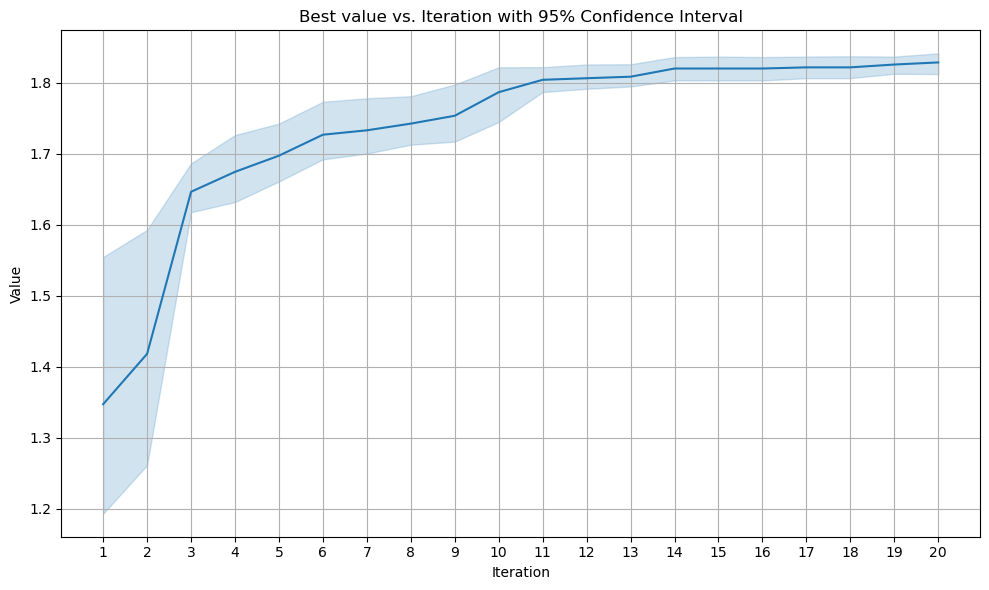

In [17]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import qExpectedImprovement, qNoisyExpectedImprovement
from botorch.optim import optimize_acqf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation
import seaborn as sns
import pandas as pd
from botorch.utils.sampling import draw_sobol_samples
from torch.quasirandom import SobolEngine

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
dtype = torch.float64
bounds = torch.tensor([[0., 0.,0.,0.,0.,0.,0.], [1., 1.,1.,1.,1.,1.,1.]], dtype=dtype, device=device)

for N in range(3,11):
    for batch_size in range(1,7):
        instances=4
        iteration_number=20
        iterations = list(range(1, iteration_number+1))
        supra_best=[]
        
        for ins in range(0,instances+1):
            print("Instance:",ins)
            #train_x = torch.rand(N, 2, dtype=dtype, device=device)
            sobol_engine = SobolEngine(dimension=7, scramble=False)  # 2 dimensions for your input space
            train_x = draw_sobol_samples(bounds=bounds, n=1, q=N).squeeze(0)
            print(train_x)
            train_y, y_sem = predict_and_evaluate(models, model_weights, train_x.reshape(N,7))
            train_y=torch.from_numpy(train_y).reshape(-1,1).to(device=device, dtype=dtype)
            y_sem=torch.from_numpy(y_sem).reshape(-1,1).to(device=device, dtype=dtype)
            modelar = []
        
            gp_model = HeteroskedasticSingleTaskGP(train_x,train_y,y_sem).to(device=device, dtype=dtype)
            mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
            fit_gpytorch_model(mll)
        
            modelar.append(gp_model)
        
            best_points = []
            best_y_values=[]
        
            for iteration in range(iteration_number):
                EI = qNoisyExpectedImprovement(model=gp_model, X_baseline=train_x)#, maximize=True)
                candidate, _ = optimize_acqf(
                    acq_function=EI,
                    bounds=bounds,
                    q=batch_size,
                    num_restarts=5,
                    raw_samples=20,
                    options={"dtype": dtype, "device": device}
                )
                
                new_y, new_y_sem = predict_and_evaluate(models, model_weights, candidate)
                new_y=torch.from_numpy(new_y).reshape(-1,1).to(device=device, dtype=dtype)
                new_y_sem=torch.from_numpy(new_y_sem).reshape(-1,1).to(device=device, dtype=dtype)
                train_x = torch.cat([train_x, candidate])
                train_y = torch.cat([train_y, new_y])
                y_sem = torch.cat([y_sem, new_y_sem])

                del gp_model,mll
                
                gp_model = HeteroskedasticSingleTaskGP(train_x, train_y, y_sem).to(device=device, dtype=dtype)
                mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
                fit_gpytorch_model(mll)
                
                #frames_x.append(train_x.cpu().numpy())
                #frames_y.append(train_y.cpu().numpy())
                best_points.append(train_x[train_y.argmax(), :].cpu().numpy())
                best_y_values.append(train_y.max().cpu().numpy())
                modelar.append(gp_model)
        
            best_point = train_x[train_y.argmax(), :]
            best_value = train_y.max().item()
        
            best_y_values = np.array([element for element in best_y_values])
            supra_best.append(best_y_values)
            #torch.save(gp_model.state_dict())
            print("Best observed point:", best_point.cpu().numpy(), "Best observed value:", best_value)
        
            # Plotting the best Y values vs iterations
            plt.figure(figsize=(10, 6))
            plt.plot(iterations, best_y_values, marker='o', linestyle='-', color='b')
            plt.title('Best Y Values vs Iterations')
            plt.xlabel('Iteration')
            plt.ylabel('Best Y Value')
            plt.grid(True)
            plt.tight_layout()
            plt.savefig("N_"+str(N)+"_B_"+str(batch_size)+"_best_value_vs_iterations_q_"+str(batch_size)+"_ins_"+str(ins)+".png",bbox_inches="tight",dpi=600)
            plt.close()
        
        # Transposing 'supra_best' to get a list of 101 points for each of the 20 instances
        #print(supra_best)
        melted_data = []
        
        # Iterate through each array and its index (using enumerate for iteration count)
        for iteration, arr in enumerate(supra_best, start=1):
            for idx, value in enumerate(arr, start=1):
                melted_data.append({'Iteration': idx, 'Value': value, 'Array_Instance': iteration})
        
        # Convert the list to a DataFrame
        df_melted = pd.DataFrame(melted_data)
        
        plt.figure(figsize=(10, 6))
        
        # Use seaborn lineplot to automatically handle mean and confidence intervals
        sns.lineplot(data=df_melted, x='Iteration', y='Value', estimator='mean', errorbar=('ci', 95))
        
        plt.xticks(range(1, max(df_melted['Iteration'])+1))
        
        plt.grid(True)  # Enable grid
        
        plt.title('Best value vs. Iteration with 95% Confidence Interval')
        plt.xlabel('Iteration')
        plt.ylabel('Value')
        plt.tight_layout()
        plt.savefig("surrogate_instances_N_"+str(N)+"_B_"+str(batch_size)+".png",bbox_inches="tight",dpi=600)

In [108]:
df_melted.to_csv("surrogate_instances.csv",index=False)

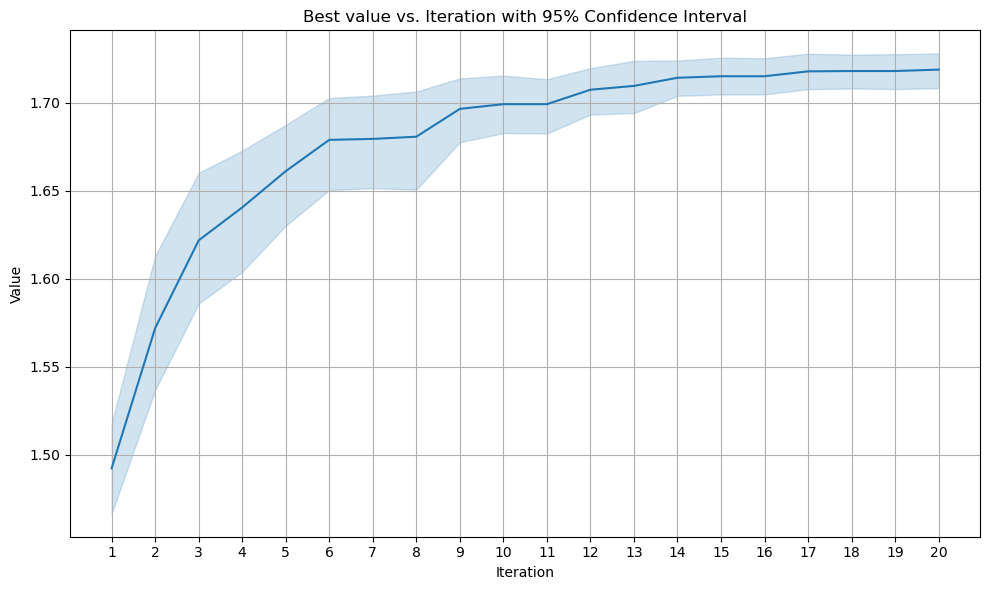

In [111]:



df_melted=pd.read_csv("surrogate_instances.csv")
# Using seaborn to plot with confidence intervals

